In [1]:
import pymssql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller, kpss
import itertools
import statsmodels.tsa.api as tsa

def DB_connection(tank_seq, low_error):
    conn = pymssql.connect(server='sql16ssd-014.localnet.kr', user='i2on11_admin', password='root0826', database='i2on11_admin')
    cursor = conn.cursor()

    conn_sql = 'SELECT signal_time, tank_remain_volume FROM gas_tank_volume_history where tank_seq = ' + tank_seq + 'ORDER BY signal_time DESC'

    # 쿼리 실행
    cursor.execute(conn_sql)

    # 결과 가져오기
    rows = cursor.fetchall()

    # 연결 닫기
    conn.close()
    d_h = pd.DataFrame(rows, columns=['datetime', 'history'])
    d_h['datetime'] = pd.to_datetime(d_h['datetime'])
    d_h.set_index('datetime', inplace=True)
    d_h.sort_index(ascending=True, inplace=True)
    d_h.drop(d_h[d_h['history'] <= 3].index, inplace=True)

    diff_d_h = d_h.copy()
    diff_d_h['history'] = diff_d_h['history'].diff()
    diff_d_h = diff_d_h.dropna()
    recent_datetime = diff_d_h['history'].index[-1] if (diff_d_h['history'] > 15).any() else diff_d_h.index.min()
    diff_d_h[diff_d_h >15] = 0
#     d_h = d_h[d_h.index>=recent_datetime]
#     diff_d_h = d_h.copy()
#     diff_d_h['history'] = diff_d_h['history'].diff()
#     diff_d_h = diff_d_h.dropna()
    
    diff_2d_h = diff_d_h.copy()
    diff_2d_h['history'] = diff_2d_h['history'].diff()
    diff_2d_h = diff_2d_h.dropna()

    diff_3d_h = diff_2d_h.copy()
    diff_3d_h['history'] = diff_3d_h['history'].diff()
    diff_3d_h = diff_3d_h.dropna()
    return d_h, diff_d_h, diff_2d_h, diff_3d_h

In [2]:
def adf_kpss_testing(history_diff):
    found_index = None
    
    for history_index, history in enumerate(history_diff):    
        try:
            # Perform Augmented Dickey-Fuller (ADF) test
            adf_result = adfuller(history)
            adf_statistic = adf_result[0]
            adf_pvalue = adf_result[1]
            adf_critical_values = adf_result[4]
            adf_test = (adf_pvalue < 0.05)
            adf_st_test = (adf_statistic >= -10)
            print('adf p-value : ', adf_pvalue, adf_test)
            print('adf statistic : ', adf_statistic, adf_st_test)
            # Perform Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
        except:
            adf_test = False
        try:
            kpss_result = kpss(history)
            kpss_statistic = kpss_result[0]
            kpss_pvalue = kpss_result[1]
            kpss_critical_values = kpss_result[3]
            kpss_test = (kpss_pvalue < 0.05)
        except:
            kpss_test= False
            print("kpss_test Warning")
            continue
        print(history_index,' kpss p-value : ', kpss_pvalue, kpss_test)
        if history_index == 0:
            continue
        if adf_test and not kpss_test :
            if found_index is None:
                found_index = history_index - 1
            elif (adf_st_test) :
                found_index = history_index - 1
            else:
                break
        
    if found_index is not None:
        print("Index:", found_index)
    else:
        found_index = 0
        print("Index not found.")
    return found_index

In [3]:
def none_differencing_func(pred_h, pred_df, datetime, prevalue):
    for i in range(0, len(pred_df['mean'])):
        datetime = pred_df.index[i]
        prevalue = pred_df['mean'][i]
        pred_h[str(datetime)] = str(prevalue)
    return pred_h

In [4]:
def first_differencing_func(pred_h, pred_df, datetime, prevalue):
    for i in range(0, len(pred_df['mean'])):
        datetime = pred_df.index[i]  # access datetime using index
        prevalue = round(prevalue + pred_df['mean'][i],3)
        pred_h[str(datetime)] = str(prevalue)
    return pred_h

In [5]:
def second_differencing_func(pred_h, pred_df, prevalue, datetime, diffmaxindex, differing):
    for i in range(0, len(pred_df['mean'])):
        differing = differing + pred_df['mean'][i]
        datetime = pred_df.index[i]  # access datetime using index
        prevalue = round(prevalue + differing,3)
        pred_h[str(datetime)] = str(prevalue)
    return pred_h

In [6]:
def ARIMA_prediction(found_index, history_diff):
    rcParams['figure.figsize'] = (15, 20)
    
    d_h = history_diff[0]
    diff_d_h = history_diff[1]
#     plt.figure(figsize=(10, 5))
#     plt.plot(d_h)
    
    y=history_diff[found_index].resample('1D').mean()
    y.isnull().sum()
    y1 = y.fillna(method='ffill')
    p=d=q=range(0,2)
    pdq = list(itertools.product(p,d,q))
    seasonal_pdq = [(x[0],x[1],x[2]) for x in  list(itertools.product(p,d,q))]

    for param in pdq:
        try:
            mod = tsa.statespace.SARIMAX(y1, order=param, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            param_list.append(param)
            results_AIC_list.append(results.aic)
        except:
            continue
    # print(param)
    mod = tsa.statespace.SARIMAX(y1, order=param,
                                enforce_stationarity=True, enforce_invertibility=False)
    results=mod.fit()
    max_date = history_diff[found_index].index.max()
    new_date = max_date + pd.DateOffset(days=14)
#     print(new_date)
    pred = results.get_prediction(start=pd.to_datetime(max_date),
                                 end=pd.to_datetime(new_date), dynamic=True)
    pred_df = pred.summary_frame()
    pred_df.rename_axis('datetime', inplace=True)
    # Extract the hours, minutes, and seconds from max_date
    max_hours = max_date.hour
    max_minutes = max_date.minute
    max_seconds = max_date.second

    # Set the hours, minutes, and seconds of the datetime column in pred_df
    pred_df.index = pred_df.index.map(lambda timestamp: timestamp.replace(
        hour=max_hours, minute=max_minutes, second=max_seconds
    ))
    prevalue = d_h.loc[d_h.index.max()]
    datetime_max = d_h.index.max()
    diffmaxindex = diff_d_h.index.max()
    differing = diff_d_h.loc[diffmaxindex]
    pred_h = {str(datetime_max) : str(prevalue)}
#     print(found_index)
    if found_index == 1:
        pred_h = first_differencing_func(pred_h, pred_df, datetime_max, prevalue)
    elif found_index == 0:
        pred_h = none_differencing_func(pred_h, pred_df, datetime_max, prevalue)
    else:
        pred_h = second_differencing_func(pred_h, pred_df, prevalue, datetime_max, diffmaxindex, differing)
#     else :
#         pred_h = none_differencing_func(pred_h, pred_df, datetime_max, prevalue)
    return pred_h

adf p-value :  9.994514556876972e-05 True
adf statistic :  -4.660089801218544 True
0  kpss p-value :  0.1 False
adf p-value :  4.314931674952855e-06 True
adf statistic :  -5.349772903991253 True
1  kpss p-value :  0.01 True
adf p-value :  8.176143706702159e-20 True
adf statistic :  -10.964320623833169 False
2  kpss p-value :  0.1 False
adf p-value :  4.870517316314824e-21 True
adf statistic :  -11.485751921642736 False
3  kpss p-value :  0.1 False
Index: 1


C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

{'2023-05-24 04:37:38': '62', '2023-05-25 04:37:38': '61.097', '2023-05-26 04:37:38': '60.434', '2023-05-27 04:37:38': '59.707', '2023-05-28 04:37:38': '58.997', '2023-05-29 04:37:38': '58.283', '2023-05-30 04:37:38': '57.57', '2023-05-31 04:37:38': '56.856', '2023-06-01 04:37:38': '56.143', '2023-06-02 04:37:38': '55.43', '2023-06-03 04:37:38': '54.717', '2023-06-04 04:37:38': '54.004', '2023-06-05 04:37:38': '53.291', '2023-06-06 04:37:38': '52.578', '2023-06-07 04:37:38': '51.865', '2023-06-08 04:37:38': '51.152'}


C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


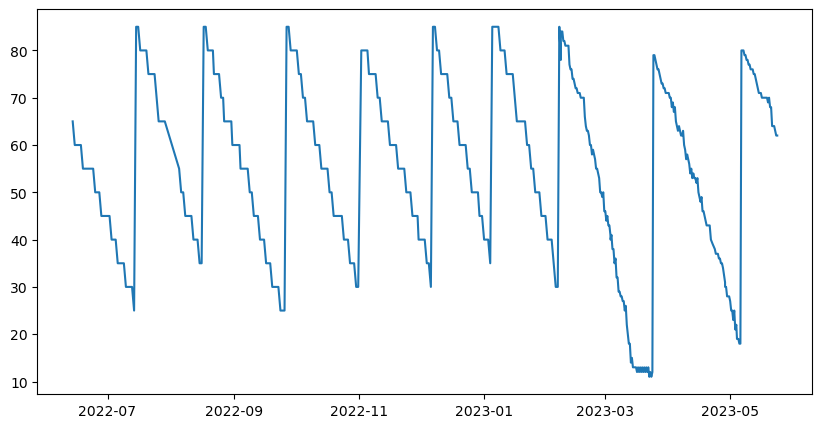

In [8]:
def prediction_by_tank_seq(tank_seq):
    d_h, diff_d_h, diff_2d_h, diff_3d_h = DB_connection(tank_seq, True)
    d_h = DB_connection(tank_seq, False)[0]
    history_diff = [d_h['history'], diff_d_h['history'], diff_2d_h['history'], diff_3d_h['history']]
    found_index = adf_kpss_testing(history_diff)
    pred_h = ARIMA_prediction(found_index, history_diff)
    return pred_h

print(prediction_by_tank_seq('302'))

In [23]:
from flask import Flask
from flask import request
from datetime import datetime
app = Flask(__name__)

@app.route('/test', methods=['POST'])
def seaqq():
    data = request.form
    remain = data['remain']
    seq = data['seq']
    timestamp = data['timestamp']

    runningvalue = runmodel(timestamp, seq, remain)
    stringreturnvalue = str(runningvalue)
    print(stringreturnvalue)

    return jsonify({'result': runningvalue})

if __name__ == "__main__":
    app.run(host="0.0.0.0", port="5000")

[(172,), (173,), (300,), (301,), (302,), (303,), (304,), (305,), (306,), (307,), (308,), (309,), (310,), (311,), (312,), (313,), (315,), (316,), (317,), (318,), (319,), (320,), (321,), (323,), (324,), (325,), (326,), (327,), (328,), (329,), (330,), (331,), (332,), (333,), (335,), (336,), (338,), (339,), (340,), (341,), (342,), (345,), (346,), (347,), (348,), (350,), (351,), (352,), (353,), (354,), (355,), (356,), (357,), (358,), (359,), (360,), (361,), (362,), (363,), (364,), (366,), (367,), (368,), (369,), (370,), (371,), (372,), (374,), (375,), (376,), (377,), (378,), (379,), (380,), (381,), (382,), (383,), (384,), (386,), (387,), (388,), (389,), (390,), (391,), (392,), (393,), (394,), (395,), (396,), (397,), (398,), (399,), (400,), (401,), (403,), (405,), (406,), (407,), (408,), (409,), (410,), (411,), (412,), (413,), (414,), (415,), (417,), (418,), (419,), (420,), (422,), (424,), (425,), (435,), (441,), (460,), (463,), (464,), (475,), (477,), (492,), (493,), (502,), (503,), (505,),

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-12 03:13:47', '65'), ('2023-05-13 03:13:47', '61.865'), ('2023-05-14 03:13:47', '57.548'), ('2023-05-15 03:13:47', '53.314'), ('2023-05-16 03:13:47', '49.074'), ('2023-05-17 03:13:47', '44.835'), ('2023-05-18 03:13:47', '40.596'), ('2023-05-19 03:13:47', '36.357'), ('2023-05-20 03:13:47', '32.118'), ('2023-05-21 03:13:47', '27.879'), ('2023-05-22 03:13:47', '23.64'), ('2023-05-23 03:13:47', '19.401'), ('2023-05-24 03:13:47', '15.162'), ('2023-05-25 03:13:47', '10.923'), ('2023-05-26 03:13:47', '6.684'), ('2023-05-27 03:13:47', '2.445')])
['172', '2023-05-12 03:13:47', '65']
['172', '2023-05-13 03:13:47', '61.865']
['172', '2023-05-14 03:13:47', '57.548']
['172', '2023-05-15 03:13:47', '53.314']
['172', '2023-05-16 03:13:47', '49.074']
['172', '2023-05-17 03:13:47', '44.835']
['172', '2023-05-18 03:13:47', '40.596']
['172', '2023-05-19 03:13:47', '36.357']
['172', '2023-05-20 03:13:47', '32.118']
['172', '2023-05-21 03:13:47', '27.879']
['172', '2023-05-22 03:13:47

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-12 03:13:18', '65'), ('2023-05-13 03:13:18', '61.699'), ('2023-05-14 03:13:18', '57.527'), ('2023-05-15 03:13:18', '53.4'), ('2023-05-16 03:13:18', '49.271'), ('2023-05-17 03:13:18', '45.142'), ('2023-05-18 03:13:18', '41.013'), ('2023-05-19 03:13:18', '36.884'), ('2023-05-20 03:13:18', '32.755'), ('2023-05-21 03:13:18', '28.626'), ('2023-05-22 03:13:18', '24.497'), ('2023-05-23 03:13:18', '20.368'), ('2023-05-24 03:13:18', '16.239'), ('2023-05-25 03:13:18', '12.11'), ('2023-05-26 03:13:18', '7.981'), ('2023-05-27 03:13:18', '3.852')])
['173', '2023-05-12 03:13:18', '65']
['173', '2023-05-13 03:13:18', '61.699']
['173', '2023-05-14 03:13:18', '57.527']
['173', '2023-05-15 03:13:18', '53.4']
['173', '2023-05-16 03:13:18', '49.271']
['173', '2023-05-17 03:13:18', '45.142']
['173', '2023-05-18 03:13:18', '41.013']
['173', '2023-05-19 03:13:18', '36.884']
['173', '2023-05-20 03:13:18', '32.755']
['173', '2023-05-21 03:13:18', '28.626']
['173', '2023-05-22 03:13:18', '

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 13:17:04', '15'), ('2023-05-25 13:17:04', '12.772'), ('2023-05-26 13:17:04', '10.408'), ('2023-05-27 13:17:04', '8.05'), ('2023-05-28 13:17:04', '5.692'), ('2023-05-29 13:17:04', '3.334'), ('2023-05-30 13:17:04', '0.976'), ('2023-05-31 13:17:04', '-1.382'), ('2023-06-01 13:17:04', '-3.74'), ('2023-06-02 13:17:04', '-6.098'), ('2023-06-03 13:17:04', '-8.456'), ('2023-06-04 13:17:04', '-10.814'), ('2023-06-05 13:17:04', '-13.172'), ('2023-06-06 13:17:04', '-15.53'), ('2023-06-07 13:17:04', '-17.888'), ('2023-06-08 13:17:04', '-20.246')])
['300', '2023-05-24 13:17:04', '15']
['300', '2023-05-25 13:17:04', '12.772']
['300', '2023-05-26 13:17:04', '10.408']
['300', '2023-05-27 13:17:04', '8.05']
['300', '2023-05-28 13:17:04', '5.692']
['300', '2023-05-29 13:17:04', '3.334']
['300', '2023-05-30 13:17:04', '0.976']
['300', '2023-05-31 13:17:04', '-1.382']
['300', '2023-06-01 13:17:04', '-3.74']
['300', '2023-06-02 13:17:04', '-6.098']
['300', '2023-06-03 13:17:04', '-

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 13:46:38', '23'), ('2023-05-25 13:46:38', '21.32'), ('2023-05-26 13:46:38', '19.507'), ('2023-05-27 13:46:38', '17.699'), ('2023-05-28 13:46:38', '15.891'), ('2023-05-29 13:46:38', '14.083'), ('2023-05-30 13:46:38', '12.275'), ('2023-05-31 13:46:38', '10.467'), ('2023-06-01 13:46:38', '8.659'), ('2023-06-02 13:46:38', '6.851'), ('2023-06-03 13:46:38', '5.043'), ('2023-06-04 13:46:38', '3.235'), ('2023-06-05 13:46:38', '1.427'), ('2023-06-06 13:46:38', '-0.381'), ('2023-06-07 13:46:38', '-2.189'), ('2023-06-08 13:46:38', '-3.997')])
['301', '2023-05-24 13:46:38', '23']
['301', '2023-05-25 13:46:38', '21.32']
['301', '2023-05-26 13:46:38', '19.507']
['301', '2023-05-27 13:46:38', '17.699']
['301', '2023-05-28 13:46:38', '15.891']
['301', '2023-05-29 13:46:38', '14.083']
['301', '2023-05-30 13:46:38', '12.275']
['301', '2023-05-31 13:46:38', '10.467']
['301', '2023-06-01 13:46:38', '8.659']
['301', '2023-06-02 13:46:38', '6.851']
['301', '2023-06-03 13:46:38', '5.

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

adf p-value :  4.314931674952855e-06 True
adf statistic :  -5.349772903991253 True
1  kpss p-value :  0.01 True
adf p-value :  8.176143706702159e-20 True
adf statistic :  -10.964320623833169 False
2  kpss p-value :  0.1 False
adf p-value :  4.870517316314824e-21 True
adf statistic :  -11.485751921642736 False
3  kpss p-value :  0.1 False
Index: 1


C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dict_items([('2023-05-24 04:37:38', '62'), ('2023-05-25 04:37:38', '61.097'), ('2023-05-26 04:37:38', '60.434'), ('2023-05-27 04:37:38', '59.707'), ('2023-05-28 04:37:38', '58.997'), ('2023-05-29 04:37:38', '58.283'), ('2023-05-30 04:37:38', '57.57'), ('2023-05-31 04:37:38', '56.856'), ('2023-06-01 04:37:38', '56.143'), ('2023-06-02 04:37:38', '55.43'), ('2023-06-03 04:37:38', '54.717'), ('2023-06-04 04:37:38', '54.004'), ('2023-06-05 04:37:38', '53.291'), ('2023-06-06 04:37:38', '52.578'), ('2023-06-07 04:37:38', '51.865'), ('2023-06-08 04:37:38', '51.152')])
['302', '2023-05-24 04:37:38', '62']
['302', '2023-05-25 04:37:38', '61.097']
['302', '2023-05-26 04:37:38', '60.434']
['302', '2023-05-27 04:37:38', '59.707']
['302', '2023-05-28 04:37:38', '58.997']
['302', '2023-05-29 04:37:38', '58.283']
['302', '2023-05-30 04:37:38', '57.57']
['302', '2023-05-31 04:37:38', '56.856']
['302', '2023-06-01 04:37:38', '56.143']
['302', '2023-06-02 04:37:38', '55.43']
['302', '2023-06-03 04:37:38'

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 13:19:11', '53'), ('2023-05-25 13:19:11', '52.463'), ('2023-05-26 13:19:11', '51.886'), ('2023-05-27 13:19:11', '51.31'), ('2023-05-28 13:19:11', '50.734'), ('2023-05-29 13:19:11', '50.158'), ('2023-05-30 13:19:11', '49.582'), ('2023-05-31 13:19:11', '49.006'), ('2023-06-01 13:19:11', '48.43'), ('2023-06-02 13:19:11', '47.854'), ('2023-06-03 13:19:11', '47.278'), ('2023-06-04 13:19:11', '46.702'), ('2023-06-05 13:19:11', '46.126'), ('2023-06-06 13:19:11', '45.55'), ('2023-06-07 13:19:11', '44.974'), ('2023-06-08 13:19:11', '44.398')])
['303', '2023-05-24 13:19:11', '53']
['303', '2023-05-25 13:19:11', '52.463']
['303', '2023-05-26 13:19:11', '51.886']
['303', '2023-05-27 13:19:11', '51.31']
['303', '2023-05-28 13:19:11', '50.734']
['303', '2023-05-29 13:19:11', '50.158']
['303', '2023-05-30 13:19:11', '49.582']
['303', '2023-05-31 13:19:11', '49.006']
['303', '2023-06-01 13:19:11', '48.43']
['303', '2023-06-02 13:19:11', '47.854']
['303', '2023-06-03 13:19:11',

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


adf p-value :  3.8471755242247673e-10 True
adf statistic :  -7.115189794290847 True
1  kpss p-value :  0.03920004312921373 True
adf p-value :  7.339386850778178e-29 True
adf statistic :  -15.951983043029308 False
2  kpss p-value :  0.1 False
adf p-value :  0.0 True
adf statistic :  -20.553331846958496 False
3  kpss p-value :  0.1 False
Index: 1
dict_items([('2023-05-24 13:54:10', '55'), ('2023-05-25 13:54:10', '54.613'), ('2023-05-26 13:54:10', '54.056'), ('2023-05-27 13:54:10', '53.512'), ('2023-05-28 13:54:10', '52.967'), ('2023-05-29 13:54:10', '52.422'), ('2023-05-30 13:54:10', '51.877'), ('2023-05-31 13:54:10', '51.332'), ('2023-06-01 13:54:10', '50.787'), ('2023-06-02 13:54:10', '50.242'), ('2023-06-03 13:54:10', '49.697'), ('2023-06-04 13:54:10', '49.152'), ('2023-06-05 13:54:10', '48.607'), ('2023-06-06 13:54:10', '48.062'), ('2023-06-07 13:54:10', '47.517'), ('2023-06-08 13:54:10', '46.972')])
['304', '2023-05-24 13:54:10', '55']
['304', '2023-05-25 13:54:10', '54.613']
['304'

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

adf p-value :  1.6427026214701866e-22 True
adf statistic :  -12.142020048694777 False
2  kpss p-value :  0.1 False
adf p-value :  0.0 True
adf statistic :  -19.30971105428135 False
3  kpss p-value :  0.1 False
Index: 1
dict_items([('2023-05-24 13:07:08', '82'), ('2023-05-25 13:07:08', '81.729'), ('2023-05-26 13:07:08', '81.459'), ('2023-05-27 13:07:08', '81.189'), ('2023-05-28 13:07:08', '80.919'), ('2023-05-29 13:07:08', '80.649'), ('2023-05-30 13:07:08', '80.379'), ('2023-05-31 13:07:08', '80.109'), ('2023-06-01 13:07:08', '79.839'), ('2023-06-02 13:07:08', '79.569'), ('2023-06-03 13:07:08', '79.299'), ('2023-06-04 13:07:08', '79.029'), ('2023-06-05 13:07:08', '78.759'), ('2023-06-06 13:07:08', '78.489'), ('2023-06-07 13:07:08', '78.219'), ('2023-06-08 13:07:08', '77.949')])
['305', '2023-05-24 13:07:08', '82']
['305', '2023-05-25 13:07:08', '81.729']
['305', '2023-05-26 13:07:08', '81.459']
['305', '2023-05-27 13:07:08', '81.189']
['305', '2023-05-28 13:07:08', '80.919']
['305', '20

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 13:54:40', '79'), ('2023-05-25 13:54:40', '78.212'), ('2023-05-26 13:54:40', '77.416'), ('2023-05-27 13:54:40', '76.62'), ('2023-05-28 13:54:40', '75.824'), ('2023-05-29 13:54:40', '75.028'), ('2023-05-30 13:54:40', '74.232'), ('2023-05-31 13:54:40', '73.436'), ('2023-06-01 13:54:40', '72.64'), ('2023-06-02 13:54:40', '71.844'), ('2023-06-03 13:54:40', '71.048'), ('2023-06-04 13:54:40', '70.252'), ('2023-06-05 13:54:40', '69.456'), ('2023-06-06 13:54:40', '68.66'), ('2023-06-07 13:54:40', '67.864'), ('2023-06-08 13:54:40', '67.068')])
['306', '2023-05-24 13:54:40', '79']
['306', '2023-05-25 13:54:40', '78.212']
['306', '2023-05-26 13:54:40', '77.416']
['306', '2023-05-27 13:54:40', '76.62']
['306', '2023-05-28 13:54:40', '75.824']
['306', '2023-05-29 13:54:40', '75.028']
['306', '2023-05-30 13:54:40', '74.232']
['306', '2023-05-31 13:54:40', '73.436']
['306', '2023-06-01 13:54:40', '72.64']
['306', '2023-06-02 13:54:40', '71.844']
['306', '2023-06-03 13:54:40',

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 10:52:28', '53'), ('2023-05-25 10:52:28', '44.436'), ('2023-05-26 10:52:28', '36.429'), ('2023-05-27 10:52:28', '28.459'), ('2023-05-28 10:52:28', '20.492'), ('2023-05-29 10:52:28', '12.525'), ('2023-05-30 10:52:28', '4.558'), ('2023-05-31 10:52:28', '-3.409'), ('2023-06-01 10:52:28', '-11.376'), ('2023-06-02 10:52:28', '-19.343'), ('2023-06-03 10:52:28', '-27.31'), ('2023-06-04 10:52:28', '-35.277'), ('2023-06-05 10:52:28', '-43.244'), ('2023-06-06 10:52:28', '-51.211'), ('2023-06-07 10:52:28', '-59.178'), ('2023-06-08 10:52:28', '-67.145')])
['307', '2023-05-24 10:52:28', '53']
['307', '2023-05-25 10:52:28', '44.436']
['307', '2023-05-26 10:52:28', '36.429']
['307', '2023-05-27 10:52:28', '28.459']
['307', '2023-05-28 10:52:28', '20.492']
['307', '2023-05-29 10:52:28', '12.525']
['307', '2023-05-30 10:52:28', '4.558']
['307', '2023-05-31 10:52:28', '-3.409']
['307', '2023-06-01 10:52:28', '-11.376']
['307', '2023-06-02 10:52:28', '-19.343']
['307', '2023-06-0

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 10:50:02', '46'), ('2023-05-25 10:50:02', '37.145'), ('2023-05-26 10:50:02', '28.306'), ('2023-05-27 10:50:02', '19.467'), ('2023-05-28 10:50:02', '10.628'), ('2023-05-29 10:50:02', '1.789'), ('2023-05-30 10:50:02', '-7.05'), ('2023-05-31 10:50:02', '-15.889'), ('2023-06-01 10:50:02', '-24.728'), ('2023-06-02 10:50:02', '-33.567'), ('2023-06-03 10:50:02', '-42.406'), ('2023-06-04 10:50:02', '-51.245'), ('2023-06-05 10:50:02', '-60.084'), ('2023-06-06 10:50:02', '-68.923'), ('2023-06-07 10:50:02', '-77.762'), ('2023-06-08 10:50:02', '-86.601')])
['308', '2023-05-24 10:50:02', '46']
['308', '2023-05-25 10:50:02', '37.145']
['308', '2023-05-26 10:50:02', '28.306']
['308', '2023-05-27 10:50:02', '19.467']
['308', '2023-05-28 10:50:02', '10.628']
['308', '2023-05-29 10:50:02', '1.789']
['308', '2023-05-30 10:50:02', '-7.05']
['308', '2023-05-31 10:50:02', '-15.889']
['308', '2023-06-01 10:50:02', '-24.728']
['308', '2023-06-02 10:50:02', '-33.567']
['308', '2023-06-

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

adf p-value :  2.7980459141829877e-28 True
adf statistic :  -15.449278401170144 False
2  kpss p-value :  0.1 False
adf p-value :  0.0 True
adf statistic :  -20.513716543749897 False
3  kpss p-value :  0.1 False
Index: 1
dict_items([('2023-05-24 13:12:10', '68'), ('2023-05-25 13:12:10', '67.566'), ('2023-05-26 13:12:10', '67.132'), ('2023-05-27 13:12:10', '66.698'), ('2023-05-28 13:12:10', '66.264'), ('2023-05-29 13:12:10', '65.83'), ('2023-05-30 13:12:10', '65.396'), ('2023-05-31 13:12:10', '64.962'), ('2023-06-01 13:12:10', '64.528'), ('2023-06-02 13:12:10', '64.094'), ('2023-06-03 13:12:10', '63.66'), ('2023-06-04 13:12:10', '63.226'), ('2023-06-05 13:12:10', '62.792'), ('2023-06-06 13:12:10', '62.358'), ('2023-06-07 13:12:10', '61.924'), ('2023-06-08 13:12:10', '61.49')])
['309', '2023-05-24 13:12:10', '68']
['309', '2023-05-25 13:12:10', '67.566']
['309', '2023-05-26 13:12:10', '67.132']
['309', '2023-05-27 13:12:10', '66.698']
['309', '2023-05-28 13:12:10', '66.264']
['309', '2023

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

adf p-value :  6.517837102726386e-29 True
adf statistic :  -16.00060017870934 False
2  kpss p-value :  0.1 False
adf p-value :  0.0 True
adf statistic :  -19.695574133800285 False
3  kpss p-value :  0.1 False
Index: 1
dict_items([('2023-05-24 13:37:07', '68'), ('2023-05-25 13:37:07', '67.336'), ('2023-05-26 13:37:07', '66.704'), ('2023-05-27 13:37:07', '66.07'), ('2023-05-28 13:37:07', '65.437'), ('2023-05-29 13:37:07', '64.804'), ('2023-05-30 13:37:07', '64.171'), ('2023-05-31 13:37:07', '63.538'), ('2023-06-01 13:37:07', '62.905'), ('2023-06-02 13:37:07', '62.272'), ('2023-06-03 13:37:07', '61.639'), ('2023-06-04 13:37:07', '61.006'), ('2023-06-05 13:37:07', '60.373'), ('2023-06-06 13:37:07', '59.74'), ('2023-06-07 13:37:07', '59.107'), ('2023-06-08 13:37:07', '58.474')])
['310', '2023-05-24 13:37:07', '68']
['310', '2023-05-25 13:37:07', '67.336']
['310', '2023-05-26 13:37:07', '66.704']
['310', '2023-05-27 13:37:07', '66.07']
['310', '2023-05-28 13:37:07', '65.437']
['310', '2023-0

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 13:31:20.703000', '85'), ('2023-05-25 13:31:20', '77.74920438274903'), ('2023-05-26 13:31:20', '78.16828739521831'), ('2023-05-27 13:31:20', '77.89841684494908'), ('2023-05-28 13:31:20', '78.07220130228964'), ('2023-05-29 13:31:20', '77.96029195322203'), ('2023-05-30 13:31:20', '78.03235652447535'), ('2023-05-31 13:31:20', '77.98595019226813'), ('2023-06-01 13:31:20', '78.01583377627443'), ('2023-06-02 13:31:20', '77.99659009657412'), ('2023-06-03 13:31:20', '78.00898215799252'), ('2023-06-04 13:31:20', '78.00100222959063'), ('2023-06-05 13:31:20', '78.00614094341307'), ('2023-06-06 13:31:20', '78.0028318435792'), ('2023-06-07 13:31:20', '78.00496275455983'), ('2023-06-08 13:31:20', '78.00359054403876')])
['311', '2023-05-24 13:31:20.703000', '85']
['311', '2023-05-25 13:31:20', '77.74920438274903']
['311', '2023-05-26 13:31:20', '78.16828739521831']
['311', '2023-05-27 13:31:20', '77.89841684494908']
['311', '2023-05-28 13:31:20', '78.07220130228964']
['311', 

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 13:37:06', '91'), ('2023-05-25 13:37:06', '89.896'), ('2023-05-26 13:37:06', '89.067'), ('2023-05-27 13:37:06', '88.272'), ('2023-05-28 13:37:06', '87.482'), ('2023-05-29 13:37:06', '86.692'), ('2023-05-30 13:37:06', '85.902'), ('2023-05-31 13:37:06', '85.112'), ('2023-06-01 13:37:06', '84.322'), ('2023-06-02 13:37:06', '83.532'), ('2023-06-03 13:37:06', '82.742'), ('2023-06-04 13:37:06', '81.952'), ('2023-06-05 13:37:06', '81.162'), ('2023-06-06 13:37:06', '80.372'), ('2023-06-07 13:37:06', '79.582'), ('2023-06-08 13:37:06', '78.792')])
['312', '2023-05-24 13:37:06', '91']
['312', '2023-05-25 13:37:06', '89.896']
['312', '2023-05-26 13:37:06', '89.067']
['312', '2023-05-27 13:37:06', '88.272']
['312', '2023-05-28 13:37:06', '87.482']
['312', '2023-05-29 13:37:06', '86.692']
['312', '2023-05-30 13:37:06', '85.902']
['312', '2023-05-31 13:37:06', '85.112']
['312', '2023-06-01 13:37:06', '84.322']
['312', '2023-06-02 13:37:06', '83.532']
['312', '2023-06-03 13:37

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:40:53', '40'), ('2023-05-25 09:40:53', '39.724'), ('2023-05-26 09:40:53', '39.477'), ('2023-05-27 09:40:53', '39.227'), ('2023-05-28 09:40:53', '38.978'), ('2023-05-29 09:40:53', '38.729'), ('2023-05-30 09:40:53', '38.48'), ('2023-05-31 09:40:53', '38.231'), ('2023-06-01 09:40:53', '37.982'), ('2023-06-02 09:40:53', '37.733'), ('2023-06-03 09:40:53', '37.484'), ('2023-06-04 09:40:53', '37.235'), ('2023-06-05 09:40:53', '36.986'), ('2023-06-06 09:40:53', '36.737'), ('2023-06-07 09:40:53', '36.488'), ('2023-06-08 09:40:53', '36.239')])
['313', '2023-05-24 09:40:53', '40']
['313', '2023-05-25 09:40:53', '39.724']
['313', '2023-05-26 09:40:53', '39.477']
['313', '2023-05-27 09:40:53', '39.227']
['313', '2023-05-28 09:40:53', '38.978']
['313', '2023-05-29 09:40:53', '38.729']
['313', '2023-05-30 09:40:53', '38.48']
['313', '2023-05-31 09:40:53', '38.231']
['313', '2023-06-01 09:40:53', '37.982']
['313', '2023-06-02 09:40:53', '37.733']
['313', '2023-06-03 09:40:5

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 12:00:00.053000', '85'), ('2023-05-25 12:00:00', '83.849'), ('2023-05-26 12:00:00', '82.79'), ('2023-05-27 12:00:00', '81.709'), ('2023-05-28 12:00:00', '80.633'), ('2023-05-29 12:00:00', '79.556'), ('2023-05-30 12:00:00', '78.479'), ('2023-05-31 12:00:00', '77.402'), ('2023-06-01 12:00:00', '76.325'), ('2023-06-02 12:00:00', '75.248'), ('2023-06-03 12:00:00', '74.171'), ('2023-06-04 12:00:00', '73.094'), ('2023-06-05 12:00:00', '72.017'), ('2023-06-06 12:00:00', '70.94'), ('2023-06-07 12:00:00', '69.863'), ('2023-06-08 12:00:00', '68.786')])
['315', '2023-05-24 12:00:00.053000', '85']
['315', '2023-05-25 12:00:00', '83.849']
['315', '2023-05-26 12:00:00', '82.79']
['315', '2023-05-27 12:00:00', '81.709']
['315', '2023-05-28 12:00:00', '80.633']
['315', '2023-05-29 12:00:00', '79.556']
['315', '2023-05-30 12:00:00', '78.479']
['315', '2023-05-31 12:00:00', '77.402']
['315', '2023-06-01 12:00:00', '76.325']
['315', '2023-06-02 12:00:00', '75.248']
['315', '2023-

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 12:00:00.113000', '76'), ('2023-05-25 12:00:00', '75.828'), ('2023-05-26 12:00:00', '75.678'), ('2023-05-27 12:00:00', '75.525'), ('2023-05-28 12:00:00', '75.373'), ('2023-05-29 12:00:00', '75.221'), ('2023-05-30 12:00:00', '75.069'), ('2023-05-31 12:00:00', '74.917'), ('2023-06-01 12:00:00', '74.765'), ('2023-06-02 12:00:00', '74.613'), ('2023-06-03 12:00:00', '74.461'), ('2023-06-04 12:00:00', '74.309'), ('2023-06-05 12:00:00', '74.157'), ('2023-06-06 12:00:00', '74.005'), ('2023-06-07 12:00:00', '73.853'), ('2023-06-08 12:00:00', '73.701')])
['316', '2023-05-24 12:00:00.113000', '76']
['316', '2023-05-25 12:00:00', '75.828']
['316', '2023-05-26 12:00:00', '75.678']
['316', '2023-05-27 12:00:00', '75.525']
['316', '2023-05-28 12:00:00', '75.373']
['316', '2023-05-29 12:00:00', '75.221']
['316', '2023-05-30 12:00:00', '75.069']
['316', '2023-05-31 12:00:00', '74.917']
['316', '2023-06-01 12:00:00', '74.765']
['316', '2023-06-02 12:00:00', '74.613']
['316', '20

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 12:00:00.130000', '54'), ('2023-05-25 12:00:00', '52.751'), ('2023-05-26 12:00:00', '51.568'), ('2023-05-27 12:00:00', '50.382'), ('2023-05-28 12:00:00', '49.196'), ('2023-05-29 12:00:00', '48.01'), ('2023-05-30 12:00:00', '46.824'), ('2023-05-31 12:00:00', '45.638'), ('2023-06-01 12:00:00', '44.452'), ('2023-06-02 12:00:00', '43.266'), ('2023-06-03 12:00:00', '42.08'), ('2023-06-04 12:00:00', '40.894'), ('2023-06-05 12:00:00', '39.708'), ('2023-06-06 12:00:00', '38.522'), ('2023-06-07 12:00:00', '37.336'), ('2023-06-08 12:00:00', '36.15')])
['317', '2023-05-24 12:00:00.130000', '54']
['317', '2023-05-25 12:00:00', '52.751']
['317', '2023-05-26 12:00:00', '51.568']
['317', '2023-05-27 12:00:00', '50.382']
['317', '2023-05-28 12:00:00', '49.196']
['317', '2023-05-29 12:00:00', '48.01']
['317', '2023-05-30 12:00:00', '46.824']
['317', '2023-05-31 12:00:00', '45.638']
['317', '2023-06-01 12:00:00', '44.452']
['317', '2023-06-02 12:00:00', '43.266']
['317', '2023-0

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 12:00:00.080000', '81'), ('2023-05-25 12:00:00', '80.958'), ('2023-05-26 12:00:00', '80.928'), ('2023-05-27 12:00:00', '80.894'), ('2023-05-28 12:00:00', '80.861'), ('2023-05-29 12:00:00', '80.828'), ('2023-05-30 12:00:00', '80.795'), ('2023-05-31 12:00:00', '80.762'), ('2023-06-01 12:00:00', '80.729'), ('2023-06-02 12:00:00', '80.696'), ('2023-06-03 12:00:00', '80.663'), ('2023-06-04 12:00:00', '80.63'), ('2023-06-05 12:00:00', '80.597'), ('2023-06-06 12:00:00', '80.564'), ('2023-06-07 12:00:00', '80.531'), ('2023-06-08 12:00:00', '80.498')])
['318', '2023-05-24 12:00:00.080000', '81']
['318', '2023-05-25 12:00:00', '80.958']
['318', '2023-05-26 12:00:00', '80.928']
['318', '2023-05-27 12:00:00', '80.894']
['318', '2023-05-28 12:00:00', '80.861']
['318', '2023-05-29 12:00:00', '80.828']
['318', '2023-05-30 12:00:00', '80.795']
['318', '2023-05-31 12:00:00', '80.762']
['318', '2023-06-01 12:00:00', '80.729']
['318', '2023-06-02 12:00:00', '80.696']
['318', '202

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 00:26:20', '50'), ('2023-05-25 00:26:20', '45.837'), ('2023-05-26 00:26:20', '41.559'), ('2023-05-27 00:26:20', '37.296'), ('2023-05-28 00:26:20', '33.031'), ('2023-05-29 00:26:20', '28.766'), ('2023-05-30 00:26:20', '24.501'), ('2023-05-31 00:26:20', '20.236'), ('2023-06-01 00:26:20', '15.971'), ('2023-06-02 00:26:20', '11.706'), ('2023-06-03 00:26:20', '7.441'), ('2023-06-04 00:26:20', '3.176'), ('2023-06-05 00:26:20', '-1.089'), ('2023-06-06 00:26:20', '-5.354'), ('2023-06-07 00:26:20', '-9.619'), ('2023-06-08 00:26:20', '-13.884')])
['319', '2023-05-24 00:26:20', '50']
['319', '2023-05-25 00:26:20', '45.837']
['319', '2023-05-26 00:26:20', '41.559']
['319', '2023-05-27 00:26:20', '37.296']
['319', '2023-05-28 00:26:20', '33.031']
['319', '2023-05-29 00:26:20', '28.766']
['319', '2023-05-30 00:26:20', '24.501']
['319', '2023-05-31 00:26:20', '20.236']
['319', '2023-06-01 00:26:20', '15.971']
['319', '2023-06-02 00:26:20', '11.706']
['319', '2023-06-03 00:26:

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 01:28:24', '35'), ('2023-05-25 01:28:24', '32.635'), ('2023-05-26 01:28:24', '29.679'), ('2023-05-27 01:28:24', '26.856'), ('2023-05-28 01:28:24', '24.003'), ('2023-05-29 01:28:24', '21.157'), ('2023-05-30 01:28:24', '18.309'), ('2023-05-31 01:28:24', '15.462'), ('2023-06-01 01:28:24', '12.615'), ('2023-06-02 01:28:24', '9.768'), ('2023-06-03 01:28:24', '6.921'), ('2023-06-04 01:28:24', '4.074'), ('2023-06-05 01:28:24', '1.227'), ('2023-06-06 01:28:24', '-1.62'), ('2023-06-07 01:28:24', '-4.467'), ('2023-06-08 01:28:24', '-7.314')])
['320', '2023-05-24 01:28:24', '35']
['320', '2023-05-25 01:28:24', '32.635']
['320', '2023-05-26 01:28:24', '29.679']
['320', '2023-05-27 01:28:24', '26.856']
['320', '2023-05-28 01:28:24', '24.003']
['320', '2023-05-29 01:28:24', '21.157']
['320', '2023-05-30 01:28:24', '18.309']
['320', '2023-05-31 01:28:24', '15.462']
['320', '2023-06-01 01:28:24', '12.615']
['320', '2023-06-02 01:28:24', '9.768']
['320', '2023-06-03 01:28:24', 

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 02:20:54', '55'), ('2023-05-25 02:20:54', '54.558'), ('2023-05-26 02:20:54', '54.064'), ('2023-05-27 02:20:54', '53.564'), ('2023-05-28 02:20:54', '53.063'), ('2023-05-29 02:20:54', '52.562'), ('2023-05-30 02:20:54', '52.061'), ('2023-05-31 02:20:54', '51.56'), ('2023-06-01 02:20:54', '51.059'), ('2023-06-02 02:20:54', '50.558'), ('2023-06-03 02:20:54', '50.057'), ('2023-06-04 02:20:54', '49.556'), ('2023-06-05 02:20:54', '49.055'), ('2023-06-06 02:20:54', '48.554'), ('2023-06-07 02:20:54', '48.053'), ('2023-06-08 02:20:54', '47.552')])
['321', '2023-05-24 02:20:54', '55']
['321', '2023-05-25 02:20:54', '54.558']
['321', '2023-05-26 02:20:54', '54.064']
['321', '2023-05-27 02:20:54', '53.564']
['321', '2023-05-28 02:20:54', '53.063']
['321', '2023-05-29 02:20:54', '52.562']
['321', '2023-05-30 02:20:54', '52.061']
['321', '2023-05-31 02:20:54', '51.56']
['321', '2023-06-01 02:20:54', '51.059']
['321', '2023-06-02 02:20:54', '50.558']
['321', '2023-06-03 02:20:5

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 12:00:00.190000', '85'), ('2023-05-25 12:00:00', '84.833'), ('2023-05-26 12:00:00', '84.701'), ('2023-05-27 12:00:00', '84.561'), ('2023-05-28 12:00:00', '84.423'), ('2023-05-29 12:00:00', '84.285'), ('2023-05-30 12:00:00', '84.147'), ('2023-05-31 12:00:00', '84.009'), ('2023-06-01 12:00:00', '83.871'), ('2023-06-02 12:00:00', '83.733'), ('2023-06-03 12:00:00', '83.595'), ('2023-06-04 12:00:00', '83.457'), ('2023-06-05 12:00:00', '83.319'), ('2023-06-06 12:00:00', '83.181'), ('2023-06-07 12:00:00', '83.043'), ('2023-06-08 12:00:00', '82.905')])
['323', '2023-05-24 12:00:00.190000', '85']
['323', '2023-05-25 12:00:00', '84.833']
['323', '2023-05-26 12:00:00', '84.701']
['323', '2023-05-27 12:00:00', '84.561']
['323', '2023-05-28 12:00:00', '84.423']
['323', '2023-05-29 12:00:00', '84.285']
['323', '2023-05-30 12:00:00', '84.147']
['323', '2023-05-31 12:00:00', '84.009']
['323', '2023-06-01 12:00:00', '83.871']
['323', '2023-06-02 12:00:00', '83.733']
['323', '20

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 12:00:00.073000', '84'), ('2023-05-25 12:00:00', '83.973'), ('2023-05-26 12:00:00', '83.956'), ('2023-05-27 12:00:00', '83.935'), ('2023-05-28 12:00:00', '83.915'), ('2023-05-29 12:00:00', '83.895'), ('2023-05-30 12:00:00', '83.875'), ('2023-05-31 12:00:00', '83.855'), ('2023-06-01 12:00:00', '83.835'), ('2023-06-02 12:00:00', '83.815'), ('2023-06-03 12:00:00', '83.795'), ('2023-06-04 12:00:00', '83.775'), ('2023-06-05 12:00:00', '83.755'), ('2023-06-06 12:00:00', '83.735'), ('2023-06-07 12:00:00', '83.715'), ('2023-06-08 12:00:00', '83.695')])
['324', '2023-05-24 12:00:00.073000', '84']
['324', '2023-05-25 12:00:00', '83.973']
['324', '2023-05-26 12:00:00', '83.956']
['324', '2023-05-27 12:00:00', '83.935']
['324', '2023-05-28 12:00:00', '83.915']
['324', '2023-05-29 12:00:00', '83.895']
['324', '2023-05-30 12:00:00', '83.875']
['324', '2023-05-31 12:00:00', '83.855']
['324', '2023-06-01 12:00:00', '83.835']
['324', '2023-06-02 12:00:00', '83.815']
['324', '20

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 01:17:47', '80'), ('2023-05-25 01:17:47', '79.743'), ('2023-05-26 01:17:47', '79.534'), ('2023-05-27 01:17:47', '79.316'), ('2023-05-28 01:17:47', '79.1'), ('2023-05-29 01:17:47', '78.883'), ('2023-05-30 01:17:47', '78.666'), ('2023-05-31 01:17:47', '78.449'), ('2023-06-01 01:17:47', '78.232'), ('2023-06-02 01:17:47', '78.015'), ('2023-06-03 01:17:47', '77.798'), ('2023-06-04 01:17:47', '77.581'), ('2023-06-05 01:17:47', '77.364'), ('2023-06-06 01:17:47', '77.147'), ('2023-06-07 01:17:47', '76.93'), ('2023-06-08 01:17:47', '76.713')])
['325', '2023-05-24 01:17:47', '80']
['325', '2023-05-25 01:17:47', '79.743']
['325', '2023-05-26 01:17:47', '79.534']
['325', '2023-05-27 01:17:47', '79.316']
['325', '2023-05-28 01:17:47', '79.1']
['325', '2023-05-29 01:17:47', '78.883']
['325', '2023-05-30 01:17:47', '78.666']
['325', '2023-05-31 01:17:47', '78.449']
['325', '2023-06-01 01:17:47', '78.232']
['325', '2023-06-02 01:17:47', '78.015']
['325', '2023-06-03 01:17:47',

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:15:56', '58'), ('2023-05-25 09:15:56', '57.695'), ('2023-05-26 09:15:56', '57.419'), ('2023-05-27 09:15:56', '57.14'), ('2023-05-28 09:15:56', '56.861'), ('2023-05-29 09:15:56', '56.582'), ('2023-05-30 09:15:56', '56.303'), ('2023-05-31 09:15:56', '56.024'), ('2023-06-01 09:15:56', '55.745'), ('2023-06-02 09:15:56', '55.466'), ('2023-06-03 09:15:56', '55.187'), ('2023-06-04 09:15:56', '54.908'), ('2023-06-05 09:15:56', '54.629'), ('2023-06-06 09:15:56', '54.35'), ('2023-06-07 09:15:56', '54.071'), ('2023-06-08 09:15:56', '53.792')])
['326', '2023-05-24 09:15:56', '58']
['326', '2023-05-25 09:15:56', '57.695']
['326', '2023-05-26 09:15:56', '57.419']
['326', '2023-05-27 09:15:56', '57.14']
['326', '2023-05-28 09:15:56', '56.861']
['326', '2023-05-29 09:15:56', '56.582']
['326', '2023-05-30 09:15:56', '56.303']
['326', '2023-05-31 09:15:56', '56.024']
['326', '2023-06-01 09:15:56', '55.745']
['326', '2023-06-02 09:15:56', '55.466']
['326', '2023-06-03 09:15:56

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:15:49', '27'), ('2023-05-25 09:15:49', '24.527'), ('2023-05-26 09:15:49', '22.355'), ('2023-05-27 09:15:49', '20.18'), ('2023-05-28 09:15:49', '18.122'), ('2023-05-29 09:15:49', '16.134'), ('2023-05-30 09:15:49', '14.234'), ('2023-05-31 09:15:49', '12.415'), ('2023-06-01 09:15:49', '10.68'), ('2023-06-02 09:15:49', '9.027'), ('2023-06-03 09:15:49', '7.457'), ('2023-06-04 09:15:49', '5.97'), ('2023-06-05 09:15:49', '4.566'), ('2023-06-06 09:15:49', '3.245'), ('2023-06-07 09:15:49', '2.007'), ('2023-06-08 09:15:49', '0.852')])
['327', '2023-05-24 09:15:49', '27']
['327', '2023-05-25 09:15:49', '24.527']
['327', '2023-05-26 09:15:49', '22.355']
['327', '2023-05-27 09:15:49', '20.18']
['327', '2023-05-28 09:15:49', '18.122']
['327', '2023-05-29 09:15:49', '16.134']
['327', '2023-05-30 09:15:49', '14.234']
['327', '2023-05-31 09:15:49', '12.415']
['327', '2023-06-01 09:15:49', '10.68']
['327', '2023-06-02 09:15:49', '9.027']
['327', '2023-06-03 09:15:49', '7.457'

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:27:50', '30'), ('2023-05-25 09:27:50', '30.434'), ('2023-05-26 09:27:50', '31.265'), ('2023-05-27 09:27:50', '32.132'), ('2023-05-28 09:27:50', '33.17'), ('2023-05-29 09:27:50', '34.329'), ('2023-05-30 09:27:50', '35.627'), ('2023-05-31 09:27:50', '37.057'), ('2023-06-01 09:27:50', '38.622'), ('2023-06-02 09:27:50', '40.321'), ('2023-06-03 09:27:50', '42.155'), ('2023-06-04 09:27:50', '44.123'), ('2023-06-05 09:27:50', '46.225'), ('2023-06-06 09:27:50', '48.462'), ('2023-06-07 09:27:50', '50.833'), ('2023-06-08 09:27:50', '53.338')])
['328', '2023-05-24 09:27:50', '30']
['328', '2023-05-25 09:27:50', '30.434']
['328', '2023-05-26 09:27:50', '31.265']
['328', '2023-05-27 09:27:50', '32.132']
['328', '2023-05-28 09:27:50', '33.17']
['328', '2023-05-29 09:27:50', '34.329']
['328', '2023-05-30 09:27:50', '35.627']
['328', '2023-05-31 09:27:50', '37.057']
['328', '2023-06-01 09:27:50', '38.622']
['328', '2023-06-02 09:27:50', '40.321']
['328', '2023-06-03 09:27:5

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 14:01:43', '15'), ('2023-05-25 14:01:43', '10.299'), ('2023-05-26 14:01:43', '5.058'), ('2023-05-27 14:01:43', '-0.365'), ('2023-05-28 14:01:43', '-6.123'), ('2023-05-29 14:01:43', '-12.151'), ('2023-05-30 14:01:43', '-18.476'), ('2023-05-31 14:01:43', '-25.087'), ('2023-06-01 14:01:43', '-31.988'), ('2023-06-02 14:01:43', '-39.178'), ('2023-06-03 14:01:43', '-46.657'), ('2023-06-04 14:01:43', '-54.425'), ('2023-06-05 14:01:43', '-62.483'), ('2023-06-06 14:01:43', '-70.83'), ('2023-06-07 14:01:43', '-79.466'), ('2023-06-08 14:01:43', '-88.391')])
['329', '2023-05-24 14:01:43', '15']
['329', '2023-05-25 14:01:43', '10.299']
['329', '2023-05-26 14:01:43', '5.058']
['329', '2023-05-27 14:01:43', '-0.365']
['329', '2023-05-28 14:01:43', '-6.123']
['329', '2023-05-29 14:01:43', '-12.151']
['329', '2023-05-30 14:01:43', '-18.476']
['329', '2023-05-31 14:01:43', '-25.087']
['329', '2023-06-01 14:01:43', '-31.988']
['329', '2023-06-02 14:01:43', '-39.178']
['329', '202

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 12:19:32', '20'), ('2023-05-25 12:19:32', '16.129'), ('2023-05-26 12:19:32', '11.938'), ('2023-05-27 12:19:32', '7.789'), ('2023-05-28 12:19:32', '3.635'), ('2023-05-29 12:19:32', '-0.519'), ('2023-05-30 12:19:32', '-4.673'), ('2023-05-31 12:19:32', '-8.827'), ('2023-06-01 12:19:32', '-12.981'), ('2023-06-02 12:19:32', '-17.135'), ('2023-06-03 12:19:32', '-21.289'), ('2023-06-04 12:19:32', '-25.443'), ('2023-06-05 12:19:32', '-29.597'), ('2023-06-06 12:19:32', '-33.751'), ('2023-06-07 12:19:32', '-37.905'), ('2023-06-08 12:19:32', '-42.059')])
['330', '2023-05-24 12:19:32', '20']
['330', '2023-05-25 12:19:32', '16.129']
['330', '2023-05-26 12:19:32', '11.938']
['330', '2023-05-27 12:19:32', '7.789']
['330', '2023-05-28 12:19:32', '3.635']
['330', '2023-05-29 12:19:32', '-0.519']
['330', '2023-05-30 12:19:32', '-4.673']
['330', '2023-05-31 12:19:32', '-8.827']
['330', '2023-06-01 12:19:32', '-12.981']
['330', '2023-06-02 12:19:32', '-17.135']
['330', '2023-06-03

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

adf p-value :  5.974139294270887e-05 True
adf statistic :  -4.77863710617734 True
1  kpss p-value :  0.1 False
adf p-value :  3.785232562609502e-15 True
adf statistic :  -9.09275820795924 True
2  kpss p-value :  0.1 False
adf p-value :  3.4150314263415486e-20 True
adf statistic :  -11.123730229803819 False
3  kpss p-value :  0.1 False
Index: 1
dict_items([('2023-05-23 23:38:20', '65'), ('2023-05-24 23:38:20', '63.572'), ('2023-05-25 23:38:20', '59.195'), ('2023-05-26 23:38:20', '55.832'), ('2023-05-27 23:38:20', '52.12'), ('2023-05-28 23:38:20', '48.528'), ('2023-05-29 23:38:20', '44.895'), ('2023-05-30 23:38:20', '41.276'), ('2023-05-31 23:38:20', '37.652'), ('2023-06-01 23:38:20', '34.03'), ('2023-06-02 23:38:20', '30.408'), ('2023-06-03 23:38:20', '26.786'), ('2023-06-04 23:38:20', '23.164'), ('2023-06-05 23:38:20', '19.542'), ('2023-06-06 23:38:20', '15.92'), ('2023-06-07 23:38:20', '12.298')])
['331', '2023-05-23 23:38:20', '65']
['331', '2023-05-24 23:38:20', '63.572']
['331', '2

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


dict_items([('2023-05-24 01:07:01', '65'), ('2023-05-25 01:07:01', '59.19779029674648'), ('2023-05-26 01:07:01', '57.19742591049682'), ('2023-05-27 01:07:01', '56.507782157095036'), ('2023-05-28 01:07:01', '56.27002122219968'), ('2023-05-29 01:07:01', '56.18805098483659'), ('2023-05-30 01:07:01', '56.15979100252992'), ('2023-05-31 01:07:01', '56.15004811748207'), ('2023-06-01 01:07:01', '56.14668916955261'), ('2023-06-02 01:07:01', '56.145531141808526'), ('2023-06-03 01:07:01', '56.145131901247424'), ('2023-06-04 01:07:01', '56.14499425944528'), ('2023-06-05 01:07:01', '56.14494680618641'), ('2023-06-06 01:07:01', '56.1449304462453'), ('2023-06-07 01:07:01', '56.14492480600731'), ('2023-06-08 01:07:01', '56.14492286148414')])
['332', '2023-05-24 01:07:01', '65']
['332', '2023-05-25 01:07:01', '59.19779029674648']
['332', '2023-05-26 01:07:01', '57.19742591049682']
['332', '2023-05-27 01:07:01', '56.507782157095036']
['332', '2023-05-28 01:07:01', '56.27002122219968']
['332', '2023-05-2

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-23 16:32:24.923000', '85'), ('2023-05-24 16:32:24', '80.091'), ('2023-05-25 16:32:24', '75.412'), ('2023-05-26 16:32:24', '70.722'), ('2023-05-27 16:32:24', '66.033'), ('2023-05-28 16:32:24', '61.344'), ('2023-05-29 16:32:24', '56.655'), ('2023-05-30 16:32:24', '51.966'), ('2023-05-31 16:32:24', '47.277'), ('2023-06-01 16:32:24', '42.588'), ('2023-06-02 16:32:24', '37.899'), ('2023-06-03 16:32:24', '33.21'), ('2023-06-04 16:32:24', '28.521'), ('2023-06-05 16:32:24', '23.832'), ('2023-06-06 16:32:24', '19.143'), ('2023-06-07 16:32:24', '14.454')])
['333', '2023-05-23 16:32:24.923000', '85']
['333', '2023-05-24 16:32:24', '80.091']
['333', '2023-05-25 16:32:24', '75.412']
['333', '2023-05-26 16:32:24', '70.722']
['333', '2023-05-27 16:32:24', '66.033']
['333', '2023-05-28 16:32:24', '61.344']
['333', '2023-05-29 16:32:24', '56.655']
['333', '2023-05-30 16:32:24', '51.966']
['333', '2023-05-31 16:32:24', '47.277']
['333', '2023-06-01 16:32:24', '42.588']
['333', '202

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

0  kpss p-value :  0.1 False
adf p-value :  0.13004281954539243 False
adf statistic :  -2.4427098294768057 True
1  kpss p-value :  0.01 True
adf p-value :  2.262857056732893e-13 True
adf statistic :  -8.398635630230483 True
2  kpss p-value :  0.1 False
adf p-value :  8.455291382259141e-19 True
adf statistic :  -10.545055337568728 False
3  kpss p-value :  0.1 False
Index: 1
dict_items([('2023-05-24 02:31:28', '75'), ('2023-05-25 02:31:28', '73.477'), ('2023-05-26 02:31:28', '71.858'), ('2023-05-27 02:31:28', '70.24'), ('2023-05-28 02:31:28', '68.622'), ('2023-05-29 02:31:28', '67.004'), ('2023-05-30 02:31:28', '65.386'), ('2023-05-31 02:31:28', '63.768'), ('2023-06-01 02:31:28', '62.15'), ('2023-06-02 02:31:28', '60.532'), ('2023-06-03 02:31:28', '58.914'), ('2023-06-04 02:31:28', '57.296'), ('2023-06-05 02:31:28', '55.678'), ('2023-06-06 02:31:28', '54.06'), ('2023-06-07 02:31:28', '52.442'), ('2023-06-08 02:31:28', '50.824')])
['335', '2023-05-24 02:31:28', '75']
['335', '2023-05-25 0

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 00:20:39', '80'), ('2023-05-25 00:20:39', '78.628'), ('2023-05-26 00:20:39', '77.694'), ('2023-05-27 00:20:39', '76.62'), ('2023-05-28 00:20:39', '75.591'), ('2023-05-29 00:20:39', '74.548'), ('2023-05-30 00:20:39', '73.509'), ('2023-05-31 00:20:39', '72.469'), ('2023-06-01 00:20:39', '71.429'), ('2023-06-02 00:20:39', '70.389'), ('2023-06-03 00:20:39', '69.349'), ('2023-06-04 00:20:39', '68.309'), ('2023-06-05 00:20:39', '67.269'), ('2023-06-06 00:20:39', '66.229'), ('2023-06-07 00:20:39', '65.189'), ('2023-06-08 00:20:39', '64.149')])
['336', '2023-05-24 00:20:39', '80']
['336', '2023-05-25 00:20:39', '78.628']
['336', '2023-05-26 00:20:39', '77.694']
['336', '2023-05-27 00:20:39', '76.62']
['336', '2023-05-28 00:20:39', '75.591']
['336', '2023-05-29 00:20:39', '74.548']
['336', '2023-05-30 00:20:39', '73.509']
['336', '2023-05-31 00:20:39', '72.469']
['336', '2023-06-01 00:20:39', '71.429']
['336', '2023-06-02 00:20:39', '70.389']
['336', '2023-06-03 00:20:3

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 02:49:44', '65'), ('2023-05-25 02:49:44', '64.43'), ('2023-05-26 02:49:44', '63.237'), ('2023-05-27 02:49:44', '62.131'), ('2023-05-28 02:49:44', '61.013'), ('2023-05-29 02:49:44', '59.897'), ('2023-05-30 02:49:44', '58.781'), ('2023-05-31 02:49:44', '57.665'), ('2023-06-01 02:49:44', '56.549'), ('2023-06-02 02:49:44', '55.433'), ('2023-06-03 02:49:44', '54.317'), ('2023-06-04 02:49:44', '53.201'), ('2023-06-05 02:49:44', '52.085'), ('2023-06-06 02:49:44', '50.969'), ('2023-06-07 02:49:44', '49.853'), ('2023-06-08 02:49:44', '48.737')])
['338', '2023-05-24 02:49:44', '65']
['338', '2023-05-25 02:49:44', '64.43']
['338', '2023-05-26 02:49:44', '63.237']
['338', '2023-05-27 02:49:44', '62.131']
['338', '2023-05-28 02:49:44', '61.013']
['338', '2023-05-29 02:49:44', '59.897']
['338', '2023-05-30 02:49:44', '58.781']
['338', '2023-05-31 02:49:44', '57.665']
['338', '2023-06-01 02:49:44', '56.549']
['338', '2023-06-02 02:49:44', '55.433']
['338', '2023-06-03 02:49:4

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 02:35:29', '80'), ('2023-05-25 02:35:29', '75.027'), ('2023-05-26 02:35:29', '70.052'), ('2023-05-27 02:35:29', '65.077'), ('2023-05-28 02:35:29', '60.102'), ('2023-05-29 02:35:29', '55.127'), ('2023-05-30 02:35:29', '50.152'), ('2023-05-31 02:35:29', '45.177'), ('2023-06-01 02:35:29', '40.202'), ('2023-06-02 02:35:29', '35.227'), ('2023-06-03 02:35:29', '30.252'), ('2023-06-04 02:35:29', '25.277'), ('2023-06-05 02:35:29', '20.302'), ('2023-06-06 02:35:29', '15.327'), ('2023-06-07 02:35:29', '10.352'), ('2023-06-08 02:35:29', '5.377')])
['339', '2023-05-24 02:35:29', '80']
['339', '2023-05-25 02:35:29', '75.027']
['339', '2023-05-26 02:35:29', '70.052']
['339', '2023-05-27 02:35:29', '65.077']
['339', '2023-05-28 02:35:29', '60.102']
['339', '2023-05-29 02:35:29', '55.127']
['339', '2023-05-30 02:35:29', '50.152']
['339', '2023-05-31 02:35:29', '45.177']
['339', '2023-06-01 02:35:29', '40.202']
['339', '2023-06-02 02:35:29', '35.227']
['339', '2023-06-03 02:35:

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-23 22:39:32', '30'), ('2023-05-24 22:39:32', '27.31'), ('2023-05-25 22:39:32', '24.091'), ('2023-05-26 22:39:32', '20.993'), ('2023-05-27 22:39:32', '17.867'), ('2023-05-28 22:39:32', '14.748'), ('2023-05-29 22:39:32', '11.627'), ('2023-05-30 22:39:32', '8.506'), ('2023-05-31 22:39:32', '5.385'), ('2023-06-01 22:39:32', '2.264'), ('2023-06-02 22:39:32', '-0.857'), ('2023-06-03 22:39:32', '-3.978'), ('2023-06-04 22:39:32', '-7.099'), ('2023-06-05 22:39:32', '-10.22'), ('2023-06-06 22:39:32', '-13.341'), ('2023-06-07 22:39:32', '-16.462')])
['340', '2023-05-23 22:39:32', '30']
['340', '2023-05-24 22:39:32', '27.31']
['340', '2023-05-25 22:39:32', '24.091']
['340', '2023-05-26 22:39:32', '20.993']
['340', '2023-05-27 22:39:32', '17.867']
['340', '2023-05-28 22:39:32', '14.748']
['340', '2023-05-29 22:39:32', '11.627']
['340', '2023-05-30 22:39:32', '8.506']
['340', '2023-05-31 22:39:32', '5.385']
['340', '2023-06-01 22:39:32', '2.264']
['340', '2023-06-02 22:39:32', 

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 11:15:19', '35'), ('2023-05-25 11:15:19', '30.645'), ('2023-05-26 11:15:19', '26.258'), ('2023-05-27 11:15:19', '21.87'), ('2023-05-28 11:15:19', '17.482'), ('2023-05-29 11:15:19', '13.094'), ('2023-05-30 11:15:19', '8.706'), ('2023-05-31 11:15:19', '4.318'), ('2023-06-01 11:15:19', '-0.07'), ('2023-06-02 11:15:19', '-4.458'), ('2023-06-03 11:15:19', '-8.846'), ('2023-06-04 11:15:19', '-13.234'), ('2023-06-05 11:15:19', '-17.622'), ('2023-06-06 11:15:19', '-22.01'), ('2023-06-07 11:15:19', '-26.398'), ('2023-06-08 11:15:19', '-30.786')])
['341', '2023-05-24 11:15:19', '35']
['341', '2023-05-25 11:15:19', '30.645']
['341', '2023-05-26 11:15:19', '26.258']
['341', '2023-05-27 11:15:19', '21.87']
['341', '2023-05-28 11:15:19', '17.482']
['341', '2023-05-29 11:15:19', '13.094']
['341', '2023-05-30 11:15:19', '8.706']
['341', '2023-05-31 11:15:19', '4.318']
['341', '2023-06-01 11:15:19', '-0.07']
['341', '2023-06-02 11:15:19', '-4.458']
['341', '2023-06-03 11:15:19'

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 11:56:44', '65'), ('2023-05-25 11:56:44', '64.483'), ('2023-05-26 11:56:44', '63.872'), ('2023-05-27 11:56:44', '63.244'), ('2023-05-28 11:56:44', '62.613'), ('2023-05-29 11:56:44', '61.981'), ('2023-05-30 11:56:44', '61.349'), ('2023-05-31 11:56:44', '60.717'), ('2023-06-01 11:56:44', '60.085'), ('2023-06-02 11:56:44', '59.453'), ('2023-06-03 11:56:44', '58.821'), ('2023-06-04 11:56:44', '58.189'), ('2023-06-05 11:56:44', '57.557'), ('2023-06-06 11:56:44', '56.925'), ('2023-06-07 11:56:44', '56.293'), ('2023-06-08 11:56:44', '55.661')])
['342', '2023-05-24 11:56:44', '65']
['342', '2023-05-25 11:56:44', '64.483']
['342', '2023-05-26 11:56:44', '63.872']
['342', '2023-05-27 11:56:44', '63.244']
['342', '2023-05-28 11:56:44', '62.613']
['342', '2023-05-29 11:56:44', '61.981']
['342', '2023-05-30 11:56:44', '61.349']
['342', '2023-05-31 11:56:44', '60.717']
['342', '2023-06-01 11:56:44', '60.085']
['342', '2023-06-02 11:56:44', '59.453']
['342', '2023-06-03 11:56

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:56:46', '48'), ('2023-05-25 09:56:46', '47.356'), ('2023-05-26 09:56:46', '46.915'), ('2023-05-27 09:56:46', '46.504'), ('2023-05-28 09:56:46', '46.097'), ('2023-05-29 09:56:46', '45.691'), ('2023-05-30 09:56:46', '45.285'), ('2023-05-31 09:56:46', '44.879'), ('2023-06-01 09:56:46', '44.473'), ('2023-06-02 09:56:46', '44.067'), ('2023-06-03 09:56:46', '43.661'), ('2023-06-04 09:56:46', '43.255'), ('2023-06-05 09:56:46', '42.849'), ('2023-06-06 09:56:46', '42.443'), ('2023-06-07 09:56:46', '42.037'), ('2023-06-08 09:56:46', '41.631')])
['345', '2023-05-24 09:56:46', '48']
['345', '2023-05-25 09:56:46', '47.356']
['345', '2023-05-26 09:56:46', '46.915']
['345', '2023-05-27 09:56:46', '46.504']
['345', '2023-05-28 09:56:46', '46.097']
['345', '2023-05-29 09:56:46', '45.691']
['345', '2023-05-30 09:56:46', '45.285']
['345', '2023-05-31 09:56:46', '44.879']
['345', '2023-06-01 09:56:46', '44.473']
['345', '2023-06-02 09:56:46', '44.067']
['345', '2023-06-03 09:56

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:54:49', '44'), ('2023-05-25 09:54:49', '43.852'), ('2023-05-26 09:54:49', '43.745'), ('2023-05-27 09:54:49', '43.627'), ('2023-05-28 09:54:49', '43.512'), ('2023-05-29 09:54:49', '43.396'), ('2023-05-30 09:54:49', '43.28'), ('2023-05-31 09:54:49', '43.164'), ('2023-06-01 09:54:49', '43.048'), ('2023-06-02 09:54:49', '42.932'), ('2023-06-03 09:54:49', '42.816'), ('2023-06-04 09:54:49', '42.7'), ('2023-06-05 09:54:49', '42.584'), ('2023-06-06 09:54:49', '42.468'), ('2023-06-07 09:54:49', '42.352'), ('2023-06-08 09:54:49', '42.236')])
['346', '2023-05-24 09:54:49', '44']
['346', '2023-05-25 09:54:49', '43.852']
['346', '2023-05-26 09:54:49', '43.745']
['346', '2023-05-27 09:54:49', '43.627']
['346', '2023-05-28 09:54:49', '43.512']
['346', '2023-05-29 09:54:49', '43.396']
['346', '2023-05-30 09:54:49', '43.28']
['346', '2023-05-31 09:54:49', '43.164']
['346', '2023-06-01 09:54:49', '43.048']
['346', '2023-06-02 09:54:49', '42.932']
['346', '2023-06-03 09:54:49'

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 13:48:37', '51'), ('2023-05-25 13:48:37', '50.564'), ('2023-05-26 13:48:37', '50.25'), ('2023-05-27 13:48:37', '49.902'), ('2023-05-28 13:48:37', '49.564'), ('2023-05-29 13:48:37', '49.223'), ('2023-05-30 13:48:37', '48.883'), ('2023-05-31 13:48:37', '48.542'), ('2023-06-01 13:48:37', '48.201'), ('2023-06-02 13:48:37', '47.86'), ('2023-06-03 13:48:37', '47.519'), ('2023-06-04 13:48:37', '47.178'), ('2023-06-05 13:48:37', '46.837'), ('2023-06-06 13:48:37', '46.496'), ('2023-06-07 13:48:37', '46.155'), ('2023-06-08 13:48:37', '45.814')])
['347', '2023-05-24 13:48:37', '51']
['347', '2023-05-25 13:48:37', '50.564']
['347', '2023-05-26 13:48:37', '50.25']
['347', '2023-05-27 13:48:37', '49.902']
['347', '2023-05-28 13:48:37', '49.564']
['347', '2023-05-29 13:48:37', '49.223']
['347', '2023-05-30 13:48:37', '48.883']
['347', '2023-05-31 13:48:37', '48.542']
['347', '2023-06-01 13:48:37', '48.201']
['347', '2023-06-02 13:48:37', '47.86']
['347', '2023-06-03 13:48:37'

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 03:39:59', '81'), ('2023-05-25 03:39:59', '80.609'), ('2023-05-26 03:39:59', '80.792'), ('2023-05-27 03:39:59', '80.738'), ('2023-05-28 03:39:59', '80.782'), ('2023-05-29 03:39:59', '80.785'), ('2023-05-30 03:39:59', '80.805'), ('2023-05-31 03:39:59', '80.818'), ('2023-06-01 03:39:59', '80.834'), ('2023-06-02 03:39:59', '80.849'), ('2023-06-03 03:39:59', '80.864'), ('2023-06-04 03:39:59', '80.879'), ('2023-06-05 03:39:59', '80.894'), ('2023-06-06 03:39:59', '80.909'), ('2023-06-07 03:39:59', '80.924'), ('2023-06-08 03:39:59', '80.939')])
['348', '2023-05-24 03:39:59', '81']
['348', '2023-05-25 03:39:59', '80.609']
['348', '2023-05-26 03:39:59', '80.792']
['348', '2023-05-27 03:39:59', '80.738']
['348', '2023-05-28 03:39:59', '80.782']
['348', '2023-05-29 03:39:59', '80.785']
['348', '2023-05-30 03:39:59', '80.805']
['348', '2023-05-31 03:39:59', '80.818']
['348', '2023-06-01 03:39:59', '80.834']
['348', '2023-06-02 03:39:59', '80.849']
['348', '2023-06-03 03:39

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 09:38:47', '91'), ('2023-05-25 09:38:47', '90.965'), ('2023-05-26 09:38:47', '90.907'), ('2023-05-27 09:38:47', '90.822'), ('2023-05-28 09:38:47', '90.712'), ('2023-05-29 09:38:47', '90.576'), ('2023-05-30 09:38:47', '90.414'), ('2023-05-31 09:38:47', '90.226'), ('2023-06-01 09:38:47', '90.012'), ('2023-06-02 09:38:47', '89.772'), ('2023-06-03 09:38:47', '89.506'), ('2023-06-04 09:38:47', '89.214'), ('2023-06-05 09:38:47', '88.896'), ('2023-06-06 09:38:47', '88.553'), ('2023-06-07 09:38:47', '88.184'), ('2023-06-08 09:38:47', '87.789')])
['350', '2023-05-24 09:38:47', '91']
['350', '2023-05-25 09:38:47', '90.965']
['350', '2023-05-26 09:38:47', '90.907']
['350', '2023-05-27 09:38:47', '90.822']
['350', '2023-05-28 09:38:47', '90.712']
['350', '2023-05-29 09:38:47', '90.576']
['350', '2023-05-30 09:38:47', '90.414']
['350', '2023-05-31 09:38:47', '90.226']
['350', '2023-06-01 09:38:47', '90.012']
['350', '2023-06-02 09:38:47', '89.772']
['350', '2023-06-03 09:38

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 12:00:00.143000', '75'), ('2023-05-25 12:00:00', '73.428'), ('2023-05-26 12:00:00', '72.174'), ('2023-05-27 12:00:00', '70.856'), ('2023-05-28 12:00:00', '69.551'), ('2023-05-29 12:00:00', '68.243'), ('2023-05-30 12:00:00', '66.936'), ('2023-05-31 12:00:00', '65.628'), ('2023-06-01 12:00:00', '64.32'), ('2023-06-02 12:00:00', '63.012'), ('2023-06-03 12:00:00', '61.704'), ('2023-06-04 12:00:00', '60.396'), ('2023-06-05 12:00:00', '59.088'), ('2023-06-06 12:00:00', '57.78'), ('2023-06-07 12:00:00', '56.472'), ('2023-06-08 12:00:00', '55.164')])
['351', '2023-05-24 12:00:00.143000', '75']
['351', '2023-05-25 12:00:00', '73.428']
['351', '2023-05-26 12:00:00', '72.174']
['351', '2023-05-27 12:00:00', '70.856']
['351', '2023-05-28 12:00:00', '69.551']
['351', '2023-05-29 12:00:00', '68.243']
['351', '2023-05-30 12:00:00', '66.936']
['351', '2023-05-31 12:00:00', '65.628']
['351', '2023-06-01 12:00:00', '64.32']
['351', '2023-06-02 12:00:00', '63.012']
['351', '2023-

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 12:00:00.177000', '75'), ('2023-05-25 12:00:00', '73.098'), ('2023-05-26 12:00:00', '71.679'), ('2023-05-27 12:00:00', '70.137'), ('2023-05-28 12:00:00', '68.626'), ('2023-05-29 12:00:00', '67.107'), ('2023-05-30 12:00:00', '65.59'), ('2023-05-31 12:00:00', '64.073'), ('2023-06-01 12:00:00', '62.556'), ('2023-06-02 12:00:00', '61.039'), ('2023-06-03 12:00:00', '59.522'), ('2023-06-04 12:00:00', '58.005'), ('2023-06-05 12:00:00', '56.488'), ('2023-06-06 12:00:00', '54.971'), ('2023-06-07 12:00:00', '53.454'), ('2023-06-08 12:00:00', '51.937')])
['352', '2023-05-24 12:00:00.177000', '75']
['352', '2023-05-25 12:00:00', '73.098']
['352', '2023-05-26 12:00:00', '71.679']
['352', '2023-05-27 12:00:00', '70.137']
['352', '2023-05-28 12:00:00', '68.626']
['352', '2023-05-29 12:00:00', '67.107']
['352', '2023-05-30 12:00:00', '65.59']
['352', '2023-05-31 12:00:00', '64.073']
['352', '2023-06-01 12:00:00', '62.556']
['352', '2023-06-02 12:00:00', '61.039']
['352', '2023

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-23 23:46:49', '80'), ('2023-05-24 23:46:49', '79.657'), ('2023-05-25 23:46:49', '79.375'), ('2023-05-26 23:46:49', '79.082'), ('2023-05-27 23:46:49', '78.791'), ('2023-05-28 23:46:49', '78.5'), ('2023-05-29 23:46:49', '78.209'), ('2023-05-30 23:46:49', '77.918'), ('2023-05-31 23:46:49', '77.627'), ('2023-06-01 23:46:49', '77.336'), ('2023-06-02 23:46:49', '77.045'), ('2023-06-03 23:46:49', '76.754'), ('2023-06-04 23:46:49', '76.463'), ('2023-06-05 23:46:49', '76.172'), ('2023-06-06 23:46:49', '75.881'), ('2023-06-07 23:46:49', '75.59')])
['353', '2023-05-23 23:46:49', '80']
['353', '2023-05-24 23:46:49', '79.657']
['353', '2023-05-25 23:46:49', '79.375']
['353', '2023-05-26 23:46:49', '79.082']
['353', '2023-05-27 23:46:49', '78.791']
['353', '2023-05-28 23:46:49', '78.5']
['353', '2023-05-29 23:46:49', '78.209']
['353', '2023-05-30 23:46:49', '77.918']
['353', '2023-05-31 23:46:49', '77.627']
['353', '2023-06-01 23:46:49', '77.336']
['353', '2023-06-02 23:46:49',

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 03:21:22', '28'), ('2023-05-25 03:21:22', '36.72370290962471'), ('2023-05-26 03:21:22', '42.5211534521058'), ('2023-05-27 03:21:22', '46.37392482003403'), ('2023-05-28 03:21:22', '48.93433428015078'), ('2023-05-29 03:21:22', '50.63588777954271'), ('2023-05-30 03:21:22', '51.76667734909888'), ('2023-05-31 03:21:22', '52.5181583052216'), ('2023-06-01 03:21:22', '53.01756477537216'), ('2023-06-02 03:21:22', '53.34945185833307'), ('2023-06-03 03:21:22', '53.570011747761605'), ('2023-06-04 03:21:22', '53.716587698807146'), ('2023-06-05 03:21:22', '53.813996658707204'), ('2023-06-06 03:21:22', '53.87873105340926'), ('2023-06-07 03:21:22', '53.921751139669716'), ('2023-06-08 03:21:22', '53.95034069905889')])
['354', '2023-05-24 03:21:22', '28']
['354', '2023-05-25 03:21:22', '36.72370290962471']
['354', '2023-05-26 03:21:22', '42.5211534521058']
['354', '2023-05-27 03:21:22', '46.37392482003403']
['354', '2023-05-28 03:21:22', '48.93433428015078']
['354', '2023-05-29 

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 12:00:00.053000', '85'), ('2023-05-25 12:00:00', '84.905'), ('2023-05-26 12:00:00', '84.841'), ('2023-05-27 12:00:00', '84.767'), ('2023-05-28 12:00:00', '84.696'), ('2023-05-29 12:00:00', '84.624'), ('2023-05-30 12:00:00', '84.552'), ('2023-05-31 12:00:00', '84.48'), ('2023-06-01 12:00:00', '84.408'), ('2023-06-02 12:00:00', '84.336'), ('2023-06-03 12:00:00', '84.264'), ('2023-06-04 12:00:00', '84.192'), ('2023-06-05 12:00:00', '84.12'), ('2023-06-06 12:00:00', '84.048'), ('2023-06-07 12:00:00', '83.976'), ('2023-06-08 12:00:00', '83.904')])
['355', '2023-05-24 12:00:00.053000', '85']
['355', '2023-05-25 12:00:00', '84.905']
['355', '2023-05-26 12:00:00', '84.841']
['355', '2023-05-27 12:00:00', '84.767']
['355', '2023-05-28 12:00:00', '84.696']
['355', '2023-05-29 12:00:00', '84.624']
['355', '2023-05-30 12:00:00', '84.552']
['355', '2023-05-31 12:00:00', '84.48']
['355', '2023-06-01 12:00:00', '84.408']
['355', '2023-06-02 12:00:00', '84.336']
['355', '2023-

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 09:37:44', '65'), ('2023-05-25 09:37:44', '64.66'), ('2023-05-26 09:37:44', '64.387'), ('2023-05-27 09:37:44', '64.101'), ('2023-05-28 09:37:44', '63.817'), ('2023-05-29 09:37:44', '63.533'), ('2023-05-30 09:37:44', '63.249'), ('2023-05-31 09:37:44', '62.965'), ('2023-06-01 09:37:44', '62.681'), ('2023-06-02 09:37:44', '62.397'), ('2023-06-03 09:37:44', '62.113'), ('2023-06-04 09:37:44', '61.829'), ('2023-06-05 09:37:44', '61.545'), ('2023-06-06 09:37:44', '61.261'), ('2023-06-07 09:37:44', '60.977'), ('2023-06-08 09:37:44', '60.693')])
['356', '2023-05-24 09:37:44', '65']
['356', '2023-05-25 09:37:44', '64.66']
['356', '2023-05-26 09:37:44', '64.387']
['356', '2023-05-27 09:37:44', '64.101']
['356', '2023-05-28 09:37:44', '63.817']
['356', '2023-05-29 09:37:44', '63.533']
['356', '2023-05-30 09:37:44', '63.249']
['356', '2023-05-31 09:37:44', '62.965']
['356', '2023-06-01 09:37:44', '62.681']
['356', '2023-06-02 09:37:44', '62.397']
['356', '2023-06-03 09:37:4

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:36:47', '63'), ('2023-05-25 09:36:47', '62.466'), ('2023-05-26 09:36:47', '61.696'), ('2023-05-27 09:36:47', '61.026'), ('2023-05-28 09:36:47', '60.295'), ('2023-05-29 09:36:47', '59.58'), ('2023-05-30 09:36:47', '58.844'), ('2023-05-31 09:36:47', '58.105'), ('2023-06-01 09:36:47', '57.354'), ('2023-06-02 09:36:47', '56.596'), ('2023-06-03 09:36:47', '55.828'), ('2023-06-04 09:36:47', '55.051'), ('2023-06-05 09:36:47', '54.265'), ('2023-06-06 09:36:47', '53.471'), ('2023-06-07 09:36:47', '52.668'), ('2023-06-08 09:36:47', '51.856')])
['357', '2023-05-24 09:36:47', '63']
['357', '2023-05-25 09:36:47', '62.466']
['357', '2023-05-26 09:36:47', '61.696']
['357', '2023-05-27 09:36:47', '61.026']
['357', '2023-05-28 09:36:47', '60.295']
['357', '2023-05-29 09:36:47', '59.58']
['357', '2023-05-30 09:36:47', '58.844']
['357', '2023-05-31 09:36:47', '58.105']
['357', '2023-06-01 09:36:47', '57.354']
['357', '2023-06-02 09:36:47', '56.596']
['357', '2023-06-03 09:36:4

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

adf p-value :  0.009338428642103038 True
adf statistic :  -3.450998600541058 True
0  kpss p-value :  0.01 True
adf p-value :  0.011995117323334114 True
adf statistic :  -3.3708103243745398 True
1  kpss p-value :  0.1 False
adf p-value :  1.5766304443194693e-11 True
adf statistic :  -7.672867708723165 True
2  kpss p-value :  0.1 False
adf p-value :  2.4783030648888353e-17 True
adf statistic :  -9.953541913926312 True
3  kpss p-value :  0.1 False
Index: 2


C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 03:06:13', '70'), ('2023-05-25 03:06:13', '62.352'), ('2023-05-26 03:06:13', '52.07'), ('2023-05-27 03:06:13', '41.167'), ('2023-05-28 03:06:13', '28.831'), ('2023-05-29 03:06:13', '15.389'), ('2023-05-30 03:06:13', '0.709'), ('2023-05-31 03:06:13', '-15.155'), ('2023-06-01 03:06:13', '-32.226'), ('2023-06-02 03:06:13', '-50.494'), ('2023-06-03 03:06:13', '-69.963'), ('2023-06-04 03:06:13', '-90.631'), ('2023-06-05 03:06:13', '-112.499'), ('2023-06-06 03:06:13', '-135.567'), ('2023-06-07 03:06:13', '-159.835'), ('2023-06-08 03:06:13', '-185.303')])
['359', '2023-05-24 03:06:13', '70']
['359', '2023-05-25 03:06:13', '62.352']
['359', '2023-05-26 03:06:13', '52.07']
['359', '2023-05-27 03:06:13', '41.167']
['359', '2023-05-28 03:06:13', '28.831']
['359', '2023-05-29 03:06:13', '15.389']
['359', '2023-05-30 03:06:13', '0.709']
['359', '2023-05-31 03:06:13', '-15.155']
['359', '2023-06-01 03:06:13', '-32.226']
['359', '2023-06-02 03:06:13', '-50.494']
['359', '2023

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 02:40:52', '35'), ('2023-05-25 02:40:52', '35.095'), ('2023-05-26 02:40:52', '34.001'), ('2023-05-27 02:40:52', '33.184'), ('2023-05-28 02:40:52', '32.302'), ('2023-05-29 02:40:52', '31.436'), ('2023-05-30 02:40:52', '30.566'), ('2023-05-31 02:40:52', '29.697'), ('2023-06-01 02:40:52', '28.828'), ('2023-06-02 02:40:52', '27.959'), ('2023-06-03 02:40:52', '27.09'), ('2023-06-04 02:40:52', '26.221'), ('2023-06-05 02:40:52', '25.352'), ('2023-06-06 02:40:52', '24.483'), ('2023-06-07 02:40:52', '23.614'), ('2023-06-08 02:40:52', '22.745')])
['360', '2023-05-24 02:40:52', '35']
['360', '2023-05-25 02:40:52', '35.095']
['360', '2023-05-26 02:40:52', '34.001']
['360', '2023-05-27 02:40:52', '33.184']
['360', '2023-05-28 02:40:52', '32.302']
['360', '2023-05-29 02:40:52', '31.436']
['360', '2023-05-30 02:40:52', '30.566']
['360', '2023-05-31 02:40:52', '29.697']
['360', '2023-06-01 02:40:52', '28.828']
['360', '2023-06-02 02:40:52', '27.959']
['360', '2023-06-03 02:40:

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2070: RuntimeWarning: divide by zero encountered in double_scalars
  s_hat = s1 / s0


dict_items([('2023-05-23 22:35:31', '40'), ('2023-05-24 22:35:31', '40.0'), ('2023-05-25 22:35:31', '40.0'), ('2023-05-26 22:35:31', '40.0'), ('2023-05-27 22:35:31', '40.0'), ('2023-05-28 22:35:31', '40.0'), ('2023-05-29 22:35:31', '40.0'), ('2023-05-30 22:35:31', '40.0'), ('2023-05-31 22:35:31', '40.0'), ('2023-06-01 22:35:31', '40.0'), ('2023-06-02 22:35:31', '40.0'), ('2023-06-03 22:35:31', '40.0'), ('2023-06-04 22:35:31', '40.0'), ('2023-06-05 22:35:31', '40.0'), ('2023-06-06 22:35:31', '40.0'), ('2023-06-07 22:35:31', '40.0')])
['361', '2023-05-23 22:35:31', '40']
['361', '2023-05-24 22:35:31', '40.0']
['361', '2023-05-25 22:35:31', '40.0']
['361', '2023-05-26 22:35:31', '40.0']
['361', '2023-05-27 22:35:31', '40.0']
['361', '2023-05-28 22:35:31', '40.0']
['361', '2023-05-29 22:35:31', '40.0']
['361', '2023-05-30 22:35:31', '40.0']
['361', '2023-05-31 22:35:31', '40.0']
['361', '2023-06-01 22:35:31', '40.0']
['361', '2023-06-02 22:35:31', '40.0']
['361', '2023-06-03 22:35:31', '40

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 03:22:25', '40'), ('2023-05-25 03:22:25', '38.967'), ('2023-05-26 03:22:25', '38.128'), ('2023-05-27 03:22:25', '37.252'), ('2023-05-28 03:22:25', '36.383'), ('2023-05-29 03:22:25', '35.513'), ('2023-05-30 03:22:25', '34.643'), ('2023-05-31 03:22:25', '33.773'), ('2023-06-01 03:22:25', '32.903'), ('2023-06-02 03:22:25', '32.033'), ('2023-06-03 03:22:25', '31.163'), ('2023-06-04 03:22:25', '30.293'), ('2023-06-05 03:22:25', '29.423'), ('2023-06-06 03:22:25', '28.553'), ('2023-06-07 03:22:25', '27.683'), ('2023-06-08 03:22:25', '26.813')])
['362', '2023-05-24 03:22:25', '40']
['362', '2023-05-25 03:22:25', '38.967']
['362', '2023-05-26 03:22:25', '38.128']
['362', '2023-05-27 03:22:25', '37.252']
['362', '2023-05-28 03:22:25', '36.383']
['362', '2023-05-29 03:22:25', '35.513']
['362', '2023-05-30 03:22:25', '34.643']
['362', '2023-05-31 03:22:25', '33.773']
['362', '2023-06-01 03:22:25', '32.903']
['362', '2023-06-02 03:22:25', '32.033']
['362', '2023-06-03 03:22

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 00:03:02', '65'), ('2023-05-25 00:03:02', '64.922'), ('2023-05-26 00:03:02', '64.871'), ('2023-05-27 00:03:02', '64.811'), ('2023-05-28 00:03:02', '64.754'), ('2023-05-29 00:03:02', '64.696'), ('2023-05-30 00:03:02', '64.638'), ('2023-05-31 00:03:02', '64.58'), ('2023-06-01 00:03:02', '64.522'), ('2023-06-02 00:03:02', '64.464'), ('2023-06-03 00:03:02', '64.406'), ('2023-06-04 00:03:02', '64.348'), ('2023-06-05 00:03:02', '64.29'), ('2023-06-06 00:03:02', '64.232'), ('2023-06-07 00:03:02', '64.174'), ('2023-06-08 00:03:02', '64.116')])
['363', '2023-05-24 00:03:02', '65']
['363', '2023-05-25 00:03:02', '64.922']
['363', '2023-05-26 00:03:02', '64.871']
['363', '2023-05-27 00:03:02', '64.811']
['363', '2023-05-28 00:03:02', '64.754']
['363', '2023-05-29 00:03:02', '64.696']
['363', '2023-05-30 00:03:02', '64.638']
['363', '2023-05-31 00:03:02', '64.58']
['363', '2023-06-01 00:03:02', '64.522']
['363', '2023-06-02 00:03:02', '64.464']
['363', '2023-06-03 00:03:02

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 09:14:48', '58'), ('2023-05-25 09:14:48', '58.429'), ('2023-05-26 09:14:48', '59.087'), ('2023-05-27 09:14:48', '59.567'), ('2023-05-28 09:14:48', '60.076'), ('2023-05-29 09:14:48', '60.509'), ('2023-05-30 09:14:48', '60.919'), ('2023-05-31 09:14:48', '61.279'), ('2023-06-01 09:14:48', '61.603'), ('2023-06-02 09:14:48', '61.884'), ('2023-06-03 09:14:48', '62.125'), ('2023-06-04 09:14:48', '62.325'), ('2023-06-05 09:14:48', '62.485'), ('2023-06-06 09:14:48', '62.604'), ('2023-06-07 09:14:48', '62.682'), ('2023-06-08 09:14:48', '62.719')])
['364', '2023-05-24 09:14:48', '58']
['364', '2023-05-25 09:14:48', '58.429']
['364', '2023-05-26 09:14:48', '59.087']
['364', '2023-05-27 09:14:48', '59.567']
['364', '2023-05-28 09:14:48', '60.076']
['364', '2023-05-29 09:14:48', '60.509']
['364', '2023-05-30 09:14:48', '60.919']
['364', '2023-05-31 09:14:48', '61.279']
['364', '2023-06-01 09:14:48', '61.603']
['364', '2023-06-02 09:14:48', '61.884']
['364', '2023-06-03 09:14

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-23 22:17:43', '65'), ('2023-05-24 22:17:43', '64.30923288995949'), ('2023-05-25 22:17:43', '63.7153254672971'), ('2023-05-26 22:17:43', '63.20469602132827'), ('2023-05-27 22:17:43', '62.76566727519546'), ('2023-05-28 22:17:43', '62.388199345265875'), ('2023-05-29 22:17:43', '62.06366014508734'), ('2023-05-30 22:17:43', '61.78462798340894'), ('2023-05-31 22:17:43', '61.544721841999554'), ('2023-06-01 22:17:43', '61.33845545199009'), ('2023-06-02 22:17:43', '61.1611118316993'), ('2023-06-03 22:17:43', '61.00863541682433'), ('2023-06-04 22:17:43', '60.87753931618647'), ('2023-06-05 22:17:43', '60.7648255721196'), ('2023-06-06 22:17:43', '60.66791660198427'), ('2023-06-07 22:17:43', '60.58459625298478')])
['366', '2023-05-23 22:17:43', '65']
['366', '2023-05-24 22:17:43', '64.30923288995949']
['366', '2023-05-25 22:17:43', '63.7153254672971']
['366', '2023-05-26 22:17:43', '63.20469602132827']
['366', '2023-05-27 22:17:43', '62.76566727519546']
['366', '2023-05-28 22:

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 01:59:07', '55'), ('2023-05-25 01:59:07', '55.45227039269715'), ('2023-05-26 01:59:07', '55.834794191240505'), ('2023-05-27 01:59:07', '56.15832732278028'), ('2023-05-28 01:59:07', '56.43196699592619'), ('2023-05-29 01:59:07', '56.663407498983894'), ('2023-05-30 01:59:07', '56.85915655042733'), ('2023-05-31 01:59:07', '57.024718285019006'), ('2023-06-01 01:59:07', '57.164748020840875'), ('2023-06-02 01:59:07', '57.28318315902484'), ('2023-06-03 01:59:07', '57.38335389686368'), ('2023-06-04 01:59:07', '57.46807686736921'), ('2023-06-05 01:59:07', '57.53973433826484'), ('2023-06-06 01:59:07', '57.600341197355355'), ('2023-06-07 01:59:07', '57.65160160778998'), ('2023-06-08 01:59:07', '57.69495692626972')])
['367', '2023-05-24 01:59:07', '55']
['367', '2023-05-25 01:59:07', '55.45227039269715']
['367', '2023-05-26 01:59:07', '55.834794191240505']
['367', '2023-05-27 01:59:07', '56.15832732278028']
['367', '2023-05-28 01:59:07', '56.43196699592619']
['367', '2023-0

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-23 22:52:55', '60'), ('2023-05-24 22:52:55', '58.651'), ('2023-05-25 22:52:55', '57.605'), ('2023-05-26 22:52:55', '56.491'), ('2023-05-27 22:52:55', '55.392'), ('2023-05-28 22:52:55', '54.29'), ('2023-05-29 22:52:55', '53.188'), ('2023-05-30 22:52:55', '52.086'), ('2023-05-31 22:52:55', '50.984'), ('2023-06-01 22:52:55', '49.882'), ('2023-06-02 22:52:55', '48.78'), ('2023-06-03 22:52:55', '47.678'), ('2023-06-04 22:52:55', '46.576'), ('2023-06-05 22:52:55', '45.474'), ('2023-06-06 22:52:55', '44.372'), ('2023-06-07 22:52:55', '43.27')])
['368', '2023-05-23 22:52:55', '60']
['368', '2023-05-24 22:52:55', '58.651']
['368', '2023-05-25 22:52:55', '57.605']
['368', '2023-05-26 22:52:55', '56.491']
['368', '2023-05-27 22:52:55', '55.392']
['368', '2023-05-28 22:52:55', '54.29']
['368', '2023-05-29 22:52:55', '53.188']
['368', '2023-05-30 22:52:55', '52.086']
['368', '2023-05-31 22:52:55', '50.984']
['368', '2023-06-01 22:52:55', '49.882']
['368', '2023-06-02 22:52:55'

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

dict_items([('2023-05-24 01:30:07', '50'), ('2023-05-25 01:30:07', '51.99944833068147'), ('2023-05-26 01:30:07', '53.50552834417839'), ('2023-05-27 01:30:07', '54.63997976872797'), ('2023-05-28 01:30:07', '55.49450278419139'), ('2023-05-29 01:30:07', '56.13817034734564'), ('2023-05-30 01:30:07', '56.62301150944383'), ('2023-05-31 01:30:07', '56.98821703776464'), ('2023-06-01 01:30:07', '57.26330729070211'), ('2023-06-02 01:30:07', '57.47051841263979'), ('2023-06-03 01:30:07', '57.62659972993907'), ('2023-06-04 01:30:07', '57.7441676354746'), ('2023-06-05 01:30:07', '57.83272539915304'), ('2023-06-06 01:30:07', '57.89943133792097'), ('2023-06-07 01:30:07', '57.949677438116865'), ('2023-06-08 01:30:07', '57.98752520147237')])
['369', '2023-05-24 01:30:07', '50']
['369', '2023-05-25 01:30:07', '51.99944833068147']
['369', '2023-05-26 01:30:07', '53.50552834417839']
['369', '2023-05-27 01:30:07', '54.63997976872797']
['369', '2023-05-28 01:30:07', '55.49450278419139']
['369', '2023-05-29 0

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 02:54:54', '30'), ('2023-05-25 02:54:54', '35.61158764979017'), ('2023-05-26 02:54:54', '40.07806214951691'), ('2023-05-27 02:54:54', '43.63309785451125'), ('2023-05-28 02:54:54', '46.4626850075461'), ('2023-05-29 02:54:54', '48.714860265693794'), ('2023-05-30 02:54:54', '50.50745159406917'), ('2023-05-31 02:54:54', '51.93424271920098'), ('2023-06-01 02:54:54', '53.06987965023528'), ('2023-06-02 02:54:54', '53.973775964427624'), ('2023-06-03 02:54:54', '54.693221171326975'), ('2023-06-04 02:54:54', '55.26585477719905'), ('2023-06-05 02:54:54', '55.721635486319734'), ('2023-06-06 02:54:54', '56.08440856263995'), ('2023-06-07 02:54:54', '56.37315335211718'), ('2023-06-08 02:54:54', '56.60297623284456')])
['370', '2023-05-24 02:54:54', '30']
['370', '2023-05-25 02:54:54', '35.61158764979017']
['370', '2023-05-26 02:54:54', '40.07806214951691']
['370', '2023-05-27 02:54:54', '43.63309785451125']
['370', '2023-05-28 02:54:54', '46.4626850075461']
['370', '2023-05-29

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

dict_items([('2023-05-24 02:10:13', '70'), ('2023-05-25 02:10:13', '67.18824382698617'), ('2023-05-26 02:10:13', '65.05305775190621'), ('2023-05-27 02:10:13', '63.431644195862084'), ('2023-05-28 02:10:13', '62.2003782418514'), ('2023-05-29 02:10:13', '61.26538183463956'), ('2023-05-30 02:10:13', '60.55536603451823'), ('2023-05-31 02:10:13', '60.01619558152662'), ('2023-06-01 02:10:13', '59.60676134452865'), ('2023-06-02 02:10:13', '59.29584594941386'), ('2023-06-03 02:10:13', '59.059743605779445'), ('2023-06-04 02:10:13', '58.880452655425955'), ('2023-06-05 02:10:13', '58.74430303325858'), ('2023-06-06 02:10:13', '58.640913991147016'), ('2023-06-07 02:10:13', '58.56240261624503'), ('2023-06-08 02:10:13', '58.502782797131616')])
['371', '2023-05-24 02:10:13', '70']
['371', '2023-05-25 02:10:13', '67.18824382698617']
['371', '2023-05-26 02:10:13', '65.05305775190621']
['371', '2023-05-27 02:10:13', '63.431644195862084']
['371', '2023-05-28 02:10:13', '62.2003782418514']
['371', '2023-05-

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


dict_items([('2023-05-24 01:08:11', '70'), ('2023-05-25 01:08:11', '67.6948263812404'), ('2023-05-26 01:08:11', '65.7985334054815'), ('2023-05-27 01:08:11', '64.23859578488376'), ('2023-05-28 01:08:11', '62.95535241939995'), ('2023-05-29 01:08:11', '61.899724608829416'), ('2023-05-30 01:08:11', '61.03133899747672'), ('2023-05-31 01:08:11', '60.316983461886174'), ('2023-06-01 01:08:11', '59.729336885805814'), ('2023-06-02 01:08:11', '59.24592424157749'), ('2023-06-03 01:08:11', '58.84825701417947'), ('2023-06-04 01:08:11', '58.52112609273062'), ('2023-06-05 01:08:11', '58.25202008550901'), ('2023-06-06 01:08:11', '58.03064681146319'), ('2023-06-07 01:08:11', '57.84853966726478'), ('2023-06-08 01:08:11', '57.698733815085724')])
['372', '2023-05-24 01:08:11', '70']
['372', '2023-05-25 01:08:11', '67.6948263812404']
['372', '2023-05-26 01:08:11', '65.7985334054815']
['372', '2023-05-27 01:08:11', '64.23859578488376']
['372', '2023-05-28 01:08:11', '62.95535241939995']
['372', '2023-05-29 0

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 13:31:06', '76'), ('2023-05-25 13:31:06', '74.69'), ('2023-05-26 13:31:06', '73.431'), ('2023-05-27 13:31:06', '72.176'), ('2023-05-28 13:31:06', '70.921'), ('2023-05-29 13:31:06', '69.666'), ('2023-05-30 13:31:06', '68.411'), ('2023-05-31 13:31:06', '67.156'), ('2023-06-01 13:31:06', '65.901'), ('2023-06-02 13:31:06', '64.646'), ('2023-06-03 13:31:06', '63.391'), ('2023-06-04 13:31:06', '62.136'), ('2023-06-05 13:31:06', '60.881'), ('2023-06-06 13:31:06', '59.626'), ('2023-06-07 13:31:06', '58.371'), ('2023-06-08 13:31:06', '57.116')])
['374', '2023-05-24 13:31:06', '76']
['374', '2023-05-25 13:31:06', '74.69']
['374', '2023-05-26 13:31:06', '73.431']
['374', '2023-05-27 13:31:06', '72.176']
['374', '2023-05-28 13:31:06', '70.921']
['374', '2023-05-29 13:31:06', '69.666']
['374', '2023-05-30 13:31:06', '68.411']
['374', '2023-05-31 13:31:06', '67.156']
['374', '2023-06-01 13:31:06', '65.901']
['374', '2023-06-02 13:31:06', '64.646']
['374', '2023-06-03 13:31:0

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 13:13:07', '80'), ('2023-05-25 13:13:07', '78.573'), ('2023-05-26 13:13:07', '77.187'), ('2023-05-27 13:13:07', '75.805'), ('2023-05-28 13:13:07', '74.423'), ('2023-05-29 13:13:07', '73.041'), ('2023-05-30 13:13:07', '71.659'), ('2023-05-31 13:13:07', '70.277'), ('2023-06-01 13:13:07', '68.895'), ('2023-06-02 13:13:07', '67.513'), ('2023-06-03 13:13:07', '66.131'), ('2023-06-04 13:13:07', '64.749'), ('2023-06-05 13:13:07', '63.367'), ('2023-06-06 13:13:07', '61.985'), ('2023-06-07 13:13:07', '60.603'), ('2023-06-08 13:13:07', '59.221')])
['375', '2023-05-24 13:13:07', '80']
['375', '2023-05-25 13:13:07', '78.573']
['375', '2023-05-26 13:13:07', '77.187']
['375', '2023-05-27 13:13:07', '75.805']
['375', '2023-05-28 13:13:07', '74.423']
['375', '2023-05-29 13:13:07', '73.041']
['375', '2023-05-30 13:13:07', '71.659']
['375', '2023-05-31 13:13:07', '70.277']
['375', '2023-06-01 13:13:07', '68.895']
['375', '2023-06-02 13:13:07', '67.513']
['375', '2023-06-03 13:13

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:22:43', '81'), ('2023-05-25 09:22:43', '80.923'), ('2023-05-26 09:22:43', '80.553'), ('2023-05-27 09:22:43', '80.276'), ('2023-05-28 09:22:43', '79.97'), ('2023-05-29 09:22:43', '79.673'), ('2023-05-30 09:22:43', '79.373'), ('2023-05-31 09:22:43', '79.074'), ('2023-06-01 09:22:43', '78.775'), ('2023-06-02 09:22:43', '78.476'), ('2023-06-03 09:22:43', '78.177'), ('2023-06-04 09:22:43', '77.878'), ('2023-06-05 09:22:43', '77.579'), ('2023-06-06 09:22:43', '77.28'), ('2023-06-07 09:22:43', '76.981'), ('2023-06-08 09:22:43', '76.682')])
['376', '2023-05-24 09:22:43', '81']
['376', '2023-05-25 09:22:43', '80.923']
['376', '2023-05-26 09:22:43', '80.553']
['376', '2023-05-27 09:22:43', '80.276']
['376', '2023-05-28 09:22:43', '79.97']
['376', '2023-05-29 09:22:43', '79.673']
['376', '2023-05-30 09:22:43', '79.373']
['376', '2023-05-31 09:22:43', '79.074']
['376', '2023-06-01 09:22:43', '78.775']
['376', '2023-06-02 09:22:43', '78.476']
['376', '2023-06-03 09:22:43

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

adf p-value :  0.3088138010102935 False
adf statistic :  -1.9502270503318369 True
1  kpss p-value :  0.01 True
adf p-value :  1.6875151166680827e-14 True
adf statistic :  -8.839090150305854 True
2  kpss p-value :  0.1 False
adf p-value :  7.085535858767497e-19 True
adf statistic :  -10.57644160365765 False
3  kpss p-value :  0.1 False
Index: 1
dict_items([('2023-05-24 12:00:00.143000', '83'), ('2023-05-25 12:00:00', '82.323'), ('2023-05-26 12:00:00', '81.704'), ('2023-05-27 12:00:00', '81.075'), ('2023-05-28 12:00:00', '80.448'), ('2023-05-29 12:00:00', '79.82'), ('2023-05-30 12:00:00', '79.192'), ('2023-05-31 12:00:00', '78.564'), ('2023-06-01 12:00:00', '77.936'), ('2023-06-02 12:00:00', '77.308'), ('2023-06-03 12:00:00', '76.68'), ('2023-06-04 12:00:00', '76.052'), ('2023-06-05 12:00:00', '75.424'), ('2023-06-06 12:00:00', '74.796'), ('2023-06-07 12:00:00', '74.168'), ('2023-06-08 12:00:00', '73.54')])
['377', '2023-05-24 12:00:00.143000', '83']
['377', '2023-05-25 12:00:00', '82.32

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 13:50:43', '15'), ('2023-05-25 13:50:43', '15.017'), ('2023-05-26 13:50:43', '14.637'), ('2023-05-27 13:50:43', '14.319'), ('2023-05-28 13:50:43', '13.992'), ('2023-05-29 13:50:43', '13.666'), ('2023-05-30 13:50:43', '13.34'), ('2023-05-31 13:50:43', '13.014'), ('2023-06-01 13:50:43', '12.688'), ('2023-06-02 13:50:43', '12.362'), ('2023-06-03 13:50:43', '12.036'), ('2023-06-04 13:50:43', '11.71'), ('2023-06-05 13:50:43', '11.384'), ('2023-06-06 13:50:43', '11.058'), ('2023-06-07 13:50:43', '10.732'), ('2023-06-08 13:50:43', '10.406')])
['378', '2023-05-24 13:50:43', '15']
['378', '2023-05-25 13:50:43', '15.017']
['378', '2023-05-26 13:50:43', '14.637']
['378', '2023-05-27 13:50:43', '14.319']
['378', '2023-05-28 13:50:43', '13.992']
['378', '2023-05-29 13:50:43', '13.666']
['378', '2023-05-30 13:50:43', '13.34']
['378', '2023-05-31 13:50:43', '13.014']
['378', '2023-06-01 13:50:43', '12.688']
['378', '2023-06-02 13:50:43', '12.362']
['378', '2023-06-03 13:50:43

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 13:00:30', '59'), ('2023-05-25 13:00:30', '56.433'), ('2023-05-26 13:00:30', '53.584'), ('2023-05-27 13:00:30', '50.758'), ('2023-05-28 13:00:30', '47.93'), ('2023-05-29 13:00:30', '45.102'), ('2023-05-30 13:00:30', '42.274'), ('2023-05-31 13:00:30', '39.446'), ('2023-06-01 13:00:30', '36.618'), ('2023-06-02 13:00:30', '33.79'), ('2023-06-03 13:00:30', '30.962'), ('2023-06-04 13:00:30', '28.134'), ('2023-06-05 13:00:30', '25.306'), ('2023-06-06 13:00:30', '22.478'), ('2023-06-07 13:00:30', '19.65'), ('2023-06-08 13:00:30', '16.822')])
['379', '2023-05-24 13:00:30', '59']
['379', '2023-05-25 13:00:30', '56.433']
['379', '2023-05-26 13:00:30', '53.584']
['379', '2023-05-27 13:00:30', '50.758']
['379', '2023-05-28 13:00:30', '47.93']
['379', '2023-05-29 13:00:30', '45.102']
['379', '2023-05-30 13:00:30', '42.274']
['379', '2023-05-31 13:00:30', '39.446']
['379', '2023-06-01 13:00:30', '36.618']
['379', '2023-06-02 13:00:30', '33.79']
['379', '2023-06-03 13:00:30',

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


adf p-value :  3.1148900380047294e-28 True
adf statistic :  -15.411966359745275 False
1  kpss p-value :  0.1 False
adf p-value :  8.794891886603459e-20 True
adf statistic :  -10.95107310004401 False
2  kpss p-value :  0.1 False
Index: 0
dict_items([('2023-05-24 09:02:00', '66'), ('2023-05-25 09:02:00', '66.00251856030701'), ('2023-05-26 09:02:00', '66.00132284930672'), ('2023-05-27 09:02:00', '66.00189052473313'), ('2023-05-28 09:02:00', '66.00162101530346'), ('2023-05-29 09:02:00', '66.00174896752634'), ('2023-05-30 09:02:00', '66.00168822096411'), ('2023-05-31 09:02:00', '66.00171706098533'), ('2023-06-01 09:02:00', '66.00170336890477'), ('2023-06-02 09:02:00', '66.00170986935318'), ('2023-06-03 09:02:00', '66.00170678320208'), ('2023-06-04 09:02:00', '66.00170824838233'), ('2023-06-05 09:02:00', '66.00170755277375'), ('2023-06-06 09:02:00', '66.00170788302069'), ('2023-06-07 09:02:00', '66.00170772623274'), ('2023-06-08 09:02:00', '66.00170780066934')])
['380', '2023-05-24 09:02:00'

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:34:46', '71'), ('2023-05-25 09:34:46', '70.954'), ('2023-05-26 09:34:46', '71.105'), ('2023-05-27 09:34:46', '71.237'), ('2023-05-28 09:34:46', '71.371'), ('2023-05-29 09:34:46', '71.505'), ('2023-05-30 09:34:46', '71.639'), ('2023-05-31 09:34:46', '71.773'), ('2023-06-01 09:34:46', '71.907'), ('2023-06-02 09:34:46', '72.041'), ('2023-06-03 09:34:46', '72.175'), ('2023-06-04 09:34:46', '72.309'), ('2023-06-05 09:34:46', '72.443'), ('2023-06-06 09:34:46', '72.577'), ('2023-06-07 09:34:46', '72.711'), ('2023-06-08 09:34:46', '72.845')])
['381', '2023-05-24 09:34:46', '71']
['381', '2023-05-25 09:34:46', '70.954']
['381', '2023-05-26 09:34:46', '71.105']
['381', '2023-05-27 09:34:46', '71.237']
['381', '2023-05-28 09:34:46', '71.371']
['381', '2023-05-29 09:34:46', '71.505']
['381', '2023-05-30 09:34:46', '71.639']
['381', '2023-05-31 09:34:46', '71.773']
['381', '2023-06-01 09:34:46', '71.907']
['381', '2023-06-02 09:34:46', '72.041']
['381', '2023-06-03 09:34

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:16:47', '82'), ('2023-05-25 09:16:47', '82.31'), ('2023-05-26 09:16:47', '82.153'), ('2023-05-27 09:16:47', '82.09'), ('2023-05-28 09:16:47', '82.008'), ('2023-05-29 09:16:47', '81.93'), ('2023-05-30 09:16:47', '81.851'), ('2023-05-31 09:16:47', '81.772'), ('2023-06-01 09:16:47', '81.693'), ('2023-06-02 09:16:47', '81.614'), ('2023-06-03 09:16:47', '81.535'), ('2023-06-04 09:16:47', '81.456'), ('2023-06-05 09:16:47', '81.377'), ('2023-06-06 09:16:47', '81.298'), ('2023-06-07 09:16:47', '81.219'), ('2023-06-08 09:16:47', '81.14')])
['382', '2023-05-24 09:16:47', '82']
['382', '2023-05-25 09:16:47', '82.31']
['382', '2023-05-26 09:16:47', '82.153']
['382', '2023-05-27 09:16:47', '82.09']
['382', '2023-05-28 09:16:47', '82.008']
['382', '2023-05-29 09:16:47', '81.93']
['382', '2023-05-30 09:16:47', '81.851']
['382', '2023-05-31 09:16:47', '81.772']
['382', '2023-06-01 09:16:47', '81.693']
['382', '2023-06-02 09:16:47', '81.614']
['382', '2023-06-03 09:16:47', '

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


adf p-value :  3.2736362705713805e-18 True
adf statistic :  -10.306220774102353 False
2  kpss p-value :  0.1 False
adf p-value :  5.332043366485664e-19 True
adf statistic :  -10.627039667401823 False
3  kpss p-value :  0.1 False
Index: 1
dict_items([('2023-05-24 12:00:00.177000', '84'), ('2023-05-25 12:00:00', '83.911'), ('2023-05-26 12:00:00', '83.838'), ('2023-05-27 12:00:00', '83.762'), ('2023-05-28 12:00:00', '83.687'), ('2023-05-29 12:00:00', '83.612'), ('2023-05-30 12:00:00', '83.537'), ('2023-05-31 12:00:00', '83.462'), ('2023-06-01 12:00:00', '83.387'), ('2023-06-02 12:00:00', '83.312'), ('2023-06-03 12:00:00', '83.237'), ('2023-06-04 12:00:00', '83.162'), ('2023-06-05 12:00:00', '83.087'), ('2023-06-06 12:00:00', '83.012'), ('2023-06-07 12:00:00', '82.937'), ('2023-06-08 12:00:00', '82.862')])
['383', '2023-05-24 12:00:00.177000', '84']
['383', '2023-05-25 12:00:00', '83.911']
['383', '2023-05-26 12:00:00', '83.838']
['383', '2023-05-27 12:00:00', '83.762']
['383', '2023-05-28

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:58:48', '78'), ('2023-05-25 09:58:48', '78.206'), ('2023-05-26 09:58:48', '77.662'), ('2023-05-27 09:58:48', '77.373'), ('2023-05-28 09:58:48', '76.997'), ('2023-05-29 09:58:48', '76.651'), ('2023-05-30 09:58:48', '76.295'), ('2023-05-31 09:58:48', '75.942'), ('2023-06-01 09:58:48', '75.588'), ('2023-06-02 09:58:48', '75.234'), ('2023-06-03 09:58:48', '74.88'), ('2023-06-04 09:58:48', '74.526'), ('2023-06-05 09:58:48', '74.172'), ('2023-06-06 09:58:48', '73.818'), ('2023-06-07 09:58:48', '73.464'), ('2023-06-08 09:58:48', '73.11')])
['384', '2023-05-24 09:58:48', '78']
['384', '2023-05-25 09:58:48', '78.206']
['384', '2023-05-26 09:58:48', '77.662']
['384', '2023-05-27 09:58:48', '77.373']
['384', '2023-05-28 09:58:48', '76.997']
['384', '2023-05-29 09:58:48', '76.651']
['384', '2023-05-30 09:58:48', '76.295']
['384', '2023-05-31 09:58:48', '75.942']
['384', '2023-06-01 09:58:48', '75.588']
['384', '2023-06-02 09:58:48', '75.234']
['384', '2023-06-03 09:58:4

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 13:32:06', '70'), ('2023-05-25 13:32:06', '67.804'), ('2023-05-26 13:32:06', '65.686'), ('2023-05-27 13:32:06', '63.564'), ('2023-05-28 13:32:06', '61.442'), ('2023-05-29 13:32:06', '59.32'), ('2023-05-30 13:32:06', '57.198'), ('2023-05-31 13:32:06', '55.076'), ('2023-06-01 13:32:06', '52.954'), ('2023-06-02 13:32:06', '50.832'), ('2023-06-03 13:32:06', '48.71'), ('2023-06-04 13:32:06', '46.588'), ('2023-06-05 13:32:06', '44.466'), ('2023-06-06 13:32:06', '42.344'), ('2023-06-07 13:32:06', '40.222'), ('2023-06-08 13:32:06', '38.1')])
['386', '2023-05-24 13:32:06', '70']
['386', '2023-05-25 13:32:06', '67.804']
['386', '2023-05-26 13:32:06', '65.686']
['386', '2023-05-27 13:32:06', '63.564']
['386', '2023-05-28 13:32:06', '61.442']
['386', '2023-05-29 13:32:06', '59.32']
['386', '2023-05-30 13:32:06', '57.198']
['386', '2023-05-31 13:32:06', '55.076']
['386', '2023-06-01 13:32:06', '52.954']
['386', '2023-06-02 13:32:06', '50.832']
['386', '2023-06-03 13:32:06',

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 14:04:05', '66'), ('2023-05-25 14:04:05', '63.589'), ('2023-05-26 14:04:05', '61.283'), ('2023-05-27 14:04:05', '58.971'), ('2023-05-28 14:04:05', '56.659'), ('2023-05-29 14:04:05', '54.347'), ('2023-05-30 14:04:05', '52.035'), ('2023-05-31 14:04:05', '49.723'), ('2023-06-01 14:04:05', '47.411'), ('2023-06-02 14:04:05', '45.099'), ('2023-06-03 14:04:05', '42.787'), ('2023-06-04 14:04:05', '40.475'), ('2023-06-05 14:04:05', '38.163'), ('2023-06-06 14:04:05', '35.851'), ('2023-06-07 14:04:05', '33.539'), ('2023-06-08 14:04:05', '31.227')])
['387', '2023-05-24 14:04:05', '66']
['387', '2023-05-25 14:04:05', '63.589']
['387', '2023-05-26 14:04:05', '61.283']
['387', '2023-05-27 14:04:05', '58.971']
['387', '2023-05-28 14:04:05', '56.659']
['387', '2023-05-29 14:04:05', '54.347']
['387', '2023-05-30 14:04:05', '52.035']
['387', '2023-05-31 14:04:05', '49.723']
['387', '2023-06-01 14:04:05', '47.411']
['387', '2023-06-02 14:04:05', '45.099']
['387', '2023-06-03 14:04

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 00:24:47', '65'), ('2023-05-25 00:24:47', '58.933'), ('2023-05-26 00:24:47', '47.735'), ('2023-05-27 00:24:47', '38.427'), ('2023-05-28 00:24:47', '28.423'), ('2023-05-29 00:24:47', '18.675'), ('2023-05-30 00:24:47', '8.833'), ('2023-05-31 00:24:47', '-0.975'), ('2023-06-01 00:24:47', '-10.795'), ('2023-06-02 00:24:47', '-20.611'), ('2023-06-03 00:24:47', '-30.428'), ('2023-06-04 00:24:47', '-40.245'), ('2023-06-05 00:24:47', '-50.062'), ('2023-06-06 00:24:47', '-59.879'), ('2023-06-07 00:24:47', '-69.696'), ('2023-06-08 00:24:47', '-79.513')])
['388', '2023-05-24 00:24:47', '65']
['388', '2023-05-25 00:24:47', '58.933']
['388', '2023-05-26 00:24:47', '47.735']
['388', '2023-05-27 00:24:47', '38.427']
['388', '2023-05-28 00:24:47', '28.423']
['388', '2023-05-29 00:24:47', '18.675']
['388', '2023-05-30 00:24:47', '8.833']
['388', '2023-05-31 00:24:47', '-0.975']
['388', '2023-06-01 00:24:47', '-10.795']
['388', '2023-06-02 00:24:47', '-20.611']
['388', '2023-06-

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-23 23:07:41', '75'), ('2023-05-24 23:07:41', '57.889'), ('2023-05-25 23:07:41', '53.144'), ('2023-05-26 23:07:41', '43.637'), ('2023-05-27 23:07:41', '35.964'), ('2023-05-28 23:07:41', '27.585'), ('2023-05-29 23:07:41', '19.478'), ('2023-05-30 23:07:41', '11.266'), ('2023-05-31 23:07:41', '3.094'), ('2023-06-01 23:07:41', '-5.093'), ('2023-06-02 23:07:41', '-13.274'), ('2023-06-03 23:07:41', '-21.458'), ('2023-06-04 23:07:41', '-29.641'), ('2023-06-05 23:07:41', '-37.824'), ('2023-06-06 23:07:41', '-46.007'), ('2023-06-07 23:07:41', '-54.19')])
['389', '2023-05-23 23:07:41', '75']
['389', '2023-05-24 23:07:41', '57.889']
['389', '2023-05-25 23:07:41', '53.144']
['389', '2023-05-26 23:07:41', '43.637']
['389', '2023-05-27 23:07:41', '35.964']
['389', '2023-05-28 23:07:41', '27.585']
['389', '2023-05-29 23:07:41', '19.478']
['389', '2023-05-30 23:07:41', '11.266']
['389', '2023-05-31 23:07:41', '3.094']
['389', '2023-06-01 23:07:41', '-5.093']
['389', '2023-06-02 23

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 01:10:08', '70'), ('2023-05-25 01:10:08', '58.148'), ('2023-05-26 01:10:08', '44.966'), ('2023-05-27 01:10:08', '32.346'), ('2023-05-28 01:10:08', '19.488'), ('2023-05-29 01:10:08', '6.731'), ('2023-05-30 01:10:08', '-6.069'), ('2023-05-31 01:10:08', '-18.851'), ('2023-06-01 01:10:08', '-31.64'), ('2023-06-02 01:10:08', '-44.426'), ('2023-06-03 01:10:08', '-57.214'), ('2023-06-04 01:10:08', '-70.001'), ('2023-06-05 01:10:08', '-82.788'), ('2023-06-06 01:10:08', '-95.575'), ('2023-06-07 01:10:08', '-108.362'), ('2023-06-08 01:10:08', '-121.149')])
['390', '2023-05-24 01:10:08', '70']
['390', '2023-05-25 01:10:08', '58.148']
['390', '2023-05-26 01:10:08', '44.966']
['390', '2023-05-27 01:10:08', '32.346']
['390', '2023-05-28 01:10:08', '19.488']
['390', '2023-05-29 01:10:08', '6.731']
['390', '2023-05-30 01:10:08', '-6.069']
['390', '2023-05-31 01:10:08', '-18.851']
['390', '2023-06-01 01:10:08', '-31.64']
['390', '2023-06-02 01:10:08', '-44.426']
['390', '2023-0

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 02:39:34', '65'), ('2023-05-25 02:39:34', '53.69688756533415'), ('2023-05-26 02:39:34', '54.45865293012483'), ('2023-05-27 02:39:34', '54.40731428562767'), ('2023-05-28 02:39:34', '54.41077421770207'), ('2023-05-29 02:39:34', '54.41054103799745'), ('2023-05-30 02:39:34', '54.41055675298071'), ('2023-05-31 02:39:34', '54.4105556938804'), ('2023-06-01 02:39:34', '54.410555765257726'), ('2023-06-02 02:39:34', '54.4105557604473'), ('2023-06-03 02:39:34', '54.410555760771494'), ('2023-06-04 02:39:34', '54.410555760749645'), ('2023-06-05 02:39:34', '54.410555760751116'), ('2023-06-06 02:39:34', '54.410555760751016'), ('2023-06-07 02:39:34', '54.41055576075102'), ('2023-06-08 02:39:34', '54.41055576075102')])
['391', '2023-05-24 02:39:34', '65']
['391', '2023-05-25 02:39:34', '53.69688756533415']
['391', '2023-05-26 02:39:34', '54.45865293012483']
['391', '2023-05-27 02:39:34', '54.40731428562767']
['391', '2023-05-28 02:39:34', '54.41077421770207']
['391', '2023-05-2

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

adf p-value :  0.08610978795788538 False
adf statistic :  -2.634318129579154 True
1  kpss p-value :  0.01 True
adf p-value :  6.429803921106488e-22 True
adf statistic :  -11.873233394008674 False
2  kpss p-value :  0.1 False
adf p-value :  3.594985820304945e-21 True
adf statistic :  -11.543084802944788 False
3  kpss p-value :  0.1 False
Index: 1
dict_items([('2023-05-24 09:20:46', '72'), ('2023-05-25 09:20:46', '71.647'), ('2023-05-26 09:20:46', '71.169'), ('2023-05-27 09:20:46', '70.647'), ('2023-05-28 09:20:46', '70.109'), ('2023-05-29 09:20:46', '69.566'), ('2023-05-30 09:20:46', '69.021'), ('2023-05-31 09:20:46', '68.475'), ('2023-06-01 09:20:46', '67.929'), ('2023-06-02 09:20:46', '67.383'), ('2023-06-03 09:20:46', '66.837'), ('2023-06-04 09:20:46', '66.291'), ('2023-06-05 09:20:46', '65.745'), ('2023-06-06 09:20:46', '65.199'), ('2023-06-07 09:20:46', '64.653'), ('2023-06-08 09:20:46', '64.107')])
['392', '2023-05-24 09:20:46', '72']
['392', '2023-05-25 09:20:46', '71.647']
['392

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 13:55:06', '82'), ('2023-05-25 13:55:06', '81.52'), ('2023-05-26 13:55:06', '80.891'), ('2023-05-27 13:55:06', '80.282'), ('2023-05-28 13:55:06', '79.67'), ('2023-05-29 13:55:06', '79.058'), ('2023-05-30 13:55:06', '78.446'), ('2023-05-31 13:55:06', '77.834'), ('2023-06-01 13:55:06', '77.222'), ('2023-06-02 13:55:06', '76.61'), ('2023-06-03 13:55:06', '75.998'), ('2023-06-04 13:55:06', '75.386'), ('2023-06-05 13:55:06', '74.774'), ('2023-06-06 13:55:06', '74.162'), ('2023-06-07 13:55:06', '73.55'), ('2023-06-08 13:55:06', '72.938')])
['393', '2023-05-24 13:55:06', '82']
['393', '2023-05-25 13:55:06', '81.52']
['393', '2023-05-26 13:55:06', '80.891']
['393', '2023-05-27 13:55:06', '80.282']
['393', '2023-05-28 13:55:06', '79.67']
['393', '2023-05-29 13:55:06', '79.058']
['393', '2023-05-30 13:55:06', '78.446']
['393', '2023-05-31 13:55:06', '77.834']
['393', '2023-06-01 13:55:06', '77.222']
['393', '2023-06-02 13:55:06', '76.61']
['393', '2023-06-03 13:55:06', '

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

adf p-value :  7.092830370503497e-08 True
adf statistic :  -6.163172158080528 True
1  kpss p-value :  0.01 True
adf p-value :  2.0612014770833625e-30 True
adf statistic :  -18.62120916399594 False
2  kpss p-value :  0.1 False
adf p-value :  0.0 True
adf statistic :  -21.637200956309464 False
3  kpss p-value :  0.1 False
Index: 1
dict_items([('2023-05-24 13:59:04', '83'), ('2023-05-25 13:59:04', '82.223'), ('2023-05-26 13:59:04', '81.497'), ('2023-05-27 13:59:04', '80.774'), ('2023-05-28 13:59:04', '80.051'), ('2023-05-29 13:59:04', '79.328'), ('2023-05-30 13:59:04', '78.605'), ('2023-05-31 13:59:04', '77.882'), ('2023-06-01 13:59:04', '77.159'), ('2023-06-02 13:59:04', '76.436'), ('2023-06-03 13:59:04', '75.713'), ('2023-06-04 13:59:04', '74.99'), ('2023-06-05 13:59:04', '74.267'), ('2023-06-06 13:59:04', '73.544'), ('2023-06-07 13:59:04', '72.821'), ('2023-06-08 13:59:04', '72.098')])
['394', '2023-05-24 13:59:04', '83']
['394', '2023-05-25 13:59:04', '82.223']
['394', '2023-05-26 13:

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 02:20:45', '40'), ('2023-05-25 02:20:45', '37.742'), ('2023-05-26 02:20:45', '36.778'), ('2023-05-27 02:20:45', '35.369'), ('2023-05-28 02:20:45', '34.366'), ('2023-05-29 02:20:45', '33.353'), ('2023-05-30 02:20:45', '32.534'), ('2023-05-31 02:20:45', '31.808'), ('2023-06-01 02:20:45', '31.225'), ('2023-06-02 02:20:45', '30.761'), ('2023-06-03 02:20:45', '30.427'), ('2023-06-04 02:20:45', '30.218'), ('2023-06-05 02:20:45', '30.137'), ('2023-06-06 02:20:45', '30.182'), ('2023-06-07 02:20:45', '30.354'), ('2023-06-08 02:20:45', '30.652')])
['395', '2023-05-24 02:20:45', '40']
['395', '2023-05-25 02:20:45', '37.742']
['395', '2023-05-26 02:20:45', '36.778']
['395', '2023-05-27 02:20:45', '35.369']
['395', '2023-05-28 02:20:45', '34.366']
['395', '2023-05-29 02:20:45', '33.353']
['395', '2023-05-30 02:20:45', '32.534']
['395', '2023-05-31 02:20:45', '31.808']
['395', '2023-06-01 02:20:45', '31.225']
['395', '2023-06-02 02:20:45', '30.761']
['395', '2023-06-03 02:20

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 03:34:05', '40'), ('2023-05-25 03:34:05', '29.973'), ('2023-05-26 03:34:05', '19.922'), ('2023-05-27 03:34:05', '9.871'), ('2023-05-28 03:34:05', '-0.18'), ('2023-05-29 03:34:05', '-10.231'), ('2023-05-30 03:34:05', '-20.282'), ('2023-05-31 03:34:05', '-30.333'), ('2023-06-01 03:34:05', '-40.384'), ('2023-06-02 03:34:05', '-50.435'), ('2023-06-03 03:34:05', '-60.486'), ('2023-06-04 03:34:05', '-70.537'), ('2023-06-05 03:34:05', '-80.588'), ('2023-06-06 03:34:05', '-90.639'), ('2023-06-07 03:34:05', '-100.69'), ('2023-06-08 03:34:05', '-110.741')])
['396', '2023-05-24 03:34:05', '40']
['396', '2023-05-25 03:34:05', '29.973']
['396', '2023-05-26 03:34:05', '19.922']
['396', '2023-05-27 03:34:05', '9.871']
['396', '2023-05-28 03:34:05', '-0.18']
['396', '2023-05-29 03:34:05', '-10.231']
['396', '2023-05-30 03:34:05', '-20.282']
['396', '2023-05-31 03:34:05', '-30.333']
['396', '2023-06-01 03:34:05', '-40.384']
['396', '2023-06-02 03:34:05', '-50.435']
['396', '202

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


adf p-value :  0.024075012543680416 True
adf statistic :  -3.134913675624597 True
1  kpss p-value :  0.01953565506676165 True
adf p-value :  3.5273482806616733e-14 True
adf statistic :  -8.714054641694212 True
2  kpss p-value :  0.1 False
adf p-value :  1.4520624601828206e-20 True
adf statistic :  -11.28154253392487 False
3  kpss p-value :  0.1 False
Index: 1
dict_items([('2023-05-24 03:28:12', '40'), ('2023-05-25 03:28:12', '30.086'), ('2023-05-26 03:28:12', '19.722'), ('2023-05-27 03:28:12', '9.378'), ('2023-05-28 03:28:12', '-0.967'), ('2023-05-29 03:28:12', '-11.312'), ('2023-05-30 03:28:12', '-21.657'), ('2023-05-31 03:28:12', '-32.002'), ('2023-06-01 03:28:12', '-42.347'), ('2023-06-02 03:28:12', '-52.692'), ('2023-06-03 03:28:12', '-63.037'), ('2023-06-04 03:28:12', '-73.382'), ('2023-06-05 03:28:12', '-83.727'), ('2023-06-06 03:28:12', '-94.072'), ('2023-06-07 03:28:12', '-104.417'), ('2023-06-08 03:28:12', '-114.762')])
['397', '2023-05-24 03:28:12', '40']
['397', '2023-05-25 

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

adf p-value :  0.0002820468486071857 True
adf statistic :  -4.412522105020566 True
1  kpss p-value :  0.01 True
adf p-value :  5.602426341684513e-28 True
adf statistic :  -15.214059729769163 False
2  kpss p-value :  0.1 False
adf p-value :  0.0 True
adf statistic :  -23.235225729817596 False
3  kpss p-value :  0.1 False
Index: 1
dict_items([('2023-05-24 13:19:07', '75'), ('2023-05-25 13:19:07', '74.392'), ('2023-05-26 13:19:07', '73.783'), ('2023-05-27 13:19:07', '73.174'), ('2023-05-28 13:19:07', '72.565'), ('2023-05-29 13:19:07', '71.956'), ('2023-05-30 13:19:07', '71.347'), ('2023-05-31 13:19:07', '70.738'), ('2023-06-01 13:19:07', '70.129'), ('2023-06-02 13:19:07', '69.52'), ('2023-06-03 13:19:07', '68.911'), ('2023-06-04 13:19:07', '68.302'), ('2023-06-05 13:19:07', '67.693'), ('2023-06-06 13:19:07', '67.084'), ('2023-06-07 13:19:07', '66.475'), ('2023-06-08 13:19:07', '65.866')])
['398', '2023-05-24 13:19:07', '75']
['398', '2023-05-25 13:19:07', '74.392']
['398', '2023-05-26 13:

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


adf p-value :  1.0104502936749949e-28 True
adf statistic :  -15.824736300103057 False
2  kpss p-value :  0.1 False
adf p-value :  0.0 True
adf statistic :  -23.384315790477356 False
3  kpss p-value :  0.1 False
Index: 1
dict_items([('2023-05-24 13:26:07', '83'), ('2023-05-25 13:26:07', '82.505'), ('2023-05-26 13:26:07', '82.014'), ('2023-05-27 13:26:07', '81.523'), ('2023-05-28 13:26:07', '81.032'), ('2023-05-29 13:26:07', '80.541'), ('2023-05-30 13:26:07', '80.05'), ('2023-05-31 13:26:07', '79.559'), ('2023-06-01 13:26:07', '79.068'), ('2023-06-02 13:26:07', '78.577'), ('2023-06-03 13:26:07', '78.086'), ('2023-06-04 13:26:07', '77.595'), ('2023-06-05 13:26:07', '77.104'), ('2023-06-06 13:26:07', '76.613'), ('2023-06-07 13:26:07', '76.122'), ('2023-06-08 13:26:07', '75.631')])
['399', '2023-05-24 13:26:07', '83']
['399', '2023-05-25 13:26:07', '82.505']
['399', '2023-05-26 13:26:07', '82.014']
['399', '2023-05-27 13:26:07', '81.523']
['399', '2023-05-28 13:26:07', '81.032']
['399', '20

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-23 16:30:55', '80'), ('2023-05-24 16:30:55', '79.362'), ('2023-05-25 16:30:55', '78.919'), ('2023-05-26 16:30:55', '78.416'), ('2023-05-27 16:30:55', '77.932'), ('2023-05-28 16:30:55', '77.442'), ('2023-05-29 16:30:55', '76.954'), ('2023-05-30 16:30:55', '76.465'), ('2023-05-31 16:30:55', '75.976'), ('2023-06-01 16:30:55', '75.487'), ('2023-06-02 16:30:55', '74.998'), ('2023-06-03 16:30:55', '74.509'), ('2023-06-04 16:30:55', '74.02'), ('2023-06-05 16:30:55', '73.531'), ('2023-06-06 16:30:55', '73.042'), ('2023-06-07 16:30:55', '72.553')])
['400', '2023-05-23 16:30:55', '80']
['400', '2023-05-24 16:30:55', '79.362']
['400', '2023-05-25 16:30:55', '78.919']
['400', '2023-05-26 16:30:55', '78.416']
['400', '2023-05-27 16:30:55', '77.932']
['400', '2023-05-28 16:30:55', '77.442']
['400', '2023-05-29 16:30:55', '76.954']
['400', '2023-05-30 16:30:55', '76.465']
['400', '2023-05-31 16:30:55', '75.976']
['400', '2023-06-01 16:30:55', '75.487']
['400', '2023-06-02 16:30:

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 11:19:47.833000', '85'), ('2023-05-25 11:19:47', '84.524'), ('2023-05-26 11:19:47', '84.43'), ('2023-05-27 11:19:47', '84.187'), ('2023-05-28 11:19:47', '84.002'), ('2023-05-29 11:19:47', '83.794'), ('2023-05-30 11:19:47', '83.595'), ('2023-05-31 11:19:47', '83.393'), ('2023-06-01 11:19:47', '83.192'), ('2023-06-02 11:19:47', '82.99'), ('2023-06-03 11:19:47', '82.789'), ('2023-06-04 11:19:47', '82.588'), ('2023-06-05 11:19:47', '82.387'), ('2023-06-06 11:19:47', '82.186'), ('2023-06-07 11:19:47', '81.985'), ('2023-06-08 11:19:47', '81.784')])
['401', '2023-05-24 11:19:47.833000', '85']
['401', '2023-05-25 11:19:47', '84.524']
['401', '2023-05-26 11:19:47', '84.43']
['401', '2023-05-27 11:19:47', '84.187']
['401', '2023-05-28 11:19:47', '84.002']
['401', '2023-05-29 11:19:47', '83.794']
['401', '2023-05-30 11:19:47', '83.595']
['401', '2023-05-31 11:19:47', '83.393']
['401', '2023-06-01 11:19:47', '83.192']
['401', '2023-06-02 11:19:47', '82.99']
['401', '2023-0

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

adf p-value :  0.3058605794979316 False
adf statistic :  -1.9567322665180098 True
1  kpss p-value :  0.01 True
adf p-value :  6.220308111313886e-19 True
adf statistic :  -10.599602099749571 False
2  kpss p-value :  0.1 False
adf p-value :  3.500899020992071e-20 True
adf statistic :  -11.119172969761838 False
3  kpss p-value :  0.1 False
Index: 1
dict_items([('2023-05-24 12:00:00.160000', '75'), ('2023-05-25 12:00:00', '74.9'), ('2023-05-26 12:00:00', '74.819'), ('2023-05-27 12:00:00', '74.734'), ('2023-05-28 12:00:00', '74.65'), ('2023-05-29 12:00:00', '74.566'), ('2023-05-30 12:00:00', '74.482'), ('2023-05-31 12:00:00', '74.398'), ('2023-06-01 12:00:00', '74.314'), ('2023-06-02 12:00:00', '74.23'), ('2023-06-03 12:00:00', '74.146'), ('2023-06-04 12:00:00', '74.062'), ('2023-06-05 12:00:00', '73.978'), ('2023-06-06 12:00:00', '73.894'), ('2023-06-07 12:00:00', '73.81'), ('2023-06-08 12:00:00', '73.726')])
['403', '2023-05-24 12:00:00.160000', '75']
['403', '2023-05-25 12:00:00', '74.9'

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 12:00:00.080000', '85'), ('2023-05-25 12:00:00', '84.963'), ('2023-05-26 12:00:00', '84.94'), ('2023-05-27 12:00:00', '84.912'), ('2023-05-28 12:00:00', '84.886'), ('2023-05-29 12:00:00', '84.859'), ('2023-05-30 12:00:00', '84.832'), ('2023-05-31 12:00:00', '84.805'), ('2023-06-01 12:00:00', '84.778'), ('2023-06-02 12:00:00', '84.751'), ('2023-06-03 12:00:00', '84.724'), ('2023-06-04 12:00:00', '84.697'), ('2023-06-05 12:00:00', '84.67'), ('2023-06-06 12:00:00', '84.643'), ('2023-06-07 12:00:00', '84.616'), ('2023-06-08 12:00:00', '84.589')])
['405', '2023-05-24 12:00:00.080000', '85']
['405', '2023-05-25 12:00:00', '84.963']
['405', '2023-05-26 12:00:00', '84.94']
['405', '2023-05-27 12:00:00', '84.912']
['405', '2023-05-28 12:00:00', '84.886']
['405', '2023-05-29 12:00:00', '84.859']
['405', '2023-05-30 12:00:00', '84.832']
['405', '2023-05-31 12:00:00', '84.805']
['405', '2023-06-01 12:00:00', '84.778']
['405', '2023-06-02 12:00:00', '84.751']
['405', '2023-

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 09:23:48', '71'), ('2023-05-25 09:23:48', '70.673'), ('2023-05-26 09:23:48', '70.422'), ('2023-05-27 09:23:48', '70.153'), ('2023-05-28 09:23:48', '69.889'), ('2023-05-29 09:23:48', '69.624'), ('2023-05-30 09:23:48', '69.359'), ('2023-05-31 09:23:48', '69.094'), ('2023-06-01 09:23:48', '68.829'), ('2023-06-02 09:23:48', '68.564'), ('2023-06-03 09:23:48', '68.299'), ('2023-06-04 09:23:48', '68.034'), ('2023-06-05 09:23:48', '67.769'), ('2023-06-06 09:23:48', '67.504'), ('2023-06-07 09:23:48', '67.239'), ('2023-06-08 09:23:48', '66.974')])
['406', '2023-05-24 09:23:48', '71']
['406', '2023-05-25 09:23:48', '70.673']
['406', '2023-05-26 09:23:48', '70.422']
['406', '2023-05-27 09:23:48', '70.153']
['406', '2023-05-28 09:23:48', '69.889']
['406', '2023-05-29 09:23:48', '69.624']
['406', '2023-05-30 09:23:48', '69.359']
['406', '2023-05-31 09:23:48', '69.094']
['406', '2023-06-01 09:23:48', '68.829']
['406', '2023-06-02 09:23:48', '68.564']
['406', '2023-06-03 09:23

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:35:48', '79'), ('2023-05-25 09:35:48', '78.5'), ('2023-05-26 09:35:48', '78.16'), ('2023-05-27 09:35:48', '77.769'), ('2023-05-28 09:35:48', '77.394'), ('2023-05-29 09:35:48', '77.014'), ('2023-05-30 09:35:48', '76.636'), ('2023-05-31 09:35:48', '76.257'), ('2023-06-01 09:35:48', '75.878'), ('2023-06-02 09:35:48', '75.499'), ('2023-06-03 09:35:48', '75.12'), ('2023-06-04 09:35:48', '74.741'), ('2023-06-05 09:35:48', '74.362'), ('2023-06-06 09:35:48', '73.983'), ('2023-06-07 09:35:48', '73.604'), ('2023-06-08 09:35:48', '73.225')])
['407', '2023-05-24 09:35:48', '79']
['407', '2023-05-25 09:35:48', '78.5']
['407', '2023-05-26 09:35:48', '78.16']
['407', '2023-05-27 09:35:48', '77.769']
['407', '2023-05-28 09:35:48', '77.394']
['407', '2023-05-29 09:35:48', '77.014']
['407', '2023-05-30 09:35:48', '76.636']
['407', '2023-05-31 09:35:48', '76.257']
['407', '2023-06-01 09:35:48', '75.878']
['407', '2023-06-02 09:35:48', '75.499']
['407', '2023-06-03 09:35:48', '

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:12:45', '70'), ('2023-05-25 09:12:45', '69.992'), ('2023-05-26 09:12:45', '69.98'), ('2023-05-27 09:12:45', '69.963'), ('2023-05-28 09:12:45', '69.941'), ('2023-05-29 09:12:45', '69.913'), ('2023-05-30 09:12:45', '69.88'), ('2023-05-31 09:12:45', '69.842'), ('2023-06-01 09:12:45', '69.799'), ('2023-06-02 09:12:45', '69.751'), ('2023-06-03 09:12:45', '69.698'), ('2023-06-04 09:12:45', '69.64'), ('2023-06-05 09:12:45', '69.577'), ('2023-06-06 09:12:45', '69.508'), ('2023-06-07 09:12:45', '69.434'), ('2023-06-08 09:12:45', '69.355')])
['408', '2023-05-24 09:12:45', '70']
['408', '2023-05-25 09:12:45', '69.992']
['408', '2023-05-26 09:12:45', '69.98']
['408', '2023-05-27 09:12:45', '69.963']
['408', '2023-05-28 09:12:45', '69.941']
['408', '2023-05-29 09:12:45', '69.913']
['408', '2023-05-30 09:12:45', '69.88']
['408', '2023-05-31 09:12:45', '69.842']
['408', '2023-06-01 09:12:45', '69.799']
['408', '2023-06-02 09:12:45', '69.751']
['408', '2023-06-03 09:12:45',

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

adf p-value :  0.030153983886033162 True
adf statistic :  -3.0539522006997215 True
1  kpss p-value :  0.01 True
adf p-value :  1.687239095801292e-26 True
adf statistic :  -14.216346497643968 False
2  kpss p-value :  0.1 False
adf p-value :  2.104553753647455e-20 True
adf statistic :  -11.212847977149934 False
3  kpss p-value :  0.1 False
Index: 1
dict_items([('2023-05-24 09:19:49', '91'), ('2023-05-25 09:19:49', '90.578'), ('2023-05-26 09:19:49', '90.212'), ('2023-05-27 09:19:49', '89.839'), ('2023-05-28 09:19:49', '89.467'), ('2023-05-29 09:19:49', '89.095'), ('2023-05-30 09:19:49', '88.723'), ('2023-05-31 09:19:49', '88.351'), ('2023-06-01 09:19:49', '87.979'), ('2023-06-02 09:19:49', '87.607'), ('2023-06-03 09:19:49', '87.235'), ('2023-06-04 09:19:49', '86.863'), ('2023-06-05 09:19:49', '86.491'), ('2023-06-06 09:19:49', '86.119'), ('2023-06-07 09:19:49', '85.747'), ('2023-06-08 09:19:49', '85.375')])
['409', '2023-05-24 09:19:49', '91']
['409', '2023-05-25 09:19:49', '90.578']
['40

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 11:49:48', '45'), ('2023-05-25 11:49:48', '44.355'), ('2023-05-26 11:49:48', '43.656'), ('2023-05-27 11:49:48', '42.965'), ('2023-05-28 11:49:48', '42.273'), ('2023-05-29 11:49:48', '41.581'), ('2023-05-30 11:49:48', '40.889'), ('2023-05-31 11:49:48', '40.197'), ('2023-06-01 11:49:48', '39.505'), ('2023-06-02 11:49:48', '38.813'), ('2023-06-03 11:49:48', '38.121'), ('2023-06-04 11:49:48', '37.429'), ('2023-06-05 11:49:48', '36.737'), ('2023-06-06 11:49:48', '36.045'), ('2023-06-07 11:49:48', '35.353'), ('2023-06-08 11:49:48', '34.661')])
['410', '2023-05-24 11:49:48', '45']
['410', '2023-05-25 11:49:48', '44.355']
['410', '2023-05-26 11:49:48', '43.656']
['410', '2023-05-27 11:49:48', '42.965']
['410', '2023-05-28 11:49:48', '42.273']
['410', '2023-05-29 11:49:48', '41.581']
['410', '2023-05-30 11:49:48', '40.889']
['410', '2023-05-31 11:49:48', '40.197']
['410', '2023-06-01 11:49:48', '39.505']
['410', '2023-06-02 11:49:48', '38.813']
['410', '2023-06-03 11:49

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 09:14:50', '52'), ('2023-05-25 09:14:50', '51.773'), ('2023-05-26 09:14:50', '51.62'), ('2023-05-27 09:14:50', '51.443'), ('2023-05-28 09:14:50', '51.274'), ('2023-05-29 09:14:50', '51.102'), ('2023-05-30 09:14:50', '50.931'), ('2023-05-31 09:14:50', '50.76'), ('2023-06-01 09:14:50', '50.589'), ('2023-06-02 09:14:50', '50.418'), ('2023-06-03 09:14:50', '50.247'), ('2023-06-04 09:14:50', '50.076'), ('2023-06-05 09:14:50', '49.905'), ('2023-06-06 09:14:50', '49.734'), ('2023-06-07 09:14:50', '49.563'), ('2023-06-08 09:14:50', '49.392')])
['411', '2023-05-24 09:14:50', '52']
['411', '2023-05-25 09:14:50', '51.773']
['411', '2023-05-26 09:14:50', '51.62']
['411', '2023-05-27 09:14:50', '51.443']
['411', '2023-05-28 09:14:50', '51.274']
['411', '2023-05-29 09:14:50', '51.102']
['411', '2023-05-30 09:14:50', '50.931']
['411', '2023-05-31 09:14:50', '50.76']
['411', '2023-06-01 09:14:50', '50.589']
['411', '2023-06-02 09:14:50', '50.418']
['411', '2023-06-03 09:14:50'

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 09:18:46', '65'), ('2023-05-25 09:18:46', '62.059'), ('2023-05-26 09:18:46', '59.113'), ('2023-05-27 09:18:46', '56.167'), ('2023-05-28 09:18:46', '53.221'), ('2023-05-29 09:18:46', '50.275'), ('2023-05-30 09:18:46', '47.329'), ('2023-05-31 09:18:46', '44.383'), ('2023-06-01 09:18:46', '41.437'), ('2023-06-02 09:18:46', '38.491'), ('2023-06-03 09:18:46', '35.545'), ('2023-06-04 09:18:46', '32.599'), ('2023-06-05 09:18:46', '29.653'), ('2023-06-06 09:18:46', '26.707'), ('2023-06-07 09:18:46', '23.761'), ('2023-06-08 09:18:46', '20.815')])
['412', '2023-05-24 09:18:46', '65']
['412', '2023-05-25 09:18:46', '62.059']
['412', '2023-05-26 09:18:46', '59.113']
['412', '2023-05-27 09:18:46', '56.167']
['412', '2023-05-28 09:18:46', '53.221']
['412', '2023-05-29 09:18:46', '50.275']
['412', '2023-05-30 09:18:46', '47.329']
['412', '2023-05-31 09:18:46', '44.383']
['412', '2023-06-01 09:18:46', '41.437']
['412', '2023-06-02 09:18:46', '38.491']
['412', '2023-06-03 09:18

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 02:05:27', '90'), ('2023-05-25 02:05:27', '89.99816031366778'), ('2023-05-26 02:05:27', '89.99728510240625'), ('2023-05-27 02:05:27', '89.99686872993074'), ('2023-05-28 02:05:27', '89.9966706451414'), ('2023-05-29 02:05:27', '89.9965764084037'), ('2023-05-30 02:05:27', '89.99653157627517'), ('2023-05-31 02:05:27', '89.9965102478655'), ('2023-06-01 02:05:27', '89.99650010110079'), ('2023-06-02 02:05:27', '89.9964952738851'), ('2023-06-03 02:05:27', '89.99649297738843'), ('2023-06-04 02:05:27', '89.99649188485449'), ('2023-06-05 02:05:27', '89.99649136509306'), ('2023-06-06 02:05:27', '89.99649111782207'), ('2023-06-07 02:05:27', '89.99649100018553'), ('2023-06-08 02:05:27', '89.9964909442212')])
['413', '2023-05-24 02:05:27', '90']
['413', '2023-05-25 02:05:27', '89.99816031366778']
['413', '2023-05-26 02:05:27', '89.99728510240625']
['413', '2023-05-27 02:05:27', '89.99686872993074']
['413', '2023-05-28 02:05:27', '89.9966706451414']
['413', '2023-05-29 02:05:2

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 00:08:58', '60'), ('2023-05-25 00:08:58', '56.932'), ('2023-05-26 00:08:58', '53.739'), ('2023-05-27 00:08:58', '50.554'), ('2023-05-28 00:08:58', '47.369'), ('2023-05-29 00:08:58', '44.184'), ('2023-05-30 00:08:58', '40.999'), ('2023-05-31 00:08:58', '37.814'), ('2023-06-01 00:08:58', '34.629'), ('2023-06-02 00:08:58', '31.444'), ('2023-06-03 00:08:58', '28.259'), ('2023-06-04 00:08:58', '25.074'), ('2023-06-05 00:08:58', '21.889'), ('2023-06-06 00:08:58', '18.704'), ('2023-06-07 00:08:58', '15.519'), ('2023-06-08 00:08:58', '12.334')])
['414', '2023-05-24 00:08:58', '60']
['414', '2023-05-25 00:08:58', '56.932']
['414', '2023-05-26 00:08:58', '53.739']
['414', '2023-05-27 00:08:58', '50.554']
['414', '2023-05-28 00:08:58', '47.369']
['414', '2023-05-29 00:08:58', '44.184']
['414', '2023-05-30 00:08:58', '40.999']
['414', '2023-05-31 00:08:58', '37.814']
['414', '2023-06-01 00:08:58', '34.629']
['414', '2023-06-02 00:08:58', '31.444']
['414', '2023-06-03 00:08

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-23 18:16:38', '80'), ('2023-05-24 18:16:38', '79.991'), ('2023-05-25 18:16:38', '79.983'), ('2023-05-26 18:16:38', '79.975'), ('2023-05-27 18:16:38', '79.967'), ('2023-05-28 18:16:38', '79.959'), ('2023-05-29 18:16:38', '79.951'), ('2023-05-30 18:16:38', '79.943'), ('2023-05-31 18:16:38', '79.935'), ('2023-06-01 18:16:38', '79.927'), ('2023-06-02 18:16:38', '79.919'), ('2023-06-03 18:16:38', '79.911'), ('2023-06-04 18:16:38', '79.903'), ('2023-06-05 18:16:38', '79.895'), ('2023-06-06 18:16:38', '79.887'), ('2023-06-07 18:16:38', '79.879')])
['415', '2023-05-23 18:16:38', '80']
['415', '2023-05-24 18:16:38', '79.991']
['415', '2023-05-25 18:16:38', '79.983']
['415', '2023-05-26 18:16:38', '79.975']
['415', '2023-05-27 18:16:38', '79.967']
['415', '2023-05-28 18:16:38', '79.959']
['415', '2023-05-29 18:16:38', '79.951']
['415', '2023-05-30 18:16:38', '79.943']
['415', '2023-05-31 18:16:38', '79.935']
['415', '2023-06-01 18:16:38', '79.927']
['415', '2023-06-02 18:16

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-23 22:22:48', '45'), ('2023-05-24 22:22:48', '41.122'), ('2023-05-25 22:22:48', '37.154'), ('2023-05-26 22:22:48', '33.193'), ('2023-05-27 22:22:48', '29.231'), ('2023-05-28 22:22:48', '25.269'), ('2023-05-29 22:22:48', '21.307'), ('2023-05-30 22:22:48', '17.345'), ('2023-05-31 22:22:48', '13.383'), ('2023-06-01 22:22:48', '9.421'), ('2023-06-02 22:22:48', '5.459'), ('2023-06-03 22:22:48', '1.497'), ('2023-06-04 22:22:48', '-2.465'), ('2023-06-05 22:22:48', '-6.427'), ('2023-06-06 22:22:48', '-10.389'), ('2023-06-07 22:22:48', '-14.351')])
['417', '2023-05-23 22:22:48', '45']
['417', '2023-05-24 22:22:48', '41.122']
['417', '2023-05-25 22:22:48', '37.154']
['417', '2023-05-26 22:22:48', '33.193']
['417', '2023-05-27 22:22:48', '29.231']
['417', '2023-05-28 22:22:48', '25.269']
['417', '2023-05-29 22:22:48', '21.307']
['417', '2023-05-30 22:22:48', '17.345']
['417', '2023-05-31 22:22:48', '13.383']
['417', '2023-06-01 22:22:48', '9.421']
['417', '2023-06-02 22:22:4

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

adf p-value :  2.4735778826157462e-30 True
adf statistic :  -18.1526097239111 False
1  kpss p-value :  0.1 False
adf p-value :  2.1785568296573203e-16 True
adf statistic :  -9.579428240815242 True
2  kpss p-value :  0.1 False
adf p-value :  2.1430911600737244e-19 True
adf statistic :  -10.790179240950643 False
3  kpss p-value :  0.1 False
Index: 1
dict_items([('2023-05-23 23:37:54', '45'), ('2023-05-24 23:37:54', '42.192'), ('2023-05-25 23:37:54', '40.098'), ('2023-05-26 23:37:54', '37.822'), ('2023-05-27 23:37:54', '35.593'), ('2023-05-28 23:37:54', '33.352'), ('2023-05-29 23:37:54', '31.114'), ('2023-05-30 23:37:54', '28.875'), ('2023-05-31 23:37:54', '26.636'), ('2023-06-01 23:37:54', '24.397'), ('2023-06-02 23:37:54', '22.158'), ('2023-06-03 23:37:54', '19.919'), ('2023-06-04 23:37:54', '17.68'), ('2023-06-05 23:37:54', '15.441'), ('2023-06-06 23:37:54', '13.202'), ('2023-06-07 23:37:54', '10.963')])
['418', '2023-05-23 23:37:54', '45']
['418', '2023-05-24 23:37:54', '42.192']
['41

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 13:40:06', '56'), ('2023-05-25 13:40:06', '55.072'), ('2023-05-26 13:40:06', '54.153'), ('2023-05-27 13:40:06', '53.234'), ('2023-05-28 13:40:06', '52.315'), ('2023-05-29 13:40:06', '51.396'), ('2023-05-30 13:40:06', '50.477'), ('2023-05-31 13:40:06', '49.558'), ('2023-06-01 13:40:06', '48.639'), ('2023-06-02 13:40:06', '47.72'), ('2023-06-03 13:40:06', '46.801'), ('2023-06-04 13:40:06', '45.882'), ('2023-06-05 13:40:06', '44.963'), ('2023-06-06 13:40:06', '44.044'), ('2023-06-07 13:40:06', '43.125'), ('2023-06-08 13:40:06', '42.206')])
['419', '2023-05-24 13:40:06', '56']
['419', '2023-05-25 13:40:06', '55.072']
['419', '2023-05-26 13:40:06', '54.153']
['419', '2023-05-27 13:40:06', '53.234']
['419', '2023-05-28 13:40:06', '52.315']
['419', '2023-05-29 13:40:06', '51.396']
['419', '2023-05-30 13:40:06', '50.477']
['419', '2023-05-31 13:40:06', '49.558']
['419', '2023-06-01 13:40:06', '48.639']
['419', '2023-06-02 13:40:06', '47.72']
['419', '2023-06-03 13:40:0

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


adf p-value :  6.164042894331571e-12 True
adf statistic :  -7.834571505269322 True
3  kpss p-value :  0.1 False
Index: 2
dict_items([('2023-05-24 09:54:48', '42'), ('2023-05-25 09:54:48', '40.475'), ('2023-05-26 09:54:48', '38.372'), ('2023-05-27 09:54:48', '35.696'), ('2023-05-28 09:54:48', '32.447'), ('2023-05-29 09:54:48', '28.625'), ('2023-05-30 09:54:48', '24.23'), ('2023-05-31 09:54:48', '19.262'), ('2023-06-01 09:54:48', '13.721'), ('2023-06-02 09:54:48', '7.607'), ('2023-06-03 09:54:48', '0.919'), ('2023-06-04 09:54:48', '-6.342'), ('2023-06-05 09:54:48', '-14.176'), ('2023-06-06 09:54:48', '-22.583'), ('2023-06-07 09:54:48', '-31.563'), ('2023-06-08 09:54:48', '-41.116')])
['420', '2023-05-24 09:54:48', '42']
['420', '2023-05-25 09:54:48', '40.475']
['420', '2023-05-26 09:54:48', '38.372']
['420', '2023-05-27 09:54:48', '35.696']
['420', '2023-05-28 09:54:48', '32.447']
['420', '2023-05-29 09:54:48', '28.625']
['420', '2023-05-30 09:54:48', '24.23']
['420', '2023-05-31 09:54:4

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

adf p-value :  0.0 True
adf statistic :  -196249051236179.78 False
0  kpss p-value :  0.1 False
adf p-value :  0.0 True
adf statistic :  -9304066661389672.0 False
1  kpss p-value :  0.1 False
adf p-value :  0.0 True
adf statistic :  -8888223371107945.0 False
2  kpss p-value :  0.1 False
Index: 0
dict_items([('2023-05-19 15:39:20.640000', '85'), ('2023-05-20 15:39:20', '85.0'), ('2023-05-21 15:39:20', '85.0'), ('2023-05-22 15:39:20', '85.0'), ('2023-05-23 15:39:20', '85.0'), ('2023-05-24 15:39:20', '85.0'), ('2023-05-25 15:39:20', '85.0'), ('2023-05-26 15:39:20', '85.0'), ('2023-05-27 15:39:20', '85.0'), ('2023-05-28 15:39:20', '85.0'), ('2023-05-29 15:39:20', '85.0'), ('2023-05-30 15:39:20', '85.0'), ('2023-05-31 15:39:20', '85.0'), ('2023-06-01 15:39:20', '85.0'), ('2023-06-02 15:39:20', '85.0'), ('2023-06-03 15:39:20', '85.0')])
['424', '2023-05-19 15:39:20.640000', '85']
['424', '2023-05-20 15:39:20', '85.0']
['424', '2023-05-21 15:39:20', '85.0']
['424', '2023-05-22 15:39:20', '85.

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\

adf p-value :  4.359154492678639e-20 True
adf statistic :  -11.078995173499417 False
0  kpss p-value :  0.1 False
adf p-value :  3.738173798172135e-09 True
adf statistic :  -6.708203932499368 True
1  kpss p-value :  0.1 False
adf p-value :  1.9708668269373115e-20 True
adf statistic :  -11.224972160321823 False
kpss_test Warning
adf p-value :  1.1548329483600171e-26 True
adf statistic :  -14.317821063276353 False
3  kpss p-value :  0.04166666666666599 True
Index: 0
dict_items([('2023-05-20 13:48:40.200000', '85'), ('2023-05-21 13:48:40', '85.0'), ('2023-05-22 13:48:40', '85.0'), ('2023-05-23 13:48:40', '85.0'), ('2023-05-24 13:48:40', '85.0'), ('2023-05-25 13:48:40', '85.0'), ('2023-05-26 13:48:40', '85.0'), ('2023-05-27 13:48:40', '85.0'), ('2023-05-28 13:48:40', '85.0'), ('2023-05-29 13:48:40', '85.0'), ('2023-05-30 13:48:40', '85.0'), ('2023-05-31 13:48:40', '85.0'), ('2023-06-01 13:48:40', '85.0'), ('2023-06-02 13:48:40', '85.0'), ('2023-06-03 13:48:40', '85.0'), ('2023-06-04 13:48:

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by z

adf p-value :  5.0320357049677326e-05 True
adf statistic :  -4.817611557520078 True
0  kpss p-value :  0.1 False
adf p-value :  1.2382975447646653e-17 True
adf statistic :  -10.073892428658421 False
1  kpss p-value :  0.08392746133595831 False
adf p-value :  1.5044141458529843e-24 True
adf statistic :  -13.129573306964351 False
2  kpss p-value :  0.04166666666666167 True
adf p-value :  4.871976575742131e-29 True
adf statistic :  -16.12328165953935 False
3  kpss p-value :  0.1 False
Index: 0
dict_items([('2023-05-24 13:35:41.060000', '85'), ('2023-05-25 13:35:41', '85.0'), ('2023-05-26 13:35:41', '85.0'), ('2023-05-27 13:35:41', '85.0'), ('2023-05-28 13:35:41', '85.0'), ('2023-05-29 13:35:41', '85.0'), ('2023-05-30 13:35:41', '85.0'), ('2023-05-31 13:35:41', '85.0'), ('2023-06-01 13:35:41', '85.0'), ('2023-06-02 13:35:41', '85.0'), ('2023-06-03 13:35:41', '85.0'), ('2023-06-04 13:35:41', '85.0'), ('2023-06-05 13:35:41', '85.0'), ('2023-06-06 13:35:41', '85.0'), ('2023-06-07 13:35:41', '

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2070: RuntimeWarning: invalid value encountered in double_scalars
  s_hat = s1 / s0
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2070: RuntimeWarning: invalid value encountered in double_scalars
  s_hat = s1 / s0
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\st

adf p-value :  nan False
adf statistic :  nan False
kpss_test Warning
adf p-value :  nan False
adf statistic :  nan False
kpss_test Warning
adf p-value :  nan False
adf statistic :  nan False
kpss_test Warning
adf p-value :  nan False
adf statistic :  nan False
kpss_test Warning
Index not found.


C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value retur

dict_items([('2023-05-21 14:28:55.413000', '85'), ('2023-05-22 14:28:55', '85.0'), ('2023-05-23 14:28:55', '85.0'), ('2023-05-24 14:28:55', '85.0'), ('2023-05-25 14:28:55', '85.0'), ('2023-05-26 14:28:55', '85.0'), ('2023-05-27 14:28:55', '85.0'), ('2023-05-28 14:28:55', '85.0'), ('2023-05-29 14:28:55', '85.0'), ('2023-05-30 14:28:55', '85.0'), ('2023-05-31 14:28:55', '85.0'), ('2023-06-01 14:28:55', '85.0'), ('2023-06-02 14:28:55', '85.0'), ('2023-06-03 14:28:55', '85.0'), ('2023-06-04 14:28:55', '85.0'), ('2023-06-05 14:28:55', '85.0')])
['441', '2023-05-21 14:28:55.413000', '85']
['441', '2023-05-22 14:28:55', '85.0']
['441', '2023-05-23 14:28:55', '85.0']
['441', '2023-05-24 14:28:55', '85.0']
['441', '2023-05-25 14:28:55', '85.0']
['441', '2023-05-26 14:28:55', '85.0']
['441', '2023-05-27 14:28:55', '85.0']
['441', '2023-05-28 14:28:55', '85.0']
['441', '2023-05-29 14:28:55', '85.0']
['441', '2023-05-30 14:28:55', '85.0']
['441', '2023-05-31 14:28:55', '85.0']
['441', '2023-06-01 

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-19 08:50:02.713000', '85'), ('2023-05-20 08:50:02', '85.0'), ('2023-05-21 08:50:02', '85.0'), ('2023-05-22 08:50:02', '85.0'), ('2023-05-23 08:50:02', '85.0'), ('2023-05-24 08:50:02', '85.0'), ('2023-05-25 08:50:02', '85.0'), ('2023-05-26 08:50:02', '85.0'), ('2023-05-27 08:50:02', '85.0'), ('2023-05-28 08:50:02', '85.0'), ('2023-05-29 08:50:02', '85.0'), ('2023-05-30 08:50:02', '85.0'), ('2023-05-31 08:50:02', '85.0'), ('2023-06-01 08:50:02', '85.0'), ('2023-06-02 08:50:02', '85.0'), ('2023-06-03 08:50:02', '85.0')])
['463', '2023-05-19 08:50:02.713000', '85']
['463', '2023-05-20 08:50:02', '85.0']
['463', '2023-05-21 08:50:02', '85.0']
['463', '2023-05-22 08:50:02', '85.0']
['463', '2023-05-23 08:50:02', '85.0']
['463', '2023-05-24 08:50:02', '85.0']
['463', '2023-05-25 08:50:02', '85.0']
['463', '2023-05-26 08:50:02', '85.0']
['463', '2023-05-27 08:50:02', '85.0']
['463', '2023-05-28 08:50:02', '85.0']
['463', '2023-05-29 08:50:02', '85.0']
['463', '2023-05-30 

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive 

dict_items([('2023-05-24 11:53:05.117000', '85'), ('2023-05-25 11:53:05', '85.30724521946159'), ('2023-05-26 11:53:05', '85.03297722218846'), ('2023-05-27 11:53:05', '85.27780750615523'), ('2023-05-28 11:53:05', '85.05925532892999'), ('2023-05-29 11:53:05', '85.25434987930994'), ('2023-05-30 11:53:05', '85.080195203428'), ('2023-05-31 11:53:05', '85.23565752194216'), ('2023-06-01 11:53:05', '85.0968812740154'), ('2023-06-02 11:53:05', '85.2207623995042'), ('2023-06-03 11:53:05', '85.1101776742242'), ('2023-06-04 11:53:05', '85.20889312758322'), ('2023-06-05 11:53:05', '85.12077299428992'), ('2023-06-06 11:53:05', '85.19943502366225'), ('2023-06-07 11:53:05', '85.12921594166906'), ('2023-06-08 11:53:05', '85.19189827411472')])
['464', '2023-05-24 11:53:05.117000', '85']
['464', '2023-05-25 11:53:05', '85.30724521946159']
['464', '2023-05-26 11:53:05', '85.03297722218846']
['464', '2023-05-27 11:53:05', '85.27780750615523']
['464', '2023-05-28 11:53:05', '85.05925532892999']
['464', '202

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-16 17:08:16.590000', '85'), ('2023-05-17 17:08:16', '85.0'), ('2023-05-18 17:08:16', '85.0'), ('2023-05-19 17:08:16', '85.0'), ('2023-05-20 17:08:16', '85.0'), ('2023-05-21 17:08:16', '85.0'), ('2023-05-22 17:08:16', '85.0'), ('2023-05-23 17:08:16', '85.0'), ('2023-05-24 17:08:16', '85.0'), ('2023-05-25 17:08:16', '85.0'), ('2023-05-26 17:08:16', '85.0'), ('2023-05-27 17:08:16', '85.0'), ('2023-05-28 17:08:16', '85.0'), ('2023-05-29 17:08:16', '85.0'), ('2023-05-30 17:08:16', '85.0'), ('2023-05-31 17:08:16', '85.0')])
['475', '2023-05-16 17:08:16.590000', '85']
['475', '2023-05-17 17:08:16', '85.0']
['475', '2023-05-18 17:08:16', '85.0']
['475', '2023-05-19 17:08:16', '85.0']
['475', '2023-05-20 17:08:16', '85.0']
['475', '2023-05-21 17:08:16', '85.0']
['475', '2023-05-22 17:08:16', '85.0']
['475', '2023-05-23 17:08:16', '85.0']
['475', '2023-05-24 17:08:16', '85.0']
['475', '2023-05-25 17:08:16', '85.0']
['475', '2023-05-26 17:08:16', '85.0']
['475', '2023-05-27 

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\

dict_items([('2023-05-24 09:18:58.990000', '85'), ('2023-05-25 09:18:58', '84.99977179968721'), ('2023-05-26 09:18:58', '84.99977178329077'), ('2023-05-27 09:18:58', '84.99977178328959'), ('2023-05-28 09:18:58', '84.99977178328959'), ('2023-05-29 09:18:58', '84.99977178328959'), ('2023-05-30 09:18:58', '84.99977178328959'), ('2023-05-31 09:18:58', '84.99977178328959'), ('2023-06-01 09:18:58', '84.99977178328959'), ('2023-06-02 09:18:58', '84.99977178328959'), ('2023-06-03 09:18:58', '84.99977178328959'), ('2023-06-04 09:18:58', '84.99977178328959'), ('2023-06-05 09:18:58', '84.99977178328959'), ('2023-06-06 09:18:58', '84.99977178328959'), ('2023-06-07 09:18:58', '84.99977178328959'), ('2023-06-08 09:18:58', '84.99977178328959')])
['477', '2023-05-24 09:18:58.990000', '85']
['477', '2023-05-25 09:18:58', '84.99977179968721']
['477', '2023-05-26 09:18:58', '84.99977178329077']
['477', '2023-05-27 09:18:58', '84.99977178328959']
['477', '2023-05-28 09:18:58', '84.99977178328959']
['477',

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\

dict_items([('2023-05-09 16:11:41.380000', '85'), ('2023-05-10 16:11:41', '85.0'), ('2023-05-11 16:11:41', '85.0'), ('2023-05-12 16:11:41', '85.0'), ('2023-05-13 16:11:41', '85.0'), ('2023-05-14 16:11:41', '85.0'), ('2023-05-15 16:11:41', '85.0'), ('2023-05-16 16:11:41', '85.0'), ('2023-05-17 16:11:41', '85.0'), ('2023-05-18 16:11:41', '85.0'), ('2023-05-19 16:11:41', '85.0'), ('2023-05-20 16:11:41', '85.0'), ('2023-05-21 16:11:41', '85.0'), ('2023-05-22 16:11:41', '85.0'), ('2023-05-23 16:11:41', '85.0'), ('2023-05-24 16:11:41', '85.0')])
['492', '2023-05-09 16:11:41.380000', '85']
['492', '2023-05-10 16:11:41', '85.0']
['492', '2023-05-11 16:11:41', '85.0']
['492', '2023-05-12 16:11:41', '85.0']
['492', '2023-05-13 16:11:41', '85.0']
['492', '2023-05-14 16:11:41', '85.0']
['492', '2023-05-15 16:11:41', '85.0']
['492', '2023-05-16 16:11:41', '85.0']
['492', '2023-05-17 16:11:41', '85.0']
['492', '2023-05-18 16:11:41', '85.0']
['492', '2023-05-19 16:11:41', '85.0']
['492', '2023-05-20 

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\

dict_items([('2023-05-11 15:35:43.153000', '85'), ('2023-05-12 15:35:43', '85.0'), ('2023-05-13 15:35:43', '85.0'), ('2023-05-14 15:35:43', '85.0'), ('2023-05-15 15:35:43', '85.0'), ('2023-05-16 15:35:43', '85.0'), ('2023-05-17 15:35:43', '85.0'), ('2023-05-18 15:35:43', '85.0'), ('2023-05-19 15:35:43', '85.0'), ('2023-05-20 15:35:43', '85.0'), ('2023-05-21 15:35:43', '85.0'), ('2023-05-22 15:35:43', '85.0'), ('2023-05-23 15:35:43', '85.0'), ('2023-05-24 15:35:43', '85.0'), ('2023-05-25 15:35:43', '85.0'), ('2023-05-26 15:35:43', '85.0')])
['493', '2023-05-11 15:35:43.153000', '85']
['493', '2023-05-12 15:35:43', '85.0']
['493', '2023-05-13 15:35:43', '85.0']
['493', '2023-05-14 15:35:43', '85.0']
['493', '2023-05-15 15:35:43', '85.0']
['493', '2023-05-16 15:35:43', '85.0']
['493', '2023-05-17 15:35:43', '85.0']
['493', '2023-05-18 15:35:43', '85.0']
['493', '2023-05-19 15:35:43', '85.0']
['493', '2023-05-20 15:35:43', '85.0']
['493', '2023-05-21 15:35:43', '85.0']
['493', '2023-05-22 

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2070: RuntimeWarning: divide by zero encountered in double_scalars
  s_hat = s1 / s0


dict_items([('2023-05-24 12:00:00.113000', '84'), ('2023-05-25 12:00:00', '83.99999623190537'), ('2023-05-26 12:00:00', '83.99999623181728'), ('2023-05-27 12:00:00', '83.99999623181728'), ('2023-05-28 12:00:00', '83.99999623181728'), ('2023-05-29 12:00:00', '83.99999623181728'), ('2023-05-30 12:00:00', '83.99999623181728'), ('2023-05-31 12:00:00', '83.99999623181728'), ('2023-06-01 12:00:00', '83.99999623181728'), ('2023-06-02 12:00:00', '83.99999623181728'), ('2023-06-03 12:00:00', '83.99999623181728'), ('2023-06-04 12:00:00', '83.99999623181728'), ('2023-06-05 12:00:00', '83.99999623181728'), ('2023-06-06 12:00:00', '83.99999623181728'), ('2023-06-07 12:00:00', '83.99999623181728'), ('2023-06-08 12:00:00', '83.99999623181728')])
['502', '2023-05-24 12:00:00.113000', '84']
['502', '2023-05-25 12:00:00', '83.99999623190537']
['502', '2023-05-26 12:00:00', '83.99999623181728']
['502', '2023-05-27 12:00:00', '83.99999623181728']
['502', '2023-05-28 12:00:00', '83.99999623181728']
['502',

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:36:48', '45'), ('2023-05-25 09:36:48', '44.415'), ('2023-05-26 09:36:48', '43.935'), ('2023-05-27 09:36:48', '43.463'), ('2023-05-28 09:36:48', '42.991'), ('2023-05-29 09:36:48', '42.519'), ('2023-05-30 09:36:48', '42.047'), ('2023-05-31 09:36:48', '41.575'), ('2023-06-01 09:36:48', '41.103'), ('2023-06-02 09:36:48', '40.631'), ('2023-06-03 09:36:48', '40.159'), ('2023-06-04 09:36:48', '39.687'), ('2023-06-05 09:36:48', '39.215'), ('2023-06-06 09:36:48', '38.743'), ('2023-06-07 09:36:48', '38.271'), ('2023-06-08 09:36:48', '37.799')])
['503', '2023-05-24 09:36:48', '45']
['503', '2023-05-25 09:36:48', '44.415']
['503', '2023-05-26 09:36:48', '43.935']
['503', '2023-05-27 09:36:48', '43.463']
['503', '2023-05-28 09:36:48', '42.991']
['503', '2023-05-29 09:36:48', '42.519']
['503', '2023-05-30 09:36:48', '42.047']
['503', '2023-05-31 09:36:48', '41.575']
['503', '2023-06-01 09:36:48', '41.103']
['503', '2023-06-02 09:36:48', '40.631']
['503', '2023-06-03 09:36

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\

adf p-value :  0.0 True
adf statistic :  -315807803919127.94 False
0  kpss p-value :  0.1 False
adf p-value :  0.0 True
adf statistic :  -1.8561037069187596e+16 False
1  kpss p-value :  0.1 False
adf p-value :  0.0 True
adf statistic :  -1.7712806766757404e+16 False
2  kpss p-value :  0.1 False
Index: 0
dict_items([('2023-05-19 10:17:03.417000', '85'), ('2023-05-20 10:17:03', '85.0'), ('2023-05-21 10:17:03', '85.0'), ('2023-05-22 10:17:03', '85.0'), ('2023-05-23 10:17:03', '85.0'), ('2023-05-24 10:17:03', '85.0'), ('2023-05-25 10:17:03', '85.0'), ('2023-05-26 10:17:03', '85.0'), ('2023-05-27 10:17:03', '85.0'), ('2023-05-28 10:17:03', '85.0'), ('2023-05-29 10:17:03', '85.0'), ('2023-05-30 10:17:03', '85.0'), ('2023-05-31 10:17:03', '85.0'), ('2023-06-01 10:17:03', '85.0'), ('2023-06-02 10:17:03', '85.0'), ('2023-06-03 10:17:03', '85.0')])
['505', '2023-05-19 10:17:03.417000', '85']
['505', '2023-05-20 10:17:03', '85.0']
['505', '2023-05-21 10:17:03', '85.0']
['505', '2023-05-22 10:17:0

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 09:41:49', '80'), ('2023-05-25 09:41:49', '79.944'), ('2023-05-26 09:41:49', '79.851'), ('2023-05-27 09:41:49', '79.714'), ('2023-05-28 09:41:49', '79.536'), ('2023-05-29 09:41:49', '79.316'), ('2023-05-30 09:41:49', '79.054'), ('2023-05-31 09:41:49', '78.75'), ('2023-06-01 09:41:49', '78.404'), ('2023-06-02 09:41:49', '78.016'), ('2023-06-03 09:41:49', '77.587'), ('2023-06-04 09:41:49', '77.116'), ('2023-06-05 09:41:49', '76.603'), ('2023-06-06 09:41:49', '76.048'), ('2023-06-07 09:41:49', '75.451'), ('2023-06-08 09:41:49', '74.812')])
['509', '2023-05-24 09:41:49', '80']
['509', '2023-05-25 09:41:49', '79.944']
['509', '2023-05-26 09:41:49', '79.851']
['509', '2023-05-27 09:41:49', '79.714']
['509', '2023-05-28 09:41:49', '79.536']
['509', '2023-05-29 09:41:49', '79.316']
['509', '2023-05-30 09:41:49', '79.054']
['509', '2023-05-31 09:41:49', '78.75']
['509', '2023-06-01 09:41:49', '78.404']
['509', '2023-06-02 09:41:49', '78.016']
['509', '2023-06-03 09:41:4

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\

dict_items([('2023-05-24 12:00:00.080000', '80'), ('2023-05-25 12:00:00', '80.0'), ('2023-05-26 12:00:00', '80.0'), ('2023-05-27 12:00:00', '80.0'), ('2023-05-28 12:00:00', '80.0'), ('2023-05-29 12:00:00', '80.0'), ('2023-05-30 12:00:00', '80.0'), ('2023-05-31 12:00:00', '80.0'), ('2023-06-01 12:00:00', '80.0'), ('2023-06-02 12:00:00', '80.0'), ('2023-06-03 12:00:00', '80.0'), ('2023-06-04 12:00:00', '80.0'), ('2023-06-05 12:00:00', '80.0'), ('2023-06-06 12:00:00', '80.0'), ('2023-06-07 12:00:00', '80.0'), ('2023-06-08 12:00:00', '80.0')])
['510', '2023-05-24 12:00:00.080000', '80']
['510', '2023-05-25 12:00:00', '80.0']
['510', '2023-05-26 12:00:00', '80.0']
['510', '2023-05-27 12:00:00', '80.0']
['510', '2023-05-28 12:00:00', '80.0']
['510', '2023-05-29 12:00:00', '80.0']
['510', '2023-05-30 12:00:00', '80.0']
['510', '2023-05-31 12:00:00', '80.0']
['510', '2023-06-01 12:00:00', '80.0']
['510', '2023-06-02 12:00:00', '80.0']
['510', '2023-06-03 12:00:00', '80.0']
['510', '2023-06-04 

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 09:20:46', '62'), ('2023-05-25 09:20:46', '62.039'), ('2023-05-26 09:20:46', '62.104'), ('2023-05-27 09:20:46', '62.2'), ('2023-05-28 09:20:46', '62.324'), ('2023-05-29 09:20:46', '62.478'), ('2023-05-30 09:20:46', '62.661'), ('2023-05-31 09:20:46', '62.873'), ('2023-06-01 09:20:46', '63.114'), ('2023-06-02 09:20:46', '63.384'), ('2023-06-03 09:20:46', '63.684'), ('2023-06-04 09:20:46', '64.013'), ('2023-06-05 09:20:46', '64.371'), ('2023-06-06 09:20:46', '64.758'), ('2023-06-07 09:20:46', '65.174'), ('2023-06-08 09:20:46', '65.619')])
['511', '2023-05-24 09:20:46', '62']
['511', '2023-05-25 09:20:46', '62.039']
['511', '2023-05-26 09:20:46', '62.104']
['511', '2023-05-27 09:20:46', '62.2']
['511', '2023-05-28 09:20:46', '62.324']
['511', '2023-05-29 09:20:46', '62.478']
['511', '2023-05-30 09:20:46', '62.661']
['511', '2023-05-31 09:20:46', '62.873']
['511', '2023-06-01 09:20:46', '63.114']
['511', '2023-06-02 09:20:46', '63.384']
['511', '2023-06-03 09:20:46'

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

adf p-value :  1.2618245427701637e-26 True
adf statistic :  -14.293933575215435 False
1  kpss p-value :  0.1 False
adf p-value :  7.80771467991211e-16 True
adf statistic :  -9.361349469776203 True
2  kpss p-value :  0.1 False
adf p-value :  1.5610561185522586e-09 True
adf statistic :  -6.8657178781974055 True
3  kpss p-value :  0.1 False
Index: 2
dict_items([('2023-05-24 09:35:47', '70'), ('2023-05-25 09:35:47', '67.382'), ('2023-05-26 09:35:47', '65.05'), ('2023-05-27 09:35:47', '62.498'), ('2023-05-28 09:35:47', '60.01'), ('2023-05-29 09:35:47', '57.427'), ('2023-05-30 09:35:47', '54.837'), ('2023-05-31 09:35:47', '52.191'), ('2023-06-01 09:35:47', '49.517'), ('2023-06-02 09:35:47', '46.799'), ('2023-06-03 09:35:47', '44.046'), ('2023-06-04 09:35:47', '41.254'), ('2023-06-05 09:35:47', '38.424'), ('2023-06-06 09:35:47', '35.556'), ('2023-06-07 09:35:47', '32.65'), ('2023-06-08 09:35:47', '29.705')])
['512', '2023-05-24 09:35:47', '70']
['512', '2023-05-25 09:35:47', '67.382']
['512',

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


adf p-value :  0.0004484309016485275 True
adf statistic :  -4.297628909459438 True
0  kpss p-value :  0.1 False
adf p-value :  8.297298108117068e-19 True
adf statistic :  -10.54840271111835 False
1  kpss p-value :  0.1 False
adf p-value :  6.222199633402909e-09 True
adf statistic :  -6.615501807376692 True
2  kpss p-value :  0.1 False
adf p-value :  1.3742660213795077e-12 True
adf statistic :  -8.091511287970823 True
3  kpss p-value :  0.1 False
Index: 2
dict_items([('2023-05-24 09:27:49', '75'), ('2023-05-25 09:27:49', '74.468'), ('2023-05-26 09:27:49', '74.325'), ('2023-05-27 09:27:49', '74.017'), ('2023-05-28 09:27:49', '73.878'), ('2023-05-29 09:27:49', '73.707'), ('2023-05-30 09:27:49', '73.625'), ('2023-05-31 09:27:49', '73.559'), ('2023-06-01 09:27:49', '73.553'), ('2023-06-02 09:27:49', '73.58'), ('2023-06-03 09:27:49', '73.656'), ('2023-06-04 09:27:49', '73.772'), ('2023-06-05 09:27:49', '73.934'), ('2023-06-06 09:27:49', '74.138'), ('2023-06-07 09:27:49', '74.386'), ('2023-06

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

adf p-value :  0.051200306829527 False
adf statistic :  -2.8521628904682177 True
0  kpss p-value :  0.01 True
adf p-value :  0.006660928104284914 True
adf statistic :  -3.555962983689795 True
1  kpss p-value :  0.07149813302930054 False
adf p-value :  9.211051920089237e-18 True
adf statistic :  -10.125382733265857 False
2  kpss p-value :  0.1 False
Index: 0
dict_items([('2023-05-24 12:00:00.190000', '67'), ('2023-05-25 12:00:00', '66.99999999999244'), ('2023-05-26 12:00:00', '66.99999999998653'), ('2023-05-27 12:00:00', '66.9999999999819'), ('2023-05-28 12:00:00', '66.99999999997827'), ('2023-05-29 12:00:00', '66.99999999997543'), ('2023-05-30 12:00:00', '66.99999999997321'), ('2023-05-31 12:00:00', '66.99999999997148'), ('2023-06-01 12:00:00', '66.99999999997011'), ('2023-06-02 12:00:00', '66.99999999996905'), ('2023-06-03 12:00:00', '66.99999999996821'), ('2023-06-04 12:00:00', '66.99999999996756'), ('2023-06-05 12:00:00', '66.99999999996705'), ('2023-06-06 12:00:00', '66.99999999996

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


adf p-value :  0.8077959070831306 False
adf statistic :  -0.8377017285684212 True
0  kpss p-value :  0.01 True
adf p-value :  1.9075795806756743e-24 True
adf statistic :  -13.076696830622016 False
1  kpss p-value :  0.1 False
adf p-value :  8.343649121120965e-13 True
adf statistic :  -8.176621726430954 True
kpss_test Warning
adf p-value :  2.1656718602687523e-09 True
adf statistic :  -6.806859285553994 True
kpss_test Warning
Index: 0
dict_items([('2023-05-24 12:00:00.097000', '84'), ('2023-05-25 12:00:00', '84.00000000134548'), ('2023-05-26 12:00:00', '84.00000000134085'), ('2023-05-27 12:00:00', '84.00000000134087'), ('2023-05-28 12:00:00', '84.00000000134087'), ('2023-05-29 12:00:00', '84.00000000134087'), ('2023-05-30 12:00:00', '84.00000000134087'), ('2023-05-31 12:00:00', '84.00000000134087'), ('2023-06-01 12:00:00', '84.00000000134087'), ('2023-06-02 12:00:00', '84.00000000134087'), ('2023-06-03 12:00:00', '84.00000000134087'), ('2023-06-04 12:00:00', '84.00000000134087'), ('2023

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2070: RuntimeWarning: divide by zero encountered in double_scalars
  s_hat = s1 / s0
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2070: RuntimeWarning: divide by zero encountered in double_scalars
  s_hat = s1 / s0
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

adf p-value :  0.30387023755703924 False
adf statistic :  -1.9611335954654845 True
0  kpss p-value :  0.1 False
adf p-value :  0.003148737864856645 True
adf statistic :  -3.777259701151608 True
1  kpss p-value :  0.03892541282601309 True
adf p-value :  2.1493184761295098e-10 True
adf statistic :  -7.217880978754083 True
2  kpss p-value :  0.1 False
adf p-value :  7.782792061331793e-13 True
adf statistic :  -8.188479823353086 True
3  kpss p-value :  0.1 False
Index: 2
dict_items([('2023-05-24 09:31:50', '48'), ('2023-05-25 09:31:50', '47.863'), ('2023-05-26 09:31:50', '47.316'), ('2023-05-27 09:31:50', '46.925'), ('2023-05-28 09:31:50', '46.439'), ('2023-05-29 09:31:50', '45.969'), ('2023-05-30 09:31:50', '45.466'), ('2023-05-31 09:31:50', '44.951'), ('2023-06-01 09:31:50', '44.415'), ('2023-06-02 09:31:50', '43.862'), ('2023-06-03 09:31:50', '43.291'), ('2023-06-04 09:31:50', '42.702'), ('2023-06-05 09:31:50', '42.095'), ('2023-06-06 09:31:50', '41.47'), ('2023-06-07 09:31:50', '40.826

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood op

adf p-value :  4.126396678981379e-08 True
adf statistic :  -6.265375937033976 True
0  kpss p-value :  0.1 False
adf p-value :  9.41172268037447e-08 True
adf statistic :  -6.109411059515933 True
1  kpss p-value :  0.1 False
adf p-value :  1.4768652093077096e-10 True
adf statistic :  -7.28378756846816 True
2  kpss p-value :  0.1 False
adf p-value :  1.6368874155426672e-09 True
adf statistic :  -6.857203319105852 True
3  kpss p-value :  0.1 False
Index: 2
dict_items([('2023-05-24 09:18:46', '47'), ('2023-05-25 09:18:46', '42.677'), ('2023-05-26 09:18:46', '38.489'), ('2023-05-27 09:18:46', '34.278'), ('2023-05-28 09:18:46', '30.099'), ('2023-05-29 09:18:46', '25.932'), ('2023-05-30 09:18:46', '21.785'), ('2023-05-31 09:18:46', '17.655'), ('2023-06-01 09:18:46', '13.542'), ('2023-06-02 09:18:46', '9.447'), ('2023-06-03 09:18:46', '5.37'), ('2023-06-04 09:18:46', '1.31'), ('2023-06-05 09:18:46', '-2.732'), ('2023-06-06 09:18:46', '-6.757'), ('2023-06-07 09:18:46', '-10.764'), ('2023-06-08 0

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

adf p-value :  0.0037044907233097345 True
adf statistic :  -3.7304642316873213 True
0  kpss p-value :  0.037446389176225954 True
adf p-value :  1.1800956332741683e-09 True
adf statistic :  -6.915844876735391 True
1  kpss p-value :  0.01 True
adf p-value :  7.187502774167609e-16 True
adf statistic :  -9.375462171547305 True
2  kpss p-value :  0.1 False
adf p-value :  4.882984740829686e-19 True
adf statistic :  -10.642723408125045 False
3  kpss p-value :  0.1 False
Index: 1
dict_items([('2023-05-24 14:05:10', '91'), ('2023-05-25 14:05:10', '90.429'), ('2023-05-26 14:05:10', '89.716'), ('2023-05-27 14:05:10', '88.968'), ('2023-05-28 14:05:10', '88.211'), ('2023-05-29 14:05:10', '87.452'), ('2023-05-30 14:05:10', '86.692'), ('2023-05-31 14:05:10', '85.932'), ('2023-06-01 14:05:10', '85.172'), ('2023-06-02 14:05:10', '84.412'), ('2023-06-03 14:05:10', '83.652'), ('2023-06-04 14:05:10', '82.892'), ('2023-06-05 14:05:10', '82.132'), ('2023-06-06 14:05:10', '81.372'), ('2023-06-07 14:05:10', '

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


adf p-value :  0.36886471106540847 False
adf statistic :  -1.8234875092518867 True
0  kpss p-value :  0.01584483984135525 True
adf p-value :  0.04343076334360947 True
adf statistic :  -2.9167840588942924 True
1  kpss p-value :  0.1 False
adf p-value :  6.566056294425828e-10 True
adf statistic :  -7.020398124991988 True
2  kpss p-value :  0.1 False
adf p-value :  1.5742016404873345e-10 True
adf statistic :  -7.272591636026845 True
3  kpss p-value :  0.1 False
Index: 2
dict_items([('2023-05-24 11:14:20', '67'), ('2023-05-25 11:14:20', '66.886'), ('2023-05-26 11:14:20', '66.388'), ('2023-05-27 11:14:20', '66.064'), ('2023-05-28 11:14:20', '65.669'), ('2023-05-29 11:14:20', '65.311'), ('2023-05-30 11:14:20', '64.942'), ('2023-05-31 11:14:20', '64.583'), ('2023-06-01 11:14:20', '64.226'), ('2023-06-02 11:14:20', '63.874'), ('2023-06-03 11:14:20', '63.525'), ('2023-06-04 11:14:20', '63.18'), ('2023-06-05 11:14:20', '62.839'), ('2023-06-06 11:14:20', '62.502'), ('2023-06-07 11:14:20', '62.168

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood op

adf p-value :  0.3157334621467738 False
adf statistic :  -1.935099691888257 True
0  kpss p-value :  0.01 True
adf p-value :  0.1148019512465771 False
adf statistic :  -2.5027694077754687 True
1  kpss p-value :  0.01 True
adf p-value :  1.8526356303001074e-14 True
adf statistic :  -8.823257757749202 True
2  kpss p-value :  0.1 False
adf p-value :  2.4256999921947607e-18 True
adf statistic :  -10.3588846443142 False
3  kpss p-value :  0.1 False
Index: 1


C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 02:56:48', '60'), ('2023-05-25 02:56:48', '59.841'), ('2023-05-26 02:56:48', '59.696'), ('2023-05-27 02:56:48', '59.55'), ('2023-05-28 02:56:48', '59.404'), ('2023-05-29 02:56:48', '59.258'), ('2023-05-30 02:56:48', '59.112'), ('2023-05-31 02:56:48', '58.966'), ('2023-06-01 02:56:48', '58.82'), ('2023-06-02 02:56:48', '58.674'), ('2023-06-03 02:56:48', '58.528'), ('2023-06-04 02:56:48', '58.382'), ('2023-06-05 02:56:48', '58.236'), ('2023-06-06 02:56:48', '58.09'), ('2023-06-07 02:56:48', '57.944'), ('2023-06-08 02:56:48', '57.798')])
['521', '2023-05-24 02:56:48', '60']
['521', '2023-05-25 02:56:48', '59.841']
['521', '2023-05-26 02:56:48', '59.696']
['521', '2023-05-27 02:56:48', '59.55']
['521', '2023-05-28 02:56:48', '59.404']
['521', '2023-05-29 02:56:48', '59.258']
['521', '2023-05-30 02:56:48', '59.112']
['521', '2023-05-31 02:56:48', '58.966']
['521', '2023-06-01 02:56:48', '58.82']
['521', '2023-06-02 02:56:48', '58.674']
['521', '2023-06-03 02:56:48',

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dict_items([('2023-05-24 12:00:00.080000', '81'), ('2023-05-25 12:00:00', '80.74105900894367'), ('2023-05-26 12:00:00', '80.16973699221046'), ('2023-05-27 12:00:00', '79.61862607390337'), ('2023-05-28 12:00:00', '79.08701126582376'), ('2023-05-29 12:00:00', '78.57420287320896'), ('2023-05-30 12:00:00', '78.07953559995121'), ('2023-05-31 12:00:00', '77.60236768547044'), ('2023-06-01 12:00:00', '77.14208007212089'), ('2023-06-02 12:00:00', '76.69807560205176'), ('2023-06-03 12:00:00', '76.26977824247965'), ('2023-06-04 12:00:00', '75.85663233836772'), ('2023-06-05 12:00:00', '75.4581018915422'), ('2023-06-06 12:00:00', '75.07366986531082'), ('2023-06-07 12:00:00', '74.70283751368106'), ('2023-06-08 12:00:00', '74.34512373430803')])
['522', '2023-05-24 12:00:00.080000', '81']
['522', '2023-05-25 12:00:00', '80.74105900894367']
['522', '2023-05-26 12:00:00', '80.16973699221046']
['522', '2023-05-27 12:00:00', '79.61862607390337']
['522', '2023-05-28 12:00:00', '79.08701126582376']
['522', 

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 12:10:35', '56'), ('2023-05-25 12:10:35', '55.004'), ('2023-05-26 12:10:35', '54.011'), ('2023-05-27 12:10:35', '53.021'), ('2023-05-28 12:10:35', '52.035'), ('2023-05-29 12:10:35', '51.052'), ('2023-05-30 12:10:35', '50.072'), ('2023-05-31 12:10:35', '49.095'), ('2023-06-01 12:10:35', '48.121'), ('2023-06-02 12:10:35', '47.15'), ('2023-06-03 12:10:35', '46.182'), ('2023-06-04 12:10:35', '45.218'), ('2023-06-05 12:10:35', '44.257'), ('2023-06-06 12:10:35', '43.299'), ('2023-06-07 12:10:35', '42.344'), ('2023-06-08 12:10:35', '41.392')])
['523', '2023-05-24 12:10:35', '56']
['523', '2023-05-25 12:10:35', '55.004']
['523', '2023-05-26 12:10:35', '54.011']
['523', '2023-05-27 12:10:35', '53.021']
['523', '2023-05-28 12:10:35', '52.035']
['523', '2023-05-29 12:10:35', '51.052']
['523', '2023-05-30 12:10:35', '50.072']
['523', '2023-05-31 12:10:35', '49.095']
['523', '2023-06-01 12:10:35', '48.121']
['523', '2023-06-02 12:10:35', '47.15']
['523', '2023-06-03 12:10:3

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 12:00:00.113000', '44'), ('2023-05-25 12:00:00', '44.0'), ('2023-05-26 12:00:00', '44.0'), ('2023-05-27 12:00:00', '44.0'), ('2023-05-28 12:00:00', '44.0'), ('2023-05-29 12:00:00', '44.0'), ('2023-05-30 12:00:00', '44.0'), ('2023-05-31 12:00:00', '44.0'), ('2023-06-01 12:00:00', '44.0'), ('2023-06-02 12:00:00', '44.0'), ('2023-06-03 12:00:00', '44.0'), ('2023-06-04 12:00:00', '44.0'), ('2023-06-05 12:00:00', '44.0'), ('2023-06-06 12:00:00', '44.0'), ('2023-06-07 12:00:00', '44.0'), ('2023-06-08 12:00:00', '44.0')])
['525', '2023-05-24 12:00:00.113000', '44']
['525', '2023-05-25 12:00:00', '44.0']
['525', '2023-05-26 12:00:00', '44.0']
['525', '2023-05-27 12:00:00', '44.0']
['525', '2023-05-28 12:00:00', '44.0']
['525', '2023-05-29 12:00:00', '44.0']
['525', '2023-05-30 12:00:00', '44.0']
['525', '2023-05-31 12:00:00', '44.0']
['525', '2023-06-01 12:00:00', '44.0']
['525', '2023-06-02 12:00:00', '44.0']
['525', '2023-06-03 12:00:00', '44.0']
['525', '2023-06-04 

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value retur

dict_items([('2023-05-24 12:00:00.160000', '57'), ('2023-05-25 12:00:00', '57.0'), ('2023-05-26 12:00:00', '57.0'), ('2023-05-27 12:00:00', '57.0'), ('2023-05-28 12:00:00', '57.0'), ('2023-05-29 12:00:00', '57.0'), ('2023-05-30 12:00:00', '57.0'), ('2023-05-31 12:00:00', '57.0'), ('2023-06-01 12:00:00', '57.0'), ('2023-06-02 12:00:00', '57.0'), ('2023-06-03 12:00:00', '57.0'), ('2023-06-04 12:00:00', '57.0'), ('2023-06-05 12:00:00', '57.0'), ('2023-06-06 12:00:00', '57.0'), ('2023-06-07 12:00:00', '57.0'), ('2023-06-08 12:00:00', '57.0')])
['526', '2023-05-24 12:00:00.160000', '57']
['526', '2023-05-25 12:00:00', '57.0']
['526', '2023-05-26 12:00:00', '57.0']
['526', '2023-05-27 12:00:00', '57.0']
['526', '2023-05-28 12:00:00', '57.0']
['526', '2023-05-29 12:00:00', '57.0']
['526', '2023-05-30 12:00:00', '57.0']
['526', '2023-05-31 12:00:00', '57.0']
['526', '2023-06-01 12:00:00', '57.0']
['526', '2023-06-02 12:00:00', '57.0']
['526', '2023-06-03 12:00:00', '57.0']
['526', '2023-06-04 

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 12:00:00.097000', '54'), ('2023-05-25 12:00:00', '54.0'), ('2023-05-26 12:00:00', '54.0'), ('2023-05-27 12:00:00', '54.0'), ('2023-05-28 12:00:00', '54.0'), ('2023-05-29 12:00:00', '54.0'), ('2023-05-30 12:00:00', '54.0'), ('2023-05-31 12:00:00', '54.0'), ('2023-06-01 12:00:00', '54.0'), ('2023-06-02 12:00:00', '54.0'), ('2023-06-03 12:00:00', '54.0'), ('2023-06-04 12:00:00', '54.0'), ('2023-06-05 12:00:00', '54.0'), ('2023-06-06 12:00:00', '54.0'), ('2023-06-07 12:00:00', '54.0'), ('2023-06-08 12:00:00', '54.0')])
['528', '2023-05-24 12:00:00.097000', '54']
['528', '2023-05-25 12:00:00', '54.0']
['528', '2023-05-26 12:00:00', '54.0']
['528', '2023-05-27 12:00:00', '54.0']
['528', '2023-05-28 12:00:00', '54.0']
['528', '2023-05-29 12:00:00', '54.0']
['528', '2023-05-30 12:00:00', '54.0']
['528', '2023-05-31 12:00:00', '54.0']
['528', '2023-06-01 12:00:00', '54.0']
['528', '2023-06-02 12:00:00', '54.0']
['528', '2023-06-03 12:00:00', '54.0']
['528', '2023-06-04 

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood op

dict_items([('2023-05-24 12:00:00.207000', '38'), ('2023-05-25 12:00:00', '38.0'), ('2023-05-26 12:00:00', '38.0'), ('2023-05-27 12:00:00', '38.0'), ('2023-05-28 12:00:00', '38.0'), ('2023-05-29 12:00:00', '38.0'), ('2023-05-30 12:00:00', '38.0'), ('2023-05-31 12:00:00', '38.0'), ('2023-06-01 12:00:00', '38.0'), ('2023-06-02 12:00:00', '38.0'), ('2023-06-03 12:00:00', '38.0'), ('2023-06-04 12:00:00', '38.0'), ('2023-06-05 12:00:00', '38.0'), ('2023-06-06 12:00:00', '38.0'), ('2023-06-07 12:00:00', '38.0'), ('2023-06-08 12:00:00', '38.0')])
['529', '2023-05-24 12:00:00.207000', '38']
['529', '2023-05-25 12:00:00', '38.0']
['529', '2023-05-26 12:00:00', '38.0']
['529', '2023-05-27 12:00:00', '38.0']
['529', '2023-05-28 12:00:00', '38.0']
['529', '2023-05-29 12:00:00', '38.0']
['529', '2023-05-30 12:00:00', '38.0']
['529', '2023-05-31 12:00:00', '38.0']
['529', '2023-06-01 12:00:00', '38.0']
['529', '2023-06-02 12:00:00', '38.0']
['529', '2023-06-03 12:00:00', '38.0']
['529', '2023-06-04 

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood op

dict_items([('2023-05-24 12:00:00.177000', '83'), ('2023-05-25 12:00:00', '83.0'), ('2023-05-26 12:00:00', '83.0'), ('2023-05-27 12:00:00', '83.0'), ('2023-05-28 12:00:00', '83.0'), ('2023-05-29 12:00:00', '83.0'), ('2023-05-30 12:00:00', '83.0'), ('2023-05-31 12:00:00', '83.0'), ('2023-06-01 12:00:00', '83.0'), ('2023-06-02 12:00:00', '83.0'), ('2023-06-03 12:00:00', '83.0'), ('2023-06-04 12:00:00', '83.0'), ('2023-06-05 12:00:00', '83.0'), ('2023-06-06 12:00:00', '83.0'), ('2023-06-07 12:00:00', '83.0'), ('2023-06-08 12:00:00', '83.0')])
['532', '2023-05-24 12:00:00.177000', '83']
['532', '2023-05-25 12:00:00', '83.0']
['532', '2023-05-26 12:00:00', '83.0']
['532', '2023-05-27 12:00:00', '83.0']
['532', '2023-05-28 12:00:00', '83.0']
['532', '2023-05-29 12:00:00', '83.0']
['532', '2023-05-30 12:00:00', '83.0']
['532', '2023-05-31 12:00:00', '83.0']
['532', '2023-06-01 12:00:00', '83.0']
['532', '2023-06-02 12:00:00', '83.0']
['532', '2023-06-03 12:00:00', '83.0']
['532', '2023-06-04 

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: Convergence

dict_items([('2023-05-24 12:00:00.190000', '82'), ('2023-05-25 12:00:00', '82.0'), ('2023-05-26 12:00:00', '82.0'), ('2023-05-27 12:00:00', '82.0'), ('2023-05-28 12:00:00', '82.0'), ('2023-05-29 12:00:00', '82.0'), ('2023-05-30 12:00:00', '82.0'), ('2023-05-31 12:00:00', '82.0'), ('2023-06-01 12:00:00', '82.0'), ('2023-06-02 12:00:00', '82.0'), ('2023-06-03 12:00:00', '82.0'), ('2023-06-04 12:00:00', '82.0'), ('2023-06-05 12:00:00', '82.0'), ('2023-06-06 12:00:00', '82.0'), ('2023-06-07 12:00:00', '82.0'), ('2023-06-08 12:00:00', '82.0')])
['535', '2023-05-24 12:00:00.190000', '82']
['535', '2023-05-25 12:00:00', '82.0']
['535', '2023-05-26 12:00:00', '82.0']
['535', '2023-05-27 12:00:00', '82.0']
['535', '2023-05-28 12:00:00', '82.0']
['535', '2023-05-29 12:00:00', '82.0']
['535', '2023-05-30 12:00:00', '82.0']
['535', '2023-05-31 12:00:00', '82.0']
['535', '2023-06-01 12:00:00', '82.0']
['535', '2023-06-02 12:00:00', '82.0']
['535', '2023-06-03 12:00:00', '82.0']
['535', '2023-06-04 

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2070: RuntimeWarning: divide by zero encountered in double_scalars
  s_hat = s1 / s0
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2070: RuntimeWarning: divide by zero encountered in double_scalars
  s_hat = s1 / s0


dict_items([('2023-05-24 12:00:00.160000', '78'), ('2023-05-25 12:00:00', '78.21874332220709'), ('2023-05-26 12:00:00', '78.22311841033546'), ('2023-05-27 12:00:00', '78.22320591653194'), ('2023-05-28 12:00:00', '78.22320766674456'), ('2023-05-29 12:00:00', '78.22320770175058'), ('2023-05-30 12:00:00', '78.22320770245074'), ('2023-05-31 12:00:00', '78.22320770246473'), ('2023-06-01 12:00:00', '78.22320770246502'), ('2023-06-02 12:00:00', '78.22320770246502'), ('2023-06-03 12:00:00', '78.22320770246502'), ('2023-06-04 12:00:00', '78.22320770246502'), ('2023-06-05 12:00:00', '78.22320770246502'), ('2023-06-06 12:00:00', '78.22320770246502'), ('2023-06-07 12:00:00', '78.22320770246502'), ('2023-06-08 12:00:00', '78.22320770246502')])
['537', '2023-05-24 12:00:00.160000', '78']
['537', '2023-05-25 12:00:00', '78.21874332220709']
['537', '2023-05-26 12:00:00', '78.22311841033546']
['537', '2023-05-27 12:00:00', '78.22320591653194']
['537', '2023-05-28 12:00:00', '78.22320766674456']
['537',

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2070: RuntimeWarning: divide by zero encountered in double_scalars
  s_hat = s1 / s0
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2070: RuntimeWarning: divide by zero encountered in double_scalars
  s_hat = s1 / s0
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

dict_items([('2023-05-24 12:00:00.177000', '51'), ('2023-05-25 12:00:00', '50.67468673109024'), ('2023-05-26 12:00:00', '50.66248151776786'), ('2023-05-27 12:00:00', '50.66202359844368'), ('2023-05-28 12:00:00', '50.6620064180715'), ('2023-05-29 12:00:00', '50.66200577349248'), ('2023-05-30 12:00:00', '50.662005749308946'), ('2023-05-31 12:00:00', '50.66200574840162'), ('2023-06-01 12:00:00', '50.66200574836758'), ('2023-06-02 12:00:00', '50.6620057483663'), ('2023-06-03 12:00:00', '50.66200574836625'), ('2023-06-04 12:00:00', '50.66200574836625'), ('2023-06-05 12:00:00', '50.66200574836625'), ('2023-06-06 12:00:00', '50.66200574836625'), ('2023-06-07 12:00:00', '50.66200574836625'), ('2023-06-08 12:00:00', '50.66200574836625')])
['538', '2023-05-24 12:00:00.177000', '51']
['538', '2023-05-25 12:00:00', '50.67468673109024']
['538', '2023-05-26 12:00:00', '50.66248151776786']
['538', '2023-05-27 12:00:00', '50.66202359844368']
['538', '2023-05-28 12:00:00', '50.6620064180715']
['538', '

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 09:05:48', '75'), ('2023-05-25 09:05:48', '75.026'), ('2023-05-26 09:05:48', '75.087'), ('2023-05-27 09:05:48', '75.186'), ('2023-05-28 09:05:48', '75.323'), ('2023-05-29 09:05:48', '75.499'), ('2023-05-30 09:05:48', '75.713'), ('2023-05-31 09:05:48', '75.966'), ('2023-06-01 09:05:48', '76.258'), ('2023-06-02 09:05:48', '76.588'), ('2023-06-03 09:05:48', '76.957'), ('2023-06-04 09:05:48', '77.365'), ('2023-06-05 09:05:48', '77.811'), ('2023-06-06 09:05:48', '78.296'), ('2023-06-07 09:05:48', '78.82'), ('2023-06-08 09:05:48', '79.383')])
['540', '2023-05-24 09:05:48', '75']
['540', '2023-05-25 09:05:48', '75.026']
['540', '2023-05-26 09:05:48', '75.087']
['540', '2023-05-27 09:05:48', '75.186']
['540', '2023-05-28 09:05:48', '75.323']
['540', '2023-05-29 09:05:48', '75.499']
['540', '2023-05-30 09:05:48', '75.713']
['540', '2023-05-31 09:05:48', '75.966']
['540', '2023-06-01 09:05:48', '76.258']
['540', '2023-06-02 09:05:48', '76.588']
['540', '2023-06-03 09:05:

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hdene

dict_items([('2023-05-24 12:00:00.207000', '50'), ('2023-05-25 12:00:00', '50.0'), ('2023-05-26 12:00:00', '50.0'), ('2023-05-27 12:00:00', '50.0'), ('2023-05-28 12:00:00', '50.0'), ('2023-05-29 12:00:00', '50.0'), ('2023-05-30 12:00:00', '50.0'), ('2023-05-31 12:00:00', '50.0'), ('2023-06-01 12:00:00', '50.0'), ('2023-06-02 12:00:00', '50.0'), ('2023-06-03 12:00:00', '50.0'), ('2023-06-04 12:00:00', '50.0'), ('2023-06-05 12:00:00', '50.0'), ('2023-06-06 12:00:00', '50.0'), ('2023-06-07 12:00:00', '50.0'), ('2023-06-08 12:00:00', '50.0')])
['541', '2023-05-24 12:00:00.207000', '50']
['541', '2023-05-25 12:00:00', '50.0']
['541', '2023-05-26 12:00:00', '50.0']
['541', '2023-05-27 12:00:00', '50.0']
['541', '2023-05-28 12:00:00', '50.0']
['541', '2023-05-29 12:00:00', '50.0']
['541', '2023-05-30 12:00:00', '50.0']
['541', '2023-05-31 12:00:00', '50.0']
['541', '2023-06-01 12:00:00', '50.0']
['541', '2023-06-02 12:00:00', '50.0']
['541', '2023-06-03 12:00:00', '50.0']
['541', '2023-06-04 

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 09:16:48', '57'), ('2023-05-25 09:16:48', '57.004'), ('2023-05-26 09:16:48', '57.01'), ('2023-05-27 09:16:48', '57.02'), ('2023-05-28 09:16:48', '57.032'), ('2023-05-29 09:16:48', '57.047'), ('2023-05-30 09:16:48', '57.065'), ('2023-05-31 09:16:48', '57.086'), ('2023-06-01 09:16:48', '57.11'), ('2023-06-02 09:16:48', '57.137'), ('2023-06-03 09:16:48', '57.167'), ('2023-06-04 09:16:48', '57.2'), ('2023-06-05 09:16:48', '57.235'), ('2023-06-06 09:16:48', '57.273'), ('2023-06-07 09:16:48', '57.314'), ('2023-06-08 09:16:48', '57.358')])
['543', '2023-05-24 09:16:48', '57']
['543', '2023-05-25 09:16:48', '57.004']
['543', '2023-05-26 09:16:48', '57.01']
['543', '2023-05-27 09:16:48', '57.02']
['543', '2023-05-28 09:16:48', '57.032']
['543', '2023-05-29 09:16:48', '57.047']
['543', '2023-05-30 09:16:48', '57.065']
['543', '2023-05-31 09:16:48', '57.086']
['543', '2023-06-01 09:16:48', '57.11']
['543', '2023-06-02 09:16:48', '57.137']
['543', '2023-06-03 09:16:48', '5

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:12:45', '65'), ('2023-05-25 09:12:45', '67.134'), ('2023-05-26 09:12:45', '70.786'), ('2023-05-27 09:12:45', '74.004'), ('2023-05-28 09:12:45', '77.914'), ('2023-05-29 09:12:45', '81.867'), ('2023-05-30 09:12:45', '86.237'), ('2023-05-31 09:12:45', '90.808'), ('2023-06-01 09:12:45', '95.704'), ('2023-06-02 09:12:45', '100.854'), ('2023-06-03 09:12:45', '106.299'), ('2023-06-04 09:12:45', '112.016'), ('2023-06-05 09:12:45', '118.018'), ('2023-06-06 09:12:45', '124.297'), ('2023-06-07 09:12:45', '130.857'), ('2023-06-08 09:12:45', '137.697')])
['546', '2023-05-24 09:12:45', '65']
['546', '2023-05-25 09:12:45', '67.134']
['546', '2023-05-26 09:12:45', '70.786']
['546', '2023-05-27 09:12:45', '74.004']
['546', '2023-05-28 09:12:45', '77.914']
['546', '2023-05-29 09:12:45', '81.867']
['546', '2023-05-30 09:12:45', '86.237']
['546', '2023-05-31 09:12:45', '90.808']
['546', '2023-06-01 09:12:45', '95.704']
['546', '2023-06-02 09:12:45', '100.854']
['546', '2023-06-

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 03:37:09', '68'), ('2023-05-25 03:37:09', '61.77242916601169'), ('2023-05-26 03:37:09', '64.16207999067167'), ('2023-05-27 03:37:09', '63.245120358091945'), ('2023-05-28 03:37:09', '63.5969771896859'), ('2023-05-29 03:37:09', '63.46196227131808'), ('2023-05-30 03:37:09', '63.51377035501874'), ('2023-05-31 03:37:09', '63.493890496043285'), ('2023-06-01 03:37:09', '63.50151881897388'), ('2023-06-02 03:37:09', '63.49859166990279'), ('2023-06-03 03:37:09', '63.499714878996365'), ('2023-06-04 03:37:09', '63.49928387987836'), ('2023-06-05 03:37:09', '63.499449263368206'), ('2023-06-06 03:37:09', '63.499385802220445'), ('2023-06-07 03:37:09', '63.4994101536069'), ('2023-06-08 03:37:09', '63.49940080946417')])
['547', '2023-05-24 03:37:09', '68']
['547', '2023-05-25 03:37:09', '61.77242916601169']
['547', '2023-05-26 03:37:09', '64.16207999067167']
['547', '2023-05-27 03:37:09', '63.245120358091945']
['547', '2023-05-28 03:37:09', '63.5969771896859']
['547', '2023-05-2

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 09:15:52', '69'), ('2023-05-25 09:15:52', '68.575'), ('2023-05-26 09:15:52', '67.719'), ('2023-05-27 09:15:52', '67.074'), ('2023-05-28 09:15:52', '66.231'), ('2023-05-29 09:15:52', '65.451'), ('2023-05-30 09:15:52', '64.567'), ('2023-05-31 09:15:52', '63.686'), ('2023-06-01 09:15:52', '62.739'), ('2023-06-02 09:15:52', '61.77'), ('2023-06-03 09:15:52', '60.751'), ('2023-06-04 09:15:52', '59.701'), ('2023-06-05 09:15:52', '58.607'), ('2023-06-06 09:15:52', '57.477'), ('2023-06-07 09:15:52', '56.306'), ('2023-06-08 09:15:52', '55.098')])
['555', '2023-05-24 09:15:52', '69']
['555', '2023-05-25 09:15:52', '68.575']
['555', '2023-05-26 09:15:52', '67.719']
['555', '2023-05-27 09:15:52', '67.074']
['555', '2023-05-28 09:15:52', '66.231']
['555', '2023-05-29 09:15:52', '65.451']
['555', '2023-05-30 09:15:52', '64.567']
['555', '2023-05-31 09:15:52', '63.686']
['555', '2023-06-01 09:15:52', '62.739']
['555', '2023-06-02 09:15:52', '61.77']
['555', '2023-06-03 09:15:5

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 09:18:54', '71'), ('2023-05-25 09:18:54', '69.84'), ('2023-05-26 09:18:54', '68.292'), ('2023-05-27 09:18:54', '66.749'), ('2023-05-28 09:18:54', '65.085'), ('2023-05-29 09:18:54', '63.34'), ('2023-05-30 09:18:54', '61.502'), ('2023-05-31 09:18:54', '59.574'), ('2023-06-01 09:18:54', '57.556'), ('2023-06-02 09:18:54', '55.447'), ('2023-06-03 09:18:54', '53.248'), ('2023-06-04 09:18:54', '50.958'), ('2023-06-05 09:18:54', '48.578'), ('2023-06-06 09:18:54', '46.108'), ('2023-06-07 09:18:54', '43.547'), ('2023-06-08 09:18:54', '40.896')])
['556', '2023-05-24 09:18:54', '71']
['556', '2023-05-25 09:18:54', '69.84']
['556', '2023-05-26 09:18:54', '68.292']
['556', '2023-05-27 09:18:54', '66.749']
['556', '2023-05-28 09:18:54', '65.085']
['556', '2023-05-29 09:18:54', '63.34']
['556', '2023-05-30 09:18:54', '61.502']
['556', '2023-05-31 09:18:54', '59.574']
['556', '2023-06-01 09:18:54', '57.556']
['556', '2023-06-02 09:18:54', '55.447']
['556', '2023-06-03 09:18:54'

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:49:50', '69'), ('2023-05-25 09:49:50', '69.0'), ('2023-05-26 09:49:50', '69.0'), ('2023-05-27 09:49:50', '69.0'), ('2023-05-28 09:49:50', '69.0'), ('2023-05-29 09:49:50', '69.0'), ('2023-05-30 09:49:50', '69.0'), ('2023-05-31 09:49:50', '69.0'), ('2023-06-01 09:49:50', '69.0'), ('2023-06-02 09:49:50', '69.0'), ('2023-06-03 09:49:50', '69.0'), ('2023-06-04 09:49:50', '69.0'), ('2023-06-05 09:49:50', '69.0'), ('2023-06-06 09:49:50', '69.0'), ('2023-06-07 09:49:50', '69.0'), ('2023-06-08 09:49:50', '69.0')])
['557', '2023-05-24 09:49:50', '69']
['557', '2023-05-25 09:49:50', '69.0']
['557', '2023-05-26 09:49:50', '69.0']
['557', '2023-05-27 09:49:50', '69.0']
['557', '2023-05-28 09:49:50', '69.0']
['557', '2023-05-29 09:49:50', '69.0']
['557', '2023-05-30 09:49:50', '69.0']
['557', '2023-05-31 09:49:50', '69.0']
['557', '2023-06-01 09:49:50', '69.0']
['557', '2023-06-02 09:49:50', '69.0']
['557', '2023-06-03 09:49:50', '69.0']
['557', '2023-06-04 09:49:50', '69

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:08:08', '70'), ('2023-05-25 09:08:08', '69.906'), ('2023-05-26 09:08:08', '69.77'), ('2023-05-27 09:08:08', '69.563'), ('2023-05-28 09:08:08', '69.301'), ('2023-05-29 09:08:08', '68.975'), ('2023-05-30 09:08:08', '68.59'), ('2023-05-31 09:08:08', '68.144'), ('2023-06-01 09:08:08', '67.638'), ('2023-06-02 09:08:08', '67.071'), ('2023-06-03 09:08:08', '66.443'), ('2023-06-04 09:08:08', '65.754'), ('2023-06-05 09:08:08', '65.005'), ('2023-06-06 09:08:08', '64.195'), ('2023-06-07 09:08:08', '63.325'), ('2023-06-08 09:08:08', '62.394')])
['558', '2023-05-24 09:08:08', '70']
['558', '2023-05-25 09:08:08', '69.906']
['558', '2023-05-26 09:08:08', '69.77']
['558', '2023-05-27 09:08:08', '69.563']
['558', '2023-05-28 09:08:08', '69.301']
['558', '2023-05-29 09:08:08', '68.975']
['558', '2023-05-30 09:08:08', '68.59']
['558', '2023-05-31 09:08:08', '68.144']
['558', '2023-06-01 09:08:08', '67.638']
['558', '2023-06-02 09:08:08', '67.071']
['558', '2023-06-03 09:08:08'

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:07:52', '59'), ('2023-05-25 09:07:52', '58.966'), ('2023-05-26 09:07:52', '58.918'), ('2023-05-27 09:07:52', '58.844'), ('2023-05-28 09:07:52', '58.751'), ('2023-05-29 09:07:52', '58.635'), ('2023-05-30 09:07:52', '58.499'), ('2023-05-31 09:07:52', '58.341'), ('2023-06-01 09:07:52', '58.162'), ('2023-06-02 09:07:52', '57.961'), ('2023-06-03 09:07:52', '57.739'), ('2023-06-04 09:07:52', '57.496'), ('2023-06-05 09:07:52', '57.231'), ('2023-06-06 09:07:52', '56.945'), ('2023-06-07 09:07:52', '56.637'), ('2023-06-08 09:07:52', '56.308')])
['559', '2023-05-24 09:07:52', '59']
['559', '2023-05-25 09:07:52', '58.966']
['559', '2023-05-26 09:07:52', '58.918']
['559', '2023-05-27 09:07:52', '58.844']
['559', '2023-05-28 09:07:52', '58.751']
['559', '2023-05-29 09:07:52', '58.635']
['559', '2023-05-30 09:07:52', '58.499']
['559', '2023-05-31 09:07:52', '58.341']
['559', '2023-06-01 09:07:52', '58.162']
['559', '2023-06-02 09:07:52', '57.961']
['559', '2023-06-03 09:07

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:28:52', '71'), ('2023-05-25 09:28:52', '69.428'), ('2023-05-26 09:28:52', '67.621'), ('2023-05-27 09:28:52', '65.76'), ('2023-05-28 09:28:52', '63.795'), ('2023-05-29 09:28:52', '61.74'), ('2023-05-30 09:28:52', '59.592'), ('2023-05-31 09:28:52', '57.351'), ('2023-06-01 09:28:52', '55.017'), ('2023-06-02 09:28:52', '52.59'), ('2023-06-03 09:28:52', '50.07'), ('2023-06-04 09:28:52', '47.457'), ('2023-06-05 09:28:52', '44.751'), ('2023-06-06 09:28:52', '41.952'), ('2023-06-07 09:28:52', '39.06'), ('2023-06-08 09:28:52', '36.075')])
['560', '2023-05-24 09:28:52', '71']
['560', '2023-05-25 09:28:52', '69.428']
['560', '2023-05-26 09:28:52', '67.621']
['560', '2023-05-27 09:28:52', '65.76']
['560', '2023-05-28 09:28:52', '63.795']
['560', '2023-05-29 09:28:52', '61.74']
['560', '2023-05-30 09:28:52', '59.592']
['560', '2023-05-31 09:28:52', '57.351']
['560', '2023-06-01 09:28:52', '55.017']
['560', '2023-06-02 09:28:52', '52.59']
['560', '2023-06-03 09:28:52', '5

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:11:51', '55'), ('2023-05-25 09:11:51', '55.321'), ('2023-05-26 09:11:51', '54.026'), ('2023-05-27 09:11:51', '53.517'), ('2023-05-28 09:11:51', '52.625'), ('2023-05-29 09:11:51', '51.92'), ('2023-05-30 09:11:51', '51.124'), ('2023-05-31 09:11:51', '50.372'), ('2023-06-01 09:11:51', '49.599'), ('2023-06-02 09:11:51', '48.836'), ('2023-06-03 09:11:51', '48.068'), ('2023-06-04 09:11:51', '47.303'), ('2023-06-05 09:11:51', '46.536'), ('2023-06-06 09:11:51', '45.77'), ('2023-06-07 09:11:51', '45.004'), ('2023-06-08 09:11:51', '44.238')])
['561', '2023-05-24 09:11:51', '55']
['561', '2023-05-25 09:11:51', '55.321']
['561', '2023-05-26 09:11:51', '54.026']
['561', '2023-05-27 09:11:51', '53.517']
['561', '2023-05-28 09:11:51', '52.625']
['561', '2023-05-29 09:11:51', '51.92']
['561', '2023-05-30 09:11:51', '51.124']
['561', '2023-05-31 09:11:51', '50.372']
['561', '2023-06-01 09:11:51', '49.599']
['561', '2023-06-02 09:11:51', '48.836']
['561', '2023-06-03 09:11:51

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 09:46:42', '75'), ('2023-05-25 09:46:42', '75.006'), ('2023-05-26 09:46:42', '75.017'), ('2023-05-27 09:46:42', '75.033'), ('2023-05-28 09:46:42', '75.054'), ('2023-05-29 09:46:42', '75.08'), ('2023-05-30 09:46:42', '75.111'), ('2023-05-31 09:46:42', '75.147'), ('2023-06-01 09:46:42', '75.188'), ('2023-06-02 09:46:42', '75.234'), ('2023-06-03 09:46:42', '75.285'), ('2023-06-04 09:46:42', '75.341'), ('2023-06-05 09:46:42', '75.402'), ('2023-06-06 09:46:42', '75.468'), ('2023-06-07 09:46:42', '75.539'), ('2023-06-08 09:46:42', '75.615')])
['562', '2023-05-24 09:46:42', '75']
['562', '2023-05-25 09:46:42', '75.006']
['562', '2023-05-26 09:46:42', '75.017']
['562', '2023-05-27 09:46:42', '75.033']
['562', '2023-05-28 09:46:42', '75.054']
['562', '2023-05-29 09:46:42', '75.08']
['562', '2023-05-30 09:46:42', '75.111']
['562', '2023-05-31 09:46:42', '75.147']
['562', '2023-06-01 09:46:42', '75.188']
['562', '2023-06-02 09:46:42', '75.234']
['562', '2023-06-03 09:46:4

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 09:01:52', '49'), ('2023-05-25 09:01:52', '49.0'), ('2023-05-26 09:01:52', '49.0'), ('2023-05-27 09:01:52', '49.0'), ('2023-05-28 09:01:52', '49.0'), ('2023-05-29 09:01:52', '49.0'), ('2023-05-30 09:01:52', '49.0'), ('2023-05-31 09:01:52', '49.0'), ('2023-06-01 09:01:52', '49.0'), ('2023-06-02 09:01:52', '49.0'), ('2023-06-03 09:01:52', '49.0'), ('2023-06-04 09:01:52', '49.0'), ('2023-06-05 09:01:52', '49.0'), ('2023-06-06 09:01:52', '49.0'), ('2023-06-07 09:01:52', '49.0'), ('2023-06-08 09:01:52', '49.0')])
['563', '2023-05-24 09:01:52', '49']
['563', '2023-05-25 09:01:52', '49.0']
['563', '2023-05-26 09:01:52', '49.0']
['563', '2023-05-27 09:01:52', '49.0']
['563', '2023-05-28 09:01:52', '49.0']
['563', '2023-05-29 09:01:52', '49.0']
['563', '2023-05-30 09:01:52', '49.0']
['563', '2023-05-31 09:01:52', '49.0']
['563', '2023-06-01 09:01:52', '49.0']
['563', '2023-06-02 09:01:52', '49.0']
['563', '2023-06-03 09:01:52', '49.0']
['563', '2023-06-04 09:01:52', '49

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 09:33:53', '71'), ('2023-05-25 09:33:53', '71.001'), ('2023-05-26 09:33:53', '71.003'), ('2023-05-27 09:33:53', '71.006'), ('2023-05-28 09:33:53', '71.01'), ('2023-05-29 09:33:53', '71.015'), ('2023-05-30 09:33:53', '71.021'), ('2023-05-31 09:33:53', '71.028'), ('2023-06-01 09:33:53', '71.036'), ('2023-06-02 09:33:53', '71.045'), ('2023-06-03 09:33:53', '71.055'), ('2023-06-04 09:33:53', '71.066'), ('2023-06-05 09:33:53', '71.078'), ('2023-06-06 09:33:53', '71.091'), ('2023-06-07 09:33:53', '71.105'), ('2023-06-08 09:33:53', '71.12')])
['567', '2023-05-24 09:33:53', '71']
['567', '2023-05-25 09:33:53', '71.001']
['567', '2023-05-26 09:33:53', '71.003']
['567', '2023-05-27 09:33:53', '71.006']
['567', '2023-05-28 09:33:53', '71.01']
['567', '2023-05-29 09:33:53', '71.015']
['567', '2023-05-30 09:33:53', '71.021']
['567', '2023-05-31 09:33:53', '71.028']
['567', '2023-06-01 09:33:53', '71.036']
['567', '2023-06-02 09:33:53', '71.045']
['567', '2023-06-03 09:33:53

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 08:58:10', '58'), ('2023-05-25 08:58:10', '57.421'), ('2023-05-26 08:58:10', '56.62'), ('2023-05-27 08:58:10', '55.888'), ('2023-05-28 08:58:10', '55.094'), ('2023-05-29 08:58:10', '54.297'), ('2023-05-30 08:58:10', '53.47'), ('2023-05-31 08:58:10', '52.625'), ('2023-06-01 08:58:10', '51.757'), ('2023-06-02 08:58:10', '50.868'), ('2023-06-03 08:58:10', '49.957'), ('2023-06-04 08:58:10', '49.025'), ('2023-06-05 08:58:10', '48.072'), ('2023-06-06 08:58:10', '47.097'), ('2023-06-07 08:58:10', '46.101'), ('2023-06-08 08:58:10', '45.083')])
['568', '2023-05-24 08:58:10', '58']
['568', '2023-05-25 08:58:10', '57.421']
['568', '2023-05-26 08:58:10', '56.62']
['568', '2023-05-27 08:58:10', '55.888']
['568', '2023-05-28 08:58:10', '55.094']
['568', '2023-05-29 08:58:10', '54.297']
['568', '2023-05-30 08:58:10', '53.47']
['568', '2023-05-31 08:58:10', '52.625']
['568', '2023-06-01 08:58:10', '51.757']
['568', '2023-06-02 08:58:10', '50.868']
['568', '2023-06-03 08:58:10'

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-va

dict_items([('2023-05-24 02:39:28', '59'), ('2023-05-25 02:39:28', '59.919'), ('2023-05-26 02:39:28', '60.88'), ('2023-05-27 02:39:28', '61.875'), ('2023-05-28 02:39:28', '62.905'), ('2023-05-29 02:39:28', '63.969'), ('2023-05-30 02:39:28', '65.068'), ('2023-05-31 02:39:28', '66.201'), ('2023-06-01 02:39:28', '67.369'), ('2023-06-02 02:39:28', '68.572'), ('2023-06-03 02:39:28', '69.809'), ('2023-06-04 02:39:28', '71.081'), ('2023-06-05 02:39:28', '72.388'), ('2023-06-06 02:39:28', '73.729'), ('2023-06-07 02:39:28', '75.105'), ('2023-06-08 02:39:28', '76.516')])
['569', '2023-05-24 02:39:28', '59']
['569', '2023-05-25 02:39:28', '59.919']
['569', '2023-05-26 02:39:28', '60.88']
['569', '2023-05-27 02:39:28', '61.875']
['569', '2023-05-28 02:39:28', '62.905']
['569', '2023-05-29 02:39:28', '63.969']
['569', '2023-05-30 02:39:28', '65.068']
['569', '2023-05-31 02:39:28', '66.201']
['569', '2023-06-01 02:39:28', '67.369']
['569', '2023-06-02 02:39:28', '68.572']
['569', '2023-06-03 02:39:2

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 07:26:02', '76'), ('2023-05-25 07:26:02', '75.99'), ('2023-05-26 07:26:02', '75.975'), ('2023-05-27 07:26:02', '75.953'), ('2023-05-28 07:26:02', '75.925'), ('2023-05-29 07:26:02', '75.89'), ('2023-05-30 07:26:02', '75.849'), ('2023-05-31 07:26:02', '75.801'), ('2023-06-01 07:26:02', '75.747'), ('2023-06-02 07:26:02', '75.686'), ('2023-06-03 07:26:02', '75.618'), ('2023-06-04 07:26:02', '75.544'), ('2023-06-05 07:26:02', '75.463'), ('2023-06-06 07:26:02', '75.376'), ('2023-06-07 07:26:02', '75.282'), ('2023-06-08 07:26:02', '75.182')])
['571', '2023-05-24 07:26:02', '76']
['571', '2023-05-25 07:26:02', '75.99']
['571', '2023-05-26 07:26:02', '75.975']
['571', '2023-05-27 07:26:02', '75.953']
['571', '2023-05-28 07:26:02', '75.925']
['571', '2023-05-29 07:26:02', '75.89']
['571', '2023-05-30 07:26:02', '75.849']
['571', '2023-05-31 07:26:02', '75.801']
['571', '2023-06-01 07:26:02', '75.747']
['571', '2023-06-02 07:26:02', '75.686']
['571', '2023-06-03 07:26:02'

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


dict_items([('2023-05-24 09:07:52', '80'), ('2023-05-25 09:07:52', '80.008'), ('2023-05-26 09:07:52', '80.019'), ('2023-05-27 09:07:52', '80.036'), ('2023-05-28 09:07:52', '80.057'), ('2023-05-29 09:07:52', '80.084'), ('2023-05-30 09:07:52', '80.115'), ('2023-05-31 09:07:52', '80.151'), ('2023-06-01 09:07:52', '80.192'), ('2023-06-02 09:07:52', '80.238'), ('2023-06-03 09:07:52', '80.289'), ('2023-06-04 09:07:52', '80.345'), ('2023-06-05 09:07:52', '80.406'), ('2023-06-06 09:07:52', '80.472'), ('2023-06-07 09:07:52', '80.543'), ('2023-06-08 09:07:52', '80.619')])
['695', '2023-05-24 09:07:52', '80']
['695', '2023-05-25 09:07:52', '80.008']
['695', '2023-05-26 09:07:52', '80.019']
['695', '2023-05-27 09:07:52', '80.036']
['695', '2023-05-28 09:07:52', '80.057']
['695', '2023-05-29 09:07:52', '80.084']
['695', '2023-05-30 09:07:52', '80.115']
['695', '2023-05-31 09:07:52', '80.151']
['695', '2023-06-01 09:07:52', '80.192']
['695', '2023-06-02 09:07:52', '80.238']
['695', '2023-06-03 09:07

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, sc

adf p-value :  0.8760061063464205 False
adf statistic :  -0.577405763398958 True
0  kpss p-value :  0.07396673623254575 False
adf p-value :  0.5349442771463117 False
adf statistic :  -1.4971023452958168 True
1  kpss p-value :  0.0842349420826628 False
adf p-value :  1.8045546827620713e-25 True
adf statistic :  -13.619962629707619 False
2  kpss p-value :  0.1 False
adf p-value :  0.003680396800722264 True
adf statistic :  -3.7323549623927685 True
3  kpss p-value :  0.1 False
Index: 2
dict_items([('2023-05-24 09:47:53', '71'), ('2023-05-25 09:47:53', '71.44'), ('2023-05-26 09:47:53', '70.685'), ('2023-05-27 09:47:53', '70.753'), ('2023-05-28 09:47:53', '70.099'), ('2023-05-29 09:47:53', '69.906'), ('2023-05-30 09:47:53', '69.268'), ('2023-05-31 09:47:53', '68.878'), ('2023-06-01 09:47:53', '68.206'), ('2023-06-02 09:47:53', '67.658'), ('2023-06-03 09:47:53', '66.923'), ('2023-06-04 09:47:53', '66.239'), ('2023-06-05 09:47:53', '65.424'), ('2023-06-06 09:47:53', '64.617'), ('2023-06-07 09

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


adf p-value :  0.6558167725419457 False
adf statistic :  -1.2407690003966363 True
0  kpss p-value :  0.011333605325756961 True
adf p-value :  0.7735993293142579 False
adf statistic :  -0.9426606961586556 True
1  kpss p-value :  0.1 False
adf p-value :  0.8839648551417948 False
adf statistic :  -0.540032546632852 True
2  kpss p-value :  0.1 False
adf p-value :  0.23918846745817796 False
adf statistic :  -2.1133299151144023 True
3  kpss p-value :  0.1 False
Index not found.
dict_items([('2023-05-24 03:09:31', '57'), ('2023-05-25 03:09:31', '56.82703116844166'), ('2023-05-26 03:09:31', '56.79522083990934'), ('2023-05-27 03:09:31', '56.78937067030238'), ('2023-05-28 03:09:31', '56.788294778099775'), ('2023-05-29 03:09:31', '56.78809691306177'), ('2023-05-30 03:09:31', '56.788060524125065'), ('2023-05-31 03:09:31', '56.7880538319134'), ('2023-06-01 03:09:31', '56.788052601163045'), ('2023-06-02 03:09:31', '56.78805237481838'), ('2023-06-03 03:09:31', '56.788052333191814'), ('2023-06-04 03:0

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


adf p-value :  0.980011050727125 False
adf statistic :  0.36185563271017146 True
0  kpss p-value :  0.1 False
adf p-value :  0.03585808287292279 True
adf statistic :  -2.989799070528607 True
1  kpss p-value :  0.06941357822356227 False
adf p-value :  8.926755261655309e-06 True
adf statistic :  -5.196765506969699 True
kpss_test Warning
adf p-value :  0.06890981379610146 False
adf statistic :  -2.7304858434712918 True
3  kpss p-value :  0.09548534355272538 False
Index: 0
dict_items([('2023-05-24 02:47:45', '74'), ('2023-05-25 02:47:45', '73.96658971182507'), ('2023-05-26 02:47:45', '73.94822825759174'), ('2023-05-27 02:47:45', '73.9381372640691'), ('2023-05-28 02:47:45', '73.93259150778096'), ('2023-05-29 02:47:45', '73.92954369958066'), ('2023-05-30 02:47:45', '73.9278687008351'), ('2023-05-31 02:47:45', '73.9269481636447'), ('2023-06-01 02:47:45', '73.92644225955301'), ('2023-06-02 02:47:45', '73.92616422738588'), ('2023-06-03 02:47:45', '73.92601142789833'), ('2023-06-04 02:47:45', '7

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2070: RuntimeWarning: divide by zero encountered in double_scalars
  s_hat = s1 / s0


adf p-value :  0.9769254144096134 False
adf statistic :  0.2909493089769297 True
0  kpss p-value :  0.010745854253021055 True
adf p-value :  0.00891974688866086 True
adf statistic :  -3.4654600753320524 True
1  kpss p-value :  0.1 False
adf p-value :  0.046022122427110734 True
adf statistic :  -2.894238270318159 True
2  kpss p-value :  0.1 False
adf p-value :  0.00011422616188581777 True
adf statistic :  -4.628888218317265 True
3  kpss p-value :  0.1 False
Index: 2
dict_items([('2023-05-24 02:56:42', '35'), ('2023-05-25 02:56:42', '38.532'), ('2023-05-26 02:56:42', '44.63'), ('2023-05-27 02:56:42', '52.537'), ('2023-05-28 02:56:42', '62.535'), ('2023-05-29 02:56:42', '74.519'), ('2023-05-30 02:56:42', '88.528'), ('2023-05-31 02:56:42', '104.548'), ('2023-06-01 02:56:42', '122.584'), ('2023-06-02 02:56:42', '142.634'), ('2023-06-03 02:56:42', '164.699'), ('2023-06-04 02:56:42', '188.778'), ('2023-06-05 02:56:42', '214.872'), ('2023-06-06 02:56:42', '242.98'), ('2023-06-07 02:56:42', '27

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

adf p-value :  nan False
adf statistic :  nan False
kpss_test Warning
adf p-value :  nan False
adf statistic :  nan False
kpss_test Warning
adf p-value :  nan False
adf statistic :  nan False
kpss_test Warning
adf p-value :  nan False
adf statistic :  nan False
kpss_test Warning
Index not found.
dict_items([('2023-05-24 12:00:00.130000', '76'), ('2023-05-25 12:00:00', '76.0'), ('2023-05-26 12:00:00', '76.0'), ('2023-05-27 12:00:00', '76.0'), ('2023-05-28 12:00:00', '76.0'), ('2023-05-29 12:00:00', '76.0'), ('2023-05-30 12:00:00', '76.0'), ('2023-05-31 12:00:00', '76.0'), ('2023-06-01 12:00:00', '76.0'), ('2023-06-02 12:00:00', '76.0'), ('2023-06-03 12:00:00', '76.0'), ('2023-06-04 12:00:00', '76.0'), ('2023-06-05 12:00:00', '76.0'), ('2023-06-06 12:00:00', '76.0'), ('2023-06-07 12:00:00', '76.0'), ('2023-06-08 12:00:00', '76.0')])
['746', '2023-05-24 12:00:00.130000', '76']
['746', '2023-05-25 12:00:00', '76.0']
['746', '2023-05-26 12:00:00', '76.0']
['746', '2023-05-27 12:00:00', '76.

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


adf p-value :  0.03863810235790855 True
adf statistic :  -2.9616131174823295 True
0  kpss p-value :  0.09299862633166761 False
adf p-value :  0.3646761411422561 False
adf statistic :  -1.832037053162543 True
1  kpss p-value :  0.1 False
adf p-value :  0.003448125572831676 True
adf statistic :  -3.7511878426992795 True
2  kpss p-value :  0.1 False
adf p-value :  2.0987562015805384e-27 True
adf statistic :  -14.80112581821847 False
3  kpss p-value :  0.1 False
Index: 1
dict_items([('2023-05-24 03:09:34', '11'), ('2023-05-25 03:09:34', '11.667'), ('2023-05-26 03:09:34', '12.345'), ('2023-05-27 03:09:34', '13.023'), ('2023-05-28 03:09:34', '13.701'), ('2023-05-29 03:09:34', '14.379'), ('2023-05-30 03:09:34', '15.057'), ('2023-05-31 03:09:34', '15.735'), ('2023-06-01 03:09:34', '16.413'), ('2023-06-02 03:09:34', '17.091'), ('2023-06-03 03:09:34', '17.769'), ('2023-06-04 03:09:34', '18.447'), ('2023-06-05 03:09:34', '19.125'), ('2023-06-06 03:09:34', '19.803'), ('2023-06-07 03:09:34', '20.48

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


adf p-value :  1.562083469112275e-14 True
adf statistic :  -8.852189832020896 True
0  kpss p-value :  0.03728332763142653 True
adf p-value :  2.3985383165672662e-17 True
adf statistic :  -9.959205103438993 True
1  kpss p-value :  0.1 False
adf p-value :  0.6469532993866212 False
adf statistic :  -1.2607036877636273 True
2  kpss p-value :  0.04166666666666644 True
adf p-value :  0.03157558003621476 True
adf statistic :  -3.0370582833456803 True
3  kpss p-value :  0.1 False
Index: 2
dict_items([('2023-05-24 03:08:06', '80'), ('2023-05-25 03:08:06', '80.655'), ('2023-05-26 03:08:06', '81.894'), ('2023-05-27 03:08:06', '83.703'), ('2023-05-28 03:08:06', '86.079'), ('2023-05-29 03:08:06', '89.021'), ('2023-05-30 03:08:06', '92.528'), ('2023-05-31 03:08:06', '96.601'), ('2023-06-01 03:08:06', '101.24'), ('2023-06-02 03:08:06', '106.445'), ('2023-06-03 03:08:06', '112.216'), ('2023-06-04 03:08:06', '118.553'), ('2023-06-05 03:08:06', '125.455'), ('2023-06-06 03:08:06', '132.923'), ('2023-06-0

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive 

adf p-value :  0.44388699014183425 False
adf statistic :  -1.6752893677228038 True
0  kpss p-value :  0.052504449843903234 False
adf p-value :  0.25366131592277363 False
adf statistic :  -2.077491119055212 True
1  kpss p-value :  0.04166666666666699 True
adf p-value :  2.399713201687382e-10 True
adf statistic :  -7.198484689028784 True
2  kpss p-value :  0.07323667711598772 False
adf p-value :  1.1747998464031396e-16 True
adf statistic :  -9.685321710291584 True
3  kpss p-value :  0.1 False
Index: 2
dict_items([('2023-05-24 09:51:44', '63'), ('2023-05-25 09:51:44', '63.491'), ('2023-05-26 09:51:44', '63.014'), ('2023-05-27 09:51:44', '62.996'), ('2023-05-28 09:51:44', '62.041'), ('2023-05-29 09:51:44', '61.515'), ('2023-05-30 09:51:44', '60.081'), ('2023-05-31 09:51:44', '59.047'), ('2023-06-01 09:51:44', '57.134'), ('2023-06-02 09:51:44', '55.594'), ('2023-06-03 09:51:44', '53.202'), ('2023-06-04 09:51:44', '51.155'), ('2023-06-05 09:51:44', '48.282'), ('2023-06-06 09:51:44', '45.73')

C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hdenergy\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hdenergy\anaconda3\lib\site-packages\stats